In [83]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST
#import torchvision.transforms as transforms
from torch.utils.data import Dataset
import spacy
#import pytorch_lightning as pl
#from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import scipy
from sklearn.manifold import TSNE
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import LinearSVC, SVR
from sklearn.multioutput import MultiOutputRegressor
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import scipy.io
import random
import inlp
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from typing import Tuple, Dict
from typing import List
import tqdm
import urllib
import time
import pickle
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
def load_wiki(url = "http://nlp.biu.ac.il/~ravfogs/resources/wiki.1million.raw.txt"):
    
  response = urllib.request.urlopen(url)
  raw = response.read().decode('utf8')
  sents = raw.split("\n")
  
  return sents[:]


def create_docs(sentences: List[str]) -> List[spacy.tokens.Doc]:

    #parsing and toekenizing (NOTE: takes about 10 minutes)
    
    nlp = spacy.load('en_core_web_sm')
    nlp.remove_pipe("ner")
    
    start = time.time()
    
    docs = list(nlp.pipe(sentences, batch_size = 100))
    
    docs = list(docs)
    print(time.time() - start)
    
    return docs


def create_dataset_for_related_words(docs, num_samples = 100*1e3, all_descendents = True):
    
    data = []
    pbar = tqdm.tqdm(total = num_samples)
    
    while len(data) < num_samples:
        
        doc = random.choice(docs)
        sent = " ".join([tok.text for tok in doc])
        if len(doc) < 9: continue
        
        for i,tok in enumerate(doc):
            pbar.update(2)
            head = tok.head
            children = list(tok.children)
            if all_descendents:
                children = list(tok.subtree)
                children.remove(tok)
                
            related = children #[head] + children
            if len(related) == 0: continue
                
            random_related = random.choice(related)
            data.append((sent, doc, i, random_related.i, 1))
            
            # choose negative example
            
            chosen = False
            ind = 0
            while not chosen:
                
                d = 7
                random_word = random.choice([t for t in doc if abs(t.i - tok.i) < d])
                ind += 1
                if ind > 100: break
                    
                if random_word not in related:
                    chosen = True
                    data.append((sent, doc, i, random_word.i, 0))
    
    random.shuffle(data)
    return data
                
    
def create_dataset_for_depth(docs, num_samples = 25*1e3):
    
    data = []
    pbar = tqdm.tqdm(total = num_samples)
    i = 0
    
    while len(data) < num_samples:
        pbar.update(1)
        i += 1
        doc = random.choice(docs)
        sent = " ".join([tok.text for tok in doc])
        if len(doc) < 9: continue
        
        for i,tok in enumerate(doc):
            depth = 0
            head = tok
            while head.dep_ != "ROOT":
                
                depth += 1
                head = head.head
                
            data.append((sent, doc, i, depth))
    
    random.shuffle(data)
    return data        

## Collect data

In [112]:
#sents = load_wiki()
with open("sents.50k.pickle", "rb") as f:
    
    sents = pickle.load(f)

In [86]:
sents = sents[:50000]
docs = create_docs(sents)

106.34310793876648


In [124]:
data = create_dataset_for_related_words(docs, num_samples = 100 * 1e3, all_descendents = True)
print(len(data))





  0%|          | 0/100000.0 [00:00<?, ?it/s]



  6%|▌         | 5574/100000.0 [00:00<00:01, 55727.56it/s]



 13%|█▎        | 13350/100000.0 [00:00<00:01, 60900.95it/s]



 22%|██▏       | 21810/100000.0 [00:00<00:01, 66484.61it/s]



 30%|██▉       | 29952/100000.0 [00:00<00:00, 70355.02it/s]



 37%|███▋      | 36642/100000.0 [00:00<00:00, 69273.58it/s]



 45%|████▌     | 45278/100000.0 [00:00<00:00, 73644.27it/s]



 54%|█████▍    | 53856/100000.0 [00:00<00:00, 76904.09it/s]



 62%|██████▏   | 62326/100000.0 [00:00<00:00, 79087.81it/s]



 71%|███████   | 70992/100000.0 [00:00<00:00, 81215.77it/s]



 80%|████████  | 80088/100000.0 [00:01<00:00, 83891.37it/s]



 89%|████████▉ | 89400/100000.0 [00:01<00:00, 86460.65it/s]



100186it [00:01, 91932.14it/s]                             



110792it [00:01, 95753.74it/s]



120766it [00:01, 96913.96it/s]



131142it [00:01, 98870.15it/s]



141694it [00:01, 100774.54it/s]



152832it [00:01, 103737.49it/s]



163264it [00:01, 1018

100023


In [125]:
for i in range(1000):
        
        print(data[i])
        print("---------------")

("and yet one would hear ` ` the blue danube ' ' only at a symphony concert , even though many people would regard this as more in the ` ` popular ' ' category .", and yet one would hear ``the blue danube'' only at a symphony concert, even though many people would regard this as more in the ``popular'' category., 4, 4, 0)
---------------
("in the 1980s , barrow sought a compromise between change and continuity , and argued that the reign of king david was in fact a ` ` balance of new and old ' ' .", in the 1980s, barrow sought a compromise between change and continuity, and argued that the reign of king david was in fact a ``balance of new and old''., 22, 23, 1)
---------------
('sarvodaya sanskrit ashram is a not - for - profit organization in uttar pradesh , india .', sarvodaya sanskrit ashram is a not-for-profit organization in uttar pradesh, india., 11, 14, 1)
---------------
('bowman field is surrounded by tree - lined suburban neighborhoods , but accidents are relatively rare .',

('as per hamlet ( place ) , a hamlet in new york has no government and is generally considered part of the town within which it is located and does not even have defined boundaries .', as per hamlet (place), a hamlet in new york has no government and is generally considered part of the town within which it is located and does not even have defined boundaries., 8, 6, 0)
---------------
('as of 31 december 2004 , it had a population of 4 , 099 and an area of 43 .', as of 31 december 2004, it had a population of 4, 099 and an area of 43., 17, 18, 1)
---------------
('on 17 september 1690 , she married odoardo farnese , hereditary prince of parma , heir to the throne of the duchy of parma and piacenza .', on 17 september 1690, she married odoardo farnese, hereditary prince of parma, heir to the throne of the duchy of parma and piacenza., 16, 12, 0)
---------------
("i ask admins to look into this editor 's behavior .", i ask admins to look into this editor 's behavior., 4, 10, 0)
---------

In [126]:
with open("sents.50k.pickle", "wb") as f:
    pickle.dump(sents, f)
    
with open("docs.50k.pickle", "wb") as f:
    pickle.dump(docs, f)

## Encoder

In [127]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu'):

        config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str]) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """

        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layer = 7):
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            return (predictions.squeeze(), orig2tok)
        

def collect_bert_states_for_grammatical_relation(bert, data: List[Tuple]):
    
    
    for i,d in tqdm.tqdm(enumerate(data), total = len(data)):
        
        sent = d[0]
        doc = d[1]
        j,k = d[2], d[3]
        label = d[4]
        
        preds, orig2tok = bert.encode(sent)

        x1,x2 = preds[orig2tok[j]], preds[orig2tok[k]]
        data[i] = (sent, doc, j, k, x1, x2, label)
    
    return data


def collect_bert_states_for_depth(bert, data: List[Tuple]):
    
    
    for i,d in tqdm.tqdm(enumerate(data), total = len(data)):
        
        sent = d[0]
        doc = d[1]
        jj = d[2]
        label = d[3]
        
        preds, orig2tok = bert.encode(sent)
        v = preds[orig2tok[jj]]
        data[i] = (sent, doc, jj, v, label)
    
    return data
        

In [128]:
bert = BertEncoder(device = "cuda")

I0209 15:50:51.214073 139946798503744 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/nlp/ravfogs/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685
I0209 15:50:51.216038 139946798503744 configuration_utils.py:199] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "

In [129]:
#data_with_states = collect_bert_states_for_depth(bert, data[:])
data_with_states = collect_bert_states_for_grammatical_relation(bert, data)





  0%|          | 0/100023 [00:00<?, ?it/s]



  0%|          | 5/100023 [00:00<35:06, 47.48it/s]



  0%|          | 11/100023 [00:00<33:13, 50.17it/s]



  0%|          | 17/100023 [00:00<32:43, 50.93it/s]



  0%|          | 21/100023 [00:00<37:42, 44.20it/s]



  0%|          | 26/100023 [00:00<38:14, 43.57it/s]



  0%|          | 31/100023 [00:00<38:45, 43.00it/s]



  0%|          | 36/100023 [00:00<38:10, 43.66it/s]



  0%|          | 41/100023 [00:00<39:52, 41.80it/s]



  0%|          | 45/100023 [00:01<43:52, 37.98it/s]



  0%|          | 49/100023 [00:01<43:16, 38.50it/s]



  0%|          | 53/100023 [00:01<44:56, 37.08it/s]



  0%|          | 58/100023 [00:01<43:22, 38.42it/s]



  0%|          | 63/100023 [00:01<41:14, 40.39it/s]



  0%|          | 68/100023 [00:01<40:24, 41.23it/s]



  0%|          | 73/100023 [00:01<39:18, 42.37it/s]



  0%|          | 78/100023 [00:01<38:22, 43.41it/s]



  0%|          | 83/100023 [00:01<37:53, 43.96it/s]



  0%|          |

  1%|          | 650/100023 [00:13<38:03, 43.53it/s]



  1%|          | 655/100023 [00:13<38:05, 43.48it/s]



  1%|          | 660/100023 [00:13<36:41, 45.13it/s]



  1%|          | 665/100023 [00:13<35:47, 46.26it/s]



  1%|          | 670/100023 [00:14<35:40, 46.42it/s]



  1%|          | 675/100023 [00:14<35:07, 47.15it/s]



  1%|          | 680/100023 [00:14<34:45, 47.64it/s]



  1%|          | 685/100023 [00:14<34:26, 48.07it/s]



  1%|          | 690/100023 [00:14<34:14, 48.35it/s]



  1%|          | 695/100023 [00:14<34:33, 47.91it/s]



  1%|          | 700/100023 [00:14<34:58, 47.34it/s]



  1%|          | 705/100023 [00:14<34:28, 48.00it/s]



  1%|          | 711/100023 [00:14<33:53, 48.84it/s]



  1%|          | 716/100023 [00:14<34:19, 48.23it/s]



  1%|          | 722/100023 [00:15<33:47, 48.97it/s]



  1%|          | 728/100023 [00:15<33:34, 49.29it/s]



  1%|          | 733/100023 [00:15<33:34, 49.29it/s]



  1%|          | 738/100023 [00:15<33:54, 48.81i

  1%|▏         | 1331/100023 [00:26<30:21, 54.18it/s]



  1%|▏         | 1337/100023 [00:26<29:59, 54.83it/s]



  1%|▏         | 1343/100023 [00:27<29:53, 55.03it/s]



  1%|▏         | 1349/100023 [00:27<30:33, 53.82it/s]



  1%|▏         | 1355/100023 [00:27<30:59, 53.05it/s]



  1%|▏         | 1361/100023 [00:27<30:52, 53.26it/s]



  1%|▏         | 1367/100023 [00:27<30:48, 53.36it/s]



  1%|▏         | 1373/100023 [00:27<31:02, 52.98it/s]



  1%|▏         | 1379/100023 [00:27<31:20, 52.45it/s]



  1%|▏         | 1385/100023 [00:27<31:00, 53.01it/s]



  1%|▏         | 1391/100023 [00:27<30:58, 53.08it/s]



  1%|▏         | 1397/100023 [00:28<30:32, 53.81it/s]



  1%|▏         | 1403/100023 [00:28<30:14, 54.34it/s]



  1%|▏         | 1409/100023 [00:28<29:58, 54.82it/s]



  1%|▏         | 1415/100023 [00:28<30:04, 54.66it/s]



  1%|▏         | 1421/100023 [00:28<29:39, 55.40it/s]



  1%|▏         | 1427/100023 [00:28<29:31, 55.64it/s]



  1%|▏         | 1433/100023 [0

  2%|▏         | 2040/100023 [00:39<28:23, 57.52it/s]



  2%|▏         | 2046/100023 [00:39<28:28, 57.35it/s]



  2%|▏         | 2052/100023 [00:39<29:08, 56.02it/s]



  2%|▏         | 2058/100023 [00:39<29:07, 56.06it/s]



  2%|▏         | 2064/100023 [00:40<28:38, 57.01it/s]



  2%|▏         | 2070/100023 [00:40<28:29, 57.29it/s]



  2%|▏         | 2076/100023 [00:40<28:21, 57.57it/s]



  2%|▏         | 2082/100023 [00:40<28:03, 58.18it/s]



  2%|▏         | 2088/100023 [00:40<28:13, 57.82it/s]



  2%|▏         | 2094/100023 [00:40<28:15, 57.75it/s]



  2%|▏         | 2100/100023 [00:40<28:24, 57.44it/s]



  2%|▏         | 2106/100023 [00:40<28:35, 57.09it/s]



  2%|▏         | 2112/100023 [00:40<28:16, 57.70it/s]



  2%|▏         | 2118/100023 [00:40<28:44, 56.78it/s]



  2%|▏         | 2124/100023 [00:41<29:40, 54.97it/s]



  2%|▏         | 2130/100023 [00:41<29:36, 55.10it/s]



  2%|▏         | 2136/100023 [00:41<29:22, 55.54it/s]



  2%|▏         | 2142/100023 [0

  3%|▎         | 2747/100023 [00:52<31:07, 52.09it/s]



  3%|▎         | 2753/100023 [00:52<31:08, 52.06it/s]



  3%|▎         | 2759/100023 [00:53<31:05, 52.15it/s]



  3%|▎         | 2765/100023 [00:53<31:22, 51.68it/s]



  3%|▎         | 2771/100023 [00:53<31:34, 51.33it/s]



  3%|▎         | 2777/100023 [00:53<31:26, 51.55it/s]



  3%|▎         | 2783/100023 [00:53<31:12, 51.93it/s]



  3%|▎         | 2789/100023 [00:53<30:48, 52.62it/s]



  3%|▎         | 2795/100023 [00:53<30:53, 52.47it/s]



  3%|▎         | 2801/100023 [00:53<31:11, 51.95it/s]



  3%|▎         | 2807/100023 [00:54<31:18, 51.76it/s]



  3%|▎         | 2813/100023 [00:54<31:11, 51.95it/s]



  3%|▎         | 2819/100023 [00:54<31:17, 51.76it/s]



  3%|▎         | 2825/100023 [00:54<31:56, 50.72it/s]



  3%|▎         | 2831/100023 [00:54<31:57, 50.67it/s]



  3%|▎         | 2837/100023 [00:54<31:32, 51.35it/s]



  3%|▎         | 2843/100023 [00:54<31:11, 51.92it/s]



  3%|▎         | 2849/100023 [0

  3%|▎         | 3452/100023 [01:06<28:25, 56.64it/s]



  3%|▎         | 3458/100023 [01:06<28:42, 56.05it/s]



  3%|▎         | 3464/100023 [01:06<28:44, 55.98it/s]



  3%|▎         | 3470/100023 [01:06<28:41, 56.08it/s]



  3%|▎         | 3476/100023 [01:06<28:11, 57.07it/s]



  3%|▎         | 3482/100023 [01:06<27:59, 57.47it/s]



  3%|▎         | 3488/100023 [01:06<27:50, 57.78it/s]



  3%|▎         | 3495/100023 [01:07<27:39, 58.15it/s]



  4%|▎         | 3501/100023 [01:07<27:42, 58.07it/s]



  4%|▎         | 3507/100023 [01:07<28:14, 56.96it/s]



  4%|▎         | 3513/100023 [01:07<28:04, 57.31it/s]



  4%|▎         | 3519/100023 [01:07<28:03, 57.33it/s]



  4%|▎         | 3525/100023 [01:07<28:40, 56.10it/s]



  4%|▎         | 3531/100023 [01:07<28:54, 55.62it/s]



  4%|▎         | 3537/100023 [01:07<28:49, 55.79it/s]



  4%|▎         | 3543/100023 [01:07<28:17, 56.85it/s]



  4%|▎         | 3549/100023 [01:08<28:38, 56.13it/s]



  4%|▎         | 3555/100023 [0

  4%|▍         | 4158/100023 [01:18<30:24, 52.55it/s]



  4%|▍         | 4164/100023 [01:19<33:29, 47.70it/s]



  4%|▍         | 4169/100023 [01:19<34:23, 46.45it/s]



  4%|▍         | 4174/100023 [01:19<34:39, 46.10it/s]



  4%|▍         | 4179/100023 [01:19<34:52, 45.80it/s]



  4%|▍         | 4184/100023 [01:19<35:13, 45.35it/s]



  4%|▍         | 4189/100023 [01:19<37:48, 42.24it/s]



  4%|▍         | 4194/100023 [01:19<37:34, 42.51it/s]



  4%|▍         | 4199/100023 [01:19<37:20, 42.76it/s]



  4%|▍         | 4204/100023 [01:20<36:36, 43.62it/s]



  4%|▍         | 4209/100023 [01:20<36:04, 44.28it/s]



  4%|▍         | 4214/100023 [01:20<35:04, 45.52it/s]



  4%|▍         | 4220/100023 [01:20<33:39, 47.44it/s]



  4%|▍         | 4226/100023 [01:20<32:51, 48.58it/s]



  4%|▍         | 4232/100023 [01:20<32:07, 49.71it/s]



  4%|▍         | 4238/100023 [01:20<31:27, 50.75it/s]



  4%|▍         | 4244/100023 [01:20<31:03, 51.41it/s]



  4%|▍         | 4250/100023 [0

  5%|▍         | 4853/100023 [01:31<28:06, 56.43it/s]



  5%|▍         | 4859/100023 [01:31<28:41, 55.27it/s]



  5%|▍         | 4865/100023 [01:31<28:46, 55.12it/s]



  5%|▍         | 4871/100023 [01:32<28:18, 56.03it/s]



  5%|▍         | 4878/100023 [01:32<27:39, 57.34it/s]



  5%|▍         | 4885/100023 [01:32<27:07, 58.44it/s]



  5%|▍         | 4891/100023 [01:32<27:10, 58.34it/s]



  5%|▍         | 4897/100023 [01:32<27:03, 58.58it/s]



  5%|▍         | 4903/100023 [01:32<26:54, 58.93it/s]



  5%|▍         | 4909/100023 [01:32<27:01, 58.65it/s]



  5%|▍         | 4915/100023 [01:32<27:00, 58.67it/s]



  5%|▍         | 4921/100023 [01:32<27:07, 58.42it/s]



  5%|▍         | 4927/100023 [01:33<31:05, 50.98it/s]



  5%|▍         | 4933/100023 [01:33<32:10, 49.25it/s]



  5%|▍         | 4939/100023 [01:33<33:06, 47.88it/s]



  5%|▍         | 4944/100023 [01:33<34:06, 46.47it/s]



  5%|▍         | 4949/100023 [01:33<36:02, 43.97it/s]



  5%|▍         | 4954/100023 [0

  6%|▌         | 5555/100023 [01:44<27:55, 56.39it/s]



  6%|▌         | 5561/100023 [01:44<27:29, 57.26it/s]



  6%|▌         | 5567/100023 [01:44<27:25, 57.40it/s]



  6%|▌         | 5573/100023 [01:44<27:17, 57.68it/s]



  6%|▌         | 5579/100023 [01:45<27:10, 57.93it/s]



  6%|▌         | 5585/100023 [01:45<28:33, 55.10it/s]



  6%|▌         | 5591/100023 [01:45<32:09, 48.94it/s]



  6%|▌         | 5597/100023 [01:45<32:40, 48.16it/s]



  6%|▌         | 5602/100023 [01:45<33:27, 47.03it/s]



  6%|▌         | 5607/100023 [01:45<33:38, 46.77it/s]



  6%|▌         | 5612/100023 [01:45<33:49, 46.53it/s]



  6%|▌         | 5618/100023 [01:45<32:18, 48.69it/s]



  6%|▌         | 5623/100023 [01:46<34:21, 45.78it/s]



  6%|▌         | 5628/100023 [01:46<34:11, 46.00it/s]



  6%|▌         | 5633/100023 [01:46<34:16, 45.91it/s]



  6%|▌         | 5638/100023 [01:46<33:43, 46.65it/s]



  6%|▌         | 5643/100023 [01:46<33:35, 46.82it/s]



  6%|▌         | 5648/100023 [0

  6%|▌         | 6243/100023 [01:57<28:17, 55.25it/s]



  6%|▌         | 6249/100023 [01:57<28:35, 54.67it/s]



  6%|▋         | 6255/100023 [01:57<28:21, 55.11it/s]



  6%|▋         | 6261/100023 [01:57<28:27, 54.92it/s]



  6%|▋         | 6267/100023 [01:57<28:32, 54.74it/s]



  6%|▋         | 6273/100023 [01:58<29:09, 53.60it/s]



  6%|▋         | 6279/100023 [01:58<29:06, 53.67it/s]



  6%|▋         | 6285/100023 [01:58<29:07, 53.65it/s]



  6%|▋         | 6291/100023 [01:58<28:20, 55.12it/s]



  6%|▋         | 6297/100023 [01:58<28:10, 55.44it/s]



  6%|▋         | 6303/100023 [01:58<28:38, 54.53it/s]



  6%|▋         | 6309/100023 [01:58<28:18, 55.18it/s]



  6%|▋         | 6315/100023 [01:58<28:11, 55.39it/s]



  6%|▋         | 6321/100023 [01:58<28:06, 55.55it/s]



  6%|▋         | 6327/100023 [01:59<27:56, 55.90it/s]



  6%|▋         | 6333/100023 [01:59<27:50, 56.09it/s]



  6%|▋         | 6339/100023 [01:59<27:45, 56.26it/s]



  6%|▋         | 6345/100023 [0

  7%|▋         | 6944/100023 [02:10<27:57, 55.49it/s]



  7%|▋         | 6950/100023 [02:10<27:56, 55.53it/s]



  7%|▋         | 6956/100023 [02:10<28:01, 55.34it/s]



  7%|▋         | 6962/100023 [02:10<28:03, 55.26it/s]



  7%|▋         | 6968/100023 [02:10<27:47, 55.79it/s]



  7%|▋         | 6974/100023 [02:11<27:57, 55.47it/s]



  7%|▋         | 6980/100023 [02:11<27:45, 55.85it/s]



  7%|▋         | 6986/100023 [02:11<27:29, 56.41it/s]



  7%|▋         | 6992/100023 [02:11<27:26, 56.49it/s]



  7%|▋         | 6998/100023 [02:11<27:22, 56.65it/s]



  7%|▋         | 7004/100023 [02:11<27:21, 56.66it/s]



  7%|▋         | 7010/100023 [02:11<27:35, 56.18it/s]



  7%|▋         | 7016/100023 [02:11<27:26, 56.48it/s]



  7%|▋         | 7022/100023 [02:11<27:42, 55.95it/s]



  7%|▋         | 7028/100023 [02:11<27:46, 55.82it/s]



  7%|▋         | 7034/100023 [02:12<27:57, 55.43it/s]



  7%|▋         | 7040/100023 [02:12<27:40, 55.99it/s]



  7%|▋         | 7046/100023 [0

  8%|▊         | 7648/100023 [02:23<26:54, 57.21it/s]



  8%|▊         | 7654/100023 [02:23<27:02, 56.95it/s]



  8%|▊         | 7660/100023 [02:23<27:04, 56.84it/s]



  8%|▊         | 7666/100023 [02:23<27:08, 56.72it/s]



  8%|▊         | 7672/100023 [02:23<26:54, 57.22it/s]



  8%|▊         | 7678/100023 [02:23<26:45, 57.53it/s]



  8%|▊         | 7684/100023 [02:23<26:38, 57.76it/s]



  8%|▊         | 7691/100023 [02:23<26:23, 58.32it/s]



  8%|▊         | 7697/100023 [02:23<26:25, 58.24it/s]



  8%|▊         | 7703/100023 [02:24<26:46, 57.47it/s]



  8%|▊         | 7709/100023 [02:24<27:55, 55.10it/s]



  8%|▊         | 7715/100023 [02:24<27:23, 56.15it/s]



  8%|▊         | 7721/100023 [02:24<27:12, 56.54it/s]



  8%|▊         | 7727/100023 [02:24<26:47, 57.42it/s]



  8%|▊         | 7733/100023 [02:24<26:31, 58.00it/s]



  8%|▊         | 7739/100023 [02:24<26:26, 58.17it/s]



  8%|▊         | 7745/100023 [02:24<27:20, 56.25it/s]



  8%|▊         | 7751/100023 [0

  8%|▊         | 8369/100023 [02:35<26:51, 56.87it/s]



  8%|▊         | 8375/100023 [02:35<26:46, 57.05it/s]



  8%|▊         | 8381/100023 [02:35<26:40, 57.25it/s]



  8%|▊         | 8387/100023 [02:35<26:21, 57.93it/s]



  8%|▊         | 8393/100023 [02:36<26:14, 58.19it/s]



  8%|▊         | 8399/100023 [02:36<26:40, 57.23it/s]



  8%|▊         | 8405/100023 [02:36<27:01, 56.50it/s]



  8%|▊         | 8411/100023 [02:36<27:32, 55.44it/s]



  8%|▊         | 8417/100023 [02:36<27:14, 56.03it/s]



  8%|▊         | 8423/100023 [02:36<27:29, 55.52it/s]



  8%|▊         | 8429/100023 [02:36<27:07, 56.29it/s]



  8%|▊         | 8435/100023 [02:36<26:37, 57.32it/s]



  8%|▊         | 8441/100023 [02:36<26:54, 56.72it/s]



  8%|▊         | 8447/100023 [02:36<26:42, 57.16it/s]



  8%|▊         | 8453/100023 [02:37<26:35, 57.38it/s]



  8%|▊         | 8459/100023 [02:37<26:52, 56.79it/s]



  8%|▊         | 8465/100023 [02:37<27:21, 55.76it/s]



  8%|▊         | 8471/100023 [0

  9%|▉         | 9083/100023 [02:48<26:57, 56.22it/s]



  9%|▉         | 9089/100023 [02:48<26:35, 57.00it/s]



  9%|▉         | 9095/100023 [02:48<26:41, 56.76it/s]



  9%|▉         | 9101/100023 [02:48<26:21, 57.49it/s]



  9%|▉         | 9107/100023 [02:48<26:09, 57.93it/s]



  9%|▉         | 9113/100023 [02:49<26:16, 57.68it/s]



  9%|▉         | 9119/100023 [02:49<26:35, 56.96it/s]



  9%|▉         | 9125/100023 [02:49<26:32, 57.06it/s]



  9%|▉         | 9131/100023 [02:49<26:17, 57.61it/s]



  9%|▉         | 9137/100023 [02:49<26:49, 56.46it/s]



  9%|▉         | 9143/100023 [02:49<27:19, 55.43it/s]



  9%|▉         | 9149/100023 [02:49<27:12, 55.65it/s]



  9%|▉         | 9155/100023 [02:49<27:21, 55.36it/s]



  9%|▉         | 9161/100023 [02:49<27:18, 55.46it/s]



  9%|▉         | 9167/100023 [02:49<27:06, 55.86it/s]



  9%|▉         | 9173/100023 [02:50<27:13, 55.60it/s]



  9%|▉         | 9179/100023 [02:50<27:13, 55.62it/s]



  9%|▉         | 9185/100023 [0

 10%|▉         | 9793/100023 [03:01<26:05, 57.62it/s]



 10%|▉         | 9799/100023 [03:01<26:12, 57.37it/s]



 10%|▉         | 9805/100023 [03:01<26:13, 57.33it/s]



 10%|▉         | 9811/100023 [03:01<26:11, 57.41it/s]



 10%|▉         | 9817/100023 [03:01<26:24, 56.94it/s]



 10%|▉         | 9823/100023 [03:01<26:29, 56.75it/s]



 10%|▉         | 9829/100023 [03:01<26:24, 56.93it/s]



 10%|▉         | 9835/100023 [03:01<26:16, 57.21it/s]



 10%|▉         | 9841/100023 [03:01<26:27, 56.82it/s]



 10%|▉         | 9847/100023 [03:02<26:52, 55.92it/s]



 10%|▉         | 9853/100023 [03:02<26:39, 56.38it/s]



 10%|▉         | 9859/100023 [03:02<26:51, 55.94it/s]



 10%|▉         | 9865/100023 [03:02<27:19, 54.99it/s]



 10%|▉         | 9871/100023 [03:02<27:16, 55.08it/s]



 10%|▉         | 9877/100023 [03:02<27:14, 55.15it/s]



 10%|▉         | 9883/100023 [03:02<27:37, 54.39it/s]



 10%|▉         | 9889/100023 [03:02<27:53, 53.87it/s]



 10%|▉         | 9895/100023 [0

 10%|█         | 10496/100023 [03:13<27:09, 54.95it/s]



 10%|█         | 10502/100023 [03:13<27:09, 54.94it/s]



 11%|█         | 10508/100023 [03:13<27:14, 54.78it/s]



 11%|█         | 10514/100023 [03:13<26:58, 55.30it/s]



 11%|█         | 10520/100023 [03:13<26:34, 56.15it/s]



 11%|█         | 10526/100023 [03:14<26:29, 56.31it/s]



 11%|█         | 10532/100023 [03:14<26:40, 55.92it/s]



 11%|█         | 10538/100023 [03:14<26:50, 55.57it/s]



 11%|█         | 10544/100023 [03:14<26:17, 56.70it/s]



 11%|█         | 10550/100023 [03:14<26:06, 57.13it/s]



 11%|█         | 10556/100023 [03:14<26:10, 56.98it/s]



 11%|█         | 10562/100023 [03:14<26:44, 55.75it/s]



 11%|█         | 10568/100023 [03:14<27:01, 55.16it/s]



 11%|█         | 10574/100023 [03:14<26:41, 55.86it/s]



 11%|█         | 10581/100023 [03:15<26:01, 57.27it/s]



 11%|█         | 10587/100023 [03:15<26:05, 57.12it/s]



 11%|█         | 10593/100023 [03:15<26:02, 57.22it/s]



 11%|█        

 11%|█         | 11203/100023 [03:26<25:47, 57.40it/s]



 11%|█         | 11209/100023 [03:26<25:30, 58.03it/s]



 11%|█         | 11215/100023 [03:26<25:32, 57.94it/s]



 11%|█         | 11221/100023 [03:26<25:30, 58.01it/s]



 11%|█         | 11227/100023 [03:26<25:27, 58.11it/s]



 11%|█         | 11233/100023 [03:26<25:15, 58.60it/s]



 11%|█         | 11239/100023 [03:26<25:27, 58.12it/s]



 11%|█         | 11245/100023 [03:26<25:43, 57.52it/s]



 11%|█         | 11251/100023 [03:26<26:22, 56.11it/s]



 11%|█▏        | 11257/100023 [03:26<26:10, 56.53it/s]



 11%|█▏        | 11263/100023 [03:27<25:48, 57.34it/s]



 11%|█▏        | 11269/100023 [03:27<25:41, 57.57it/s]



 11%|█▏        | 11275/100023 [03:27<25:40, 57.60it/s]



 11%|█▏        | 11281/100023 [03:27<25:48, 57.31it/s]



 11%|█▏        | 11287/100023 [03:27<25:35, 57.80it/s]



 11%|█▏        | 11293/100023 [03:27<25:27, 58.10it/s]



 11%|█▏        | 11299/100023 [03:27<25:28, 58.04it/s]



 11%|█▏       

 12%|█▏        | 11913/100023 [03:38<25:10, 58.32it/s]



 12%|█▏        | 11919/100023 [03:38<25:08, 58.39it/s]



 12%|█▏        | 11925/100023 [03:38<25:14, 58.15it/s]



 12%|█▏        | 11931/100023 [03:38<25:44, 57.05it/s]



 12%|█▏        | 11937/100023 [03:38<26:11, 56.06it/s]



 12%|█▏        | 11943/100023 [03:38<25:52, 56.73it/s]



 12%|█▏        | 11949/100023 [03:39<25:43, 57.06it/s]



 12%|█▏        | 11955/100023 [03:39<25:40, 57.16it/s]



 12%|█▏        | 11961/100023 [03:39<25:26, 57.69it/s]



 12%|█▏        | 11967/100023 [03:39<25:14, 58.12it/s]



 12%|█▏        | 11973/100023 [03:39<25:26, 57.69it/s]



 12%|█▏        | 11979/100023 [03:39<25:28, 57.62it/s]



 12%|█▏        | 11985/100023 [03:39<26:04, 56.27it/s]



 12%|█▏        | 11991/100023 [03:39<26:39, 55.04it/s]



 12%|█▏        | 11997/100023 [03:39<27:04, 54.20it/s]



 12%|█▏        | 12003/100023 [03:40<27:25, 53.49it/s]



 12%|█▏        | 12009/100023 [03:40<27:06, 54.10it/s]



 12%|█▏       

 13%|█▎        | 12620/100023 [03:50<25:36, 56.88it/s]



 13%|█▎        | 12626/100023 [03:50<25:31, 57.06it/s]



 13%|█▎        | 12632/100023 [03:51<25:22, 57.39it/s]



 13%|█▎        | 12638/100023 [03:51<25:43, 56.61it/s]



 13%|█▎        | 12644/100023 [03:51<26:09, 55.66it/s]



 13%|█▎        | 12650/100023 [03:51<25:56, 56.15it/s]



 13%|█▎        | 12656/100023 [03:51<25:47, 56.44it/s]



 13%|█▎        | 12662/100023 [03:51<25:39, 56.76it/s]



 13%|█▎        | 12669/100023 [03:51<25:11, 57.79it/s]



 13%|█▎        | 12675/100023 [03:51<25:09, 57.87it/s]



 13%|█▎        | 12681/100023 [03:51<25:01, 58.19it/s]



 13%|█▎        | 12687/100023 [03:52<25:03, 58.10it/s]



 13%|█▎        | 12693/100023 [03:52<25:04, 58.05it/s]



 13%|█▎        | 12699/100023 [03:52<24:58, 58.28it/s]



 13%|█▎        | 12705/100023 [03:52<25:14, 57.65it/s]



 13%|█▎        | 12711/100023 [03:52<25:40, 56.69it/s]



 13%|█▎        | 12717/100023 [03:52<25:56, 56.09it/s]



 13%|█▎       

 13%|█▎        | 13305/100023 [04:03<27:00, 53.52it/s]



 13%|█▎        | 13311/100023 [04:03<27:14, 53.06it/s]



 13%|█▎        | 13317/100023 [04:04<26:53, 53.72it/s]



 13%|█▎        | 13323/100023 [04:04<26:35, 54.33it/s]



 13%|█▎        | 13329/100023 [04:04<26:25, 54.69it/s]



 13%|█▎        | 13335/100023 [04:04<26:20, 54.86it/s]



 13%|█▎        | 13341/100023 [04:04<29:05, 49.67it/s]



 13%|█▎        | 13347/100023 [04:04<29:33, 48.88it/s]



 13%|█▎        | 13352/100023 [04:04<29:36, 48.77it/s]



 13%|█▎        | 13357/100023 [04:04<29:51, 48.38it/s]



 13%|█▎        | 13362/100023 [04:04<30:07, 47.94it/s]



 13%|█▎        | 13368/100023 [04:05<29:22, 49.16it/s]



 13%|█▎        | 13374/100023 [04:05<27:49, 51.89it/s]



 13%|█▎        | 13380/100023 [04:05<26:52, 53.74it/s]



 13%|█▎        | 13386/100023 [04:05<26:16, 54.95it/s]



 13%|█▎        | 13392/100023 [04:05<26:03, 55.42it/s]



 13%|█▎        | 13398/100023 [04:05<26:15, 54.97it/s]



 13%|█▎       

 14%|█▍        | 14004/100023 [04:16<25:17, 56.68it/s]



 14%|█▍        | 14010/100023 [04:16<25:30, 56.19it/s]



 14%|█▍        | 14016/100023 [04:16<25:32, 56.11it/s]



 14%|█▍        | 14023/100023 [04:16<24:58, 57.40it/s]



 14%|█▍        | 14029/100023 [04:17<25:29, 56.22it/s]



 14%|█▍        | 14035/100023 [04:17<25:51, 55.41it/s]



 14%|█▍        | 14041/100023 [04:17<26:03, 54.99it/s]



 14%|█▍        | 14047/100023 [04:17<25:31, 56.15it/s]



 14%|█▍        | 14054/100023 [04:17<24:55, 57.48it/s]



 14%|█▍        | 14060/100023 [04:17<24:50, 57.67it/s]



 14%|█▍        | 14066/100023 [04:17<24:44, 57.91it/s]



 14%|█▍        | 14072/100023 [04:17<24:31, 58.42it/s]



 14%|█▍        | 14078/100023 [04:17<28:16, 50.65it/s]



 14%|█▍        | 14084/100023 [04:18<29:03, 49.28it/s]



 14%|█▍        | 14090/100023 [04:18<29:52, 47.95it/s]



 14%|█▍        | 14095/100023 [04:18<30:45, 46.57it/s]



 14%|█▍        | 14101/100023 [04:18<29:54, 47.89it/s]



 14%|█▍       

 15%|█▍        | 14707/100023 [04:29<25:08, 56.54it/s]



 15%|█▍        | 14713/100023 [04:29<24:50, 57.23it/s]



 15%|█▍        | 14719/100023 [04:29<24:40, 57.61it/s]



 15%|█▍        | 14725/100023 [04:29<24:48, 57.29it/s]



 15%|█▍        | 14731/100023 [04:29<24:58, 56.93it/s]



 15%|█▍        | 14737/100023 [04:29<25:11, 56.42it/s]



 15%|█▍        | 14743/100023 [04:29<28:59, 49.02it/s]



 15%|█▍        | 14749/100023 [04:30<29:00, 48.99it/s]



 15%|█▍        | 14755/100023 [04:30<29:19, 48.47it/s]



 15%|█▍        | 14760/100023 [04:30<29:14, 48.60it/s]



 15%|█▍        | 14765/100023 [04:30<29:07, 48.78it/s]



 15%|█▍        | 14771/100023 [04:30<28:07, 50.52it/s]



 15%|█▍        | 14778/100023 [04:30<26:50, 52.94it/s]



 15%|█▍        | 14784/100023 [04:30<26:11, 54.23it/s]



 15%|█▍        | 14790/100023 [04:30<25:49, 54.99it/s]



 15%|█▍        | 14796/100023 [04:30<25:33, 55.58it/s]



 15%|█▍        | 14802/100023 [04:31<25:35, 55.52it/s]



 15%|█▍       

 15%|█▌        | 15407/100023 [04:41<24:42, 57.08it/s]



 15%|█▌        | 15413/100023 [04:41<25:04, 56.24it/s]



 15%|█▌        | 15419/100023 [04:42<25:40, 54.92it/s]



 15%|█▌        | 15425/100023 [04:42<25:09, 56.06it/s]



 15%|█▌        | 15431/100023 [04:42<24:44, 56.97it/s]



 15%|█▌        | 15437/100023 [04:42<24:28, 57.59it/s]



 15%|█▌        | 15443/100023 [04:42<24:23, 57.81it/s]



 15%|█▌        | 15449/100023 [04:42<24:14, 58.14it/s]



 15%|█▌        | 15455/100023 [04:42<24:13, 58.16it/s]



 15%|█▌        | 15461/100023 [04:42<24:08, 58.36it/s]



 15%|█▌        | 15467/100023 [04:42<24:13, 58.18it/s]



 15%|█▌        | 15473/100023 [04:43<24:33, 57.38it/s]



 15%|█▌        | 15479/100023 [04:43<24:32, 57.43it/s]



 15%|█▌        | 15485/100023 [04:43<25:03, 56.24it/s]



 15%|█▌        | 15491/100023 [04:43<24:50, 56.73it/s]



 15%|█▌        | 15497/100023 [04:43<24:30, 57.47it/s]



 15%|█▌        | 15503/100023 [04:43<26:01, 54.11it/s]



 16%|█▌       

 16%|█▌        | 16111/100023 [04:54<26:07, 53.53it/s]



 16%|█▌        | 16117/100023 [04:54<26:03, 53.68it/s]



 16%|█▌        | 16123/100023 [04:54<26:14, 53.27it/s]



 16%|█▌        | 16129/100023 [04:54<25:51, 54.07it/s]



 16%|█▌        | 16135/100023 [04:55<28:02, 49.85it/s]



 16%|█▌        | 16141/100023 [04:55<29:03, 48.12it/s]



 16%|█▌        | 16146/100023 [04:55<29:43, 47.02it/s]



 16%|█▌        | 16151/100023 [04:55<29:44, 46.99it/s]



 16%|█▌        | 16156/100023 [04:55<29:41, 47.08it/s]



 16%|█▌        | 16161/100023 [04:55<29:20, 47.63it/s]



 16%|█▌        | 16166/100023 [04:55<30:54, 45.22it/s]



 16%|█▌        | 16171/100023 [04:55<30:35, 45.68it/s]



 16%|█▌        | 16176/100023 [04:55<30:02, 46.51it/s]



 16%|█▌        | 16181/100023 [04:56<29:51, 46.79it/s]



 16%|█▌        | 16186/100023 [04:56<29:39, 47.12it/s]



 16%|█▌        | 16191/100023 [04:56<29:38, 47.13it/s]



 16%|█▌        | 16197/100023 [04:56<28:28, 49.06it/s]



 16%|█▌       

 17%|█▋        | 16789/100023 [05:07<26:56, 51.50it/s]



 17%|█▋        | 16795/100023 [05:07<26:35, 52.18it/s]



 17%|█▋        | 16801/100023 [05:07<26:04, 53.19it/s]



 17%|█▋        | 16807/100023 [05:07<25:48, 53.74it/s]



 17%|█▋        | 16813/100023 [05:07<25:26, 54.49it/s]



 17%|█▋        | 16819/100023 [05:08<28:10, 49.22it/s]



 17%|█▋        | 16825/100023 [05:08<28:28, 48.69it/s]



 17%|█▋        | 16830/100023 [05:08<28:23, 48.82it/s]



 17%|█▋        | 16835/100023 [05:08<28:43, 48.26it/s]



 17%|█▋        | 16840/100023 [05:08<28:57, 47.87it/s]



 17%|█▋        | 16846/100023 [05:08<28:24, 48.81it/s]



 17%|█▋        | 16852/100023 [05:08<27:22, 50.65it/s]



 17%|█▋        | 16858/100023 [05:08<26:33, 52.20it/s]



 17%|█▋        | 16864/100023 [05:08<25:34, 54.19it/s]



 17%|█▋        | 16870/100023 [05:09<25:21, 54.64it/s]



 17%|█▋        | 16876/100023 [05:09<25:00, 55.42it/s]



 17%|█▋        | 16882/100023 [05:09<24:45, 55.95it/s]



 17%|█▋       

 17%|█▋        | 17489/100023 [05:20<24:02, 57.20it/s]



 17%|█▋        | 17495/100023 [05:20<23:45, 57.87it/s]



 17%|█▋        | 17501/100023 [05:20<23:35, 58.31it/s]



 18%|█▊        | 17507/100023 [05:20<23:37, 58.21it/s]



 18%|█▊        | 17513/100023 [05:20<23:53, 57.54it/s]



 18%|█▊        | 17519/100023 [05:20<23:55, 57.47it/s]



 18%|█▊        | 17525/100023 [05:20<23:45, 57.88it/s]



 18%|█▊        | 17531/100023 [05:20<24:37, 55.83it/s]



 18%|█▊        | 17537/100023 [05:20<24:51, 55.29it/s]



 18%|█▊        | 17543/100023 [05:20<24:20, 56.48it/s]



 18%|█▊        | 17549/100023 [05:21<24:10, 56.85it/s]



 18%|█▊        | 17555/100023 [05:21<24:01, 57.23it/s]



 18%|█▊        | 17561/100023 [05:21<24:07, 56.97it/s]



 18%|█▊        | 17567/100023 [05:21<24:30, 56.06it/s]



 18%|█▊        | 17573/100023 [05:21<24:44, 55.55it/s]



 18%|█▊        | 17579/100023 [05:21<24:55, 55.14it/s]



 18%|█▊        | 17585/100023 [05:21<24:50, 55.32it/s]



 18%|█▊       

 18%|█▊        | 18193/100023 [05:32<24:01, 56.75it/s]



 18%|█▊        | 18199/100023 [05:32<24:01, 56.78it/s]



 18%|█▊        | 18205/100023 [05:32<24:38, 55.35it/s]



 18%|█▊        | 18211/100023 [05:32<24:41, 55.23it/s]



 18%|█▊        | 18217/100023 [05:32<24:20, 56.03it/s]



 18%|█▊        | 18223/100023 [05:33<24:02, 56.71it/s]



 18%|█▊        | 18229/100023 [05:33<23:49, 57.22it/s]



 18%|█▊        | 18235/100023 [05:33<23:33, 57.87it/s]



 18%|█▊        | 18241/100023 [05:33<23:27, 58.11it/s]



 18%|█▊        | 18247/100023 [05:33<23:42, 57.47it/s]



 18%|█▊        | 18253/100023 [05:33<23:31, 57.93it/s]



 18%|█▊        | 18259/100023 [05:33<23:42, 57.49it/s]



 18%|█▊        | 18265/100023 [05:33<23:28, 58.04it/s]



 18%|█▊        | 18271/100023 [05:33<24:00, 56.75it/s]



 18%|█▊        | 18277/100023 [05:34<24:19, 55.99it/s]



 18%|█▊        | 18283/100023 [05:34<24:12, 56.26it/s]



 18%|█▊        | 18289/100023 [05:34<24:05, 56.53it/s]



 18%|█▊       

 19%|█▉        | 18900/100023 [05:45<23:34, 57.36it/s]



 19%|█▉        | 18906/100023 [05:45<23:22, 57.83it/s]



 19%|█▉        | 18912/100023 [05:45<23:35, 57.30it/s]



 19%|█▉        | 18918/100023 [05:45<23:35, 57.31it/s]



 19%|█▉        | 18924/100023 [05:45<23:33, 57.37it/s]



 19%|█▉        | 18930/100023 [05:45<23:27, 57.63it/s]



 19%|█▉        | 18936/100023 [05:45<23:15, 58.13it/s]



 19%|█▉        | 18942/100023 [05:45<23:46, 56.83it/s]



 19%|█▉        | 18948/100023 [05:46<24:08, 55.98it/s]



 19%|█▉        | 18954/100023 [05:46<24:18, 55.58it/s]



 19%|█▉        | 18960/100023 [05:46<24:04, 56.13it/s]



 19%|█▉        | 18966/100023 [05:46<23:55, 56.46it/s]



 19%|█▉        | 18972/100023 [05:46<23:52, 56.59it/s]



 19%|█▉        | 18978/100023 [05:46<23:48, 56.75it/s]



 19%|█▉        | 18984/100023 [05:46<23:39, 57.11it/s]



 19%|█▉        | 18990/100023 [05:46<23:40, 57.04it/s]



 19%|█▉        | 18996/100023 [05:46<23:39, 57.08it/s]



 19%|█▉       

 20%|█▉        | 19608/100023 [05:57<23:36, 56.79it/s]



 20%|█▉        | 19614/100023 [05:57<23:30, 57.01it/s]



 20%|█▉        | 19620/100023 [05:57<23:42, 56.54it/s]



 20%|█▉        | 19626/100023 [05:57<23:32, 56.91it/s]



 20%|█▉        | 19632/100023 [05:58<23:57, 55.92it/s]



 20%|█▉        | 19638/100023 [05:58<24:21, 54.99it/s]



 20%|█▉        | 19644/100023 [05:58<23:53, 56.09it/s]



 20%|█▉        | 19650/100023 [05:58<23:31, 56.92it/s]



 20%|█▉        | 19656/100023 [05:58<23:41, 56.55it/s]



 20%|█▉        | 19662/100023 [05:58<23:26, 57.12it/s]



 20%|█▉        | 19668/100023 [05:58<23:24, 57.21it/s]



 20%|█▉        | 19674/100023 [05:58<23:42, 56.48it/s]



 20%|█▉        | 19680/100023 [05:58<23:58, 55.86it/s]



 20%|█▉        | 19686/100023 [05:58<23:46, 56.32it/s]



 20%|█▉        | 19692/100023 [05:59<24:01, 55.74it/s]



 20%|█▉        | 19698/100023 [05:59<24:19, 55.03it/s]



 20%|█▉        | 19704/100023 [05:59<24:13, 55.24it/s]



 20%|█▉       

 20%|██        | 20311/100023 [06:10<24:12, 54.89it/s]



 20%|██        | 20317/100023 [06:10<24:06, 55.09it/s]



 20%|██        | 20323/100023 [06:10<23:42, 56.05it/s]



 20%|██        | 20329/100023 [06:10<23:29, 56.55it/s]



 20%|██        | 20335/100023 [06:10<23:05, 57.53it/s]



 20%|██        | 20341/100023 [06:10<23:01, 57.67it/s]



 20%|██        | 20347/100023 [06:10<22:59, 57.75it/s]



 20%|██        | 20353/100023 [06:10<22:59, 57.74it/s]



 20%|██        | 20359/100023 [06:10<22:53, 58.02it/s]



 20%|██        | 20365/100023 [06:10<22:55, 57.90it/s]



 20%|██        | 20371/100023 [06:11<23:04, 57.52it/s]



 20%|██        | 20377/100023 [06:11<23:02, 57.60it/s]



 20%|██        | 20383/100023 [06:11<23:39, 56.11it/s]



 20%|██        | 20389/100023 [06:11<24:08, 54.97it/s]



 20%|██        | 20395/100023 [06:11<23:50, 55.66it/s]



 20%|██        | 20401/100023 [06:11<23:39, 56.08it/s]



 20%|██        | 20407/100023 [06:11<23:28, 56.54it/s]



 20%|██       

 21%|██        | 20999/100023 [06:22<23:13, 56.69it/s]



 21%|██        | 21005/100023 [06:22<23:03, 57.13it/s]



 21%|██        | 21011/100023 [06:22<22:55, 57.45it/s]



 21%|██        | 21017/100023 [06:22<22:47, 57.76it/s]



 21%|██        | 21023/100023 [06:23<22:41, 58.02it/s]



 21%|██        | 21029/100023 [06:23<22:44, 57.89it/s]



 21%|██        | 21035/100023 [06:23<22:51, 57.58it/s]



 21%|██        | 21042/100023 [06:23<22:35, 58.28it/s]



 21%|██        | 21048/100023 [06:23<23:14, 56.63it/s]



 21%|██        | 21054/100023 [06:23<23:20, 56.40it/s]



 21%|██        | 21060/100023 [06:23<23:16, 56.55it/s]



 21%|██        | 21066/100023 [06:23<23:32, 55.92it/s]



 21%|██        | 21072/100023 [06:23<23:19, 56.41it/s]



 21%|██        | 21078/100023 [06:24<23:19, 56.42it/s]



 21%|██        | 21084/100023 [06:24<23:00, 57.16it/s]



 21%|██        | 21090/100023 [06:24<22:54, 57.44it/s]



 21%|██        | 21096/100023 [06:24<22:47, 57.73it/s]



 21%|██       

 22%|██▏       | 21697/100023 [06:35<25:00, 52.21it/s]



 22%|██▏       | 21703/100023 [06:35<24:33, 53.16it/s]



 22%|██▏       | 21709/100023 [06:35<24:06, 54.13it/s]



 22%|██▏       | 21715/100023 [06:35<24:10, 54.00it/s]



 22%|██▏       | 21721/100023 [06:35<23:44, 54.98it/s]



 22%|██▏       | 21727/100023 [06:35<23:46, 54.90it/s]



 22%|██▏       | 21733/100023 [06:36<23:48, 54.79it/s]



 22%|██▏       | 21739/100023 [06:36<23:54, 54.58it/s]



 22%|██▏       | 21745/100023 [06:36<23:21, 55.83it/s]



 22%|██▏       | 21751/100023 [06:36<23:27, 55.61it/s]



 22%|██▏       | 21757/100023 [06:36<23:38, 55.16it/s]



 22%|██▏       | 21763/100023 [06:36<23:29, 55.54it/s]



 22%|██▏       | 21769/100023 [06:36<23:46, 54.84it/s]



 22%|██▏       | 21775/100023 [06:36<24:00, 54.30it/s]



 22%|██▏       | 21781/100023 [06:36<24:02, 54.24it/s]



 22%|██▏       | 21787/100023 [06:37<26:00, 50.15it/s]



 22%|██▏       | 21793/100023 [06:37<26:12, 49.74it/s]



 22%|██▏      

 22%|██▏       | 22394/100023 [06:48<21:51, 59.17it/s]



 22%|██▏       | 22400/100023 [06:48<22:06, 58.53it/s]



 22%|██▏       | 22407/100023 [06:48<21:52, 59.14it/s]



 22%|██▏       | 22414/100023 [06:48<21:44, 59.49it/s]



 22%|██▏       | 22420/100023 [06:48<21:47, 59.35it/s]



 22%|██▏       | 22426/100023 [06:48<22:40, 57.03it/s]



 22%|██▏       | 22432/100023 [06:49<22:42, 56.93it/s]



 22%|██▏       | 22438/100023 [06:49<22:37, 57.16it/s]



 22%|██▏       | 22444/100023 [06:49<22:22, 57.78it/s]



 22%|██▏       | 22450/100023 [06:49<22:15, 58.08it/s]



 22%|██▏       | 22457/100023 [06:49<21:50, 59.18it/s]



 22%|██▏       | 22464/100023 [06:49<21:40, 59.64it/s]



 22%|██▏       | 22470/100023 [06:49<21:55, 58.96it/s]



 22%|██▏       | 22476/100023 [06:49<21:56, 58.91it/s]



 22%|██▏       | 22482/100023 [06:49<22:08, 58.35it/s]



 22%|██▏       | 22488/100023 [06:49<22:01, 58.69it/s]



 22%|██▏       | 22494/100023 [06:50<22:17, 57.98it/s]



 22%|██▏      

 23%|██▎       | 23108/100023 [07:00<22:44, 56.38it/s]



 23%|██▎       | 23114/100023 [07:00<23:01, 55.66it/s]



 23%|██▎       | 23120/100023 [07:01<23:02, 55.61it/s]



 23%|██▎       | 23126/100023 [07:01<22:48, 56.18it/s]



 23%|██▎       | 23132/100023 [07:01<22:44, 56.37it/s]



 23%|██▎       | 23138/100023 [07:01<22:38, 56.61it/s]



 23%|██▎       | 23144/100023 [07:01<22:35, 56.73it/s]



 23%|██▎       | 23150/100023 [07:01<22:23, 57.22it/s]



 23%|██▎       | 23156/100023 [07:01<22:10, 57.77it/s]



 23%|██▎       | 23163/100023 [07:01<21:50, 58.63it/s]



 23%|██▎       | 23169/100023 [07:01<21:55, 58.42it/s]



 23%|██▎       | 23175/100023 [07:02<21:52, 58.53it/s]



 23%|██▎       | 23181/100023 [07:02<22:31, 56.86it/s]



 23%|██▎       | 23187/100023 [07:02<22:55, 55.87it/s]



 23%|██▎       | 23193/100023 [07:02<22:45, 56.25it/s]



 23%|██▎       | 23199/100023 [07:02<22:42, 56.40it/s]



 23%|██▎       | 23205/100023 [07:02<22:51, 56.02it/s]



 23%|██▎      

 24%|██▍       | 23805/100023 [07:13<22:05, 57.49it/s]



 24%|██▍       | 23811/100023 [07:13<22:10, 57.30it/s]



 24%|██▍       | 23817/100023 [07:13<21:57, 57.83it/s]



 24%|██▍       | 23823/100023 [07:13<21:50, 58.16it/s]



 24%|██▍       | 23829/100023 [07:13<21:46, 58.31it/s]



 24%|██▍       | 23835/100023 [07:13<21:45, 58.34it/s]



 24%|██▍       | 23841/100023 [07:14<22:14, 57.08it/s]



 24%|██▍       | 23847/100023 [07:14<22:28, 56.50it/s]



 24%|██▍       | 23853/100023 [07:14<22:53, 55.46it/s]



 24%|██▍       | 23859/100023 [07:14<22:56, 55.33it/s]



 24%|██▍       | 23865/100023 [07:14<23:18, 54.47it/s]



 24%|██▍       | 23871/100023 [07:14<23:16, 54.52it/s]



 24%|██▍       | 23877/100023 [07:14<22:57, 55.28it/s]



 24%|██▍       | 23883/100023 [07:14<22:51, 55.50it/s]



 24%|██▍       | 23889/100023 [07:14<22:38, 56.04it/s]



 24%|██▍       | 23895/100023 [07:15<22:23, 56.66it/s]



 24%|██▍       | 23901/100023 [07:15<22:05, 57.43it/s]



 24%|██▍      

 24%|██▍       | 24505/100023 [07:26<21:35, 58.31it/s]



 25%|██▍       | 24511/100023 [07:26<21:39, 58.11it/s]



 25%|██▍       | 24517/100023 [07:26<21:43, 57.92it/s]



 25%|██▍       | 24523/100023 [07:26<22:04, 56.99it/s]



 25%|██▍       | 24529/100023 [07:26<22:14, 56.59it/s]



 25%|██▍       | 24535/100023 [07:26<22:13, 56.59it/s]



 25%|██▍       | 24541/100023 [07:26<21:54, 57.40it/s]



 25%|██▍       | 24547/100023 [07:26<21:53, 57.44it/s]



 25%|██▍       | 24553/100023 [07:26<21:46, 57.76it/s]



 25%|██▍       | 24559/100023 [07:27<21:44, 57.85it/s]



 25%|██▍       | 24565/100023 [07:27<21:45, 57.80it/s]



 25%|██▍       | 24571/100023 [07:27<21:57, 57.27it/s]



 25%|██▍       | 24577/100023 [07:27<21:53, 57.42it/s]



 25%|██▍       | 24583/100023 [07:27<21:56, 57.29it/s]



 25%|██▍       | 24589/100023 [07:27<22:04, 56.97it/s]



 25%|██▍       | 24595/100023 [07:27<22:24, 56.10it/s]



 25%|██▍       | 24601/100023 [07:27<22:12, 56.61it/s]



 25%|██▍      

 25%|██▌       | 25213/100023 [07:38<24:08, 51.66it/s]



 25%|██▌       | 25219/100023 [07:38<24:55, 50.02it/s]



 25%|██▌       | 25225/100023 [07:38<25:20, 49.19it/s]



 25%|██▌       | 25230/100023 [07:38<25:54, 48.11it/s]



 25%|██▌       | 25235/100023 [07:39<25:51, 48.20it/s]



 25%|██▌       | 25241/100023 [07:39<24:38, 50.58it/s]



 25%|██▌       | 25247/100023 [07:39<23:58, 51.99it/s]



 25%|██▌       | 25253/100023 [07:39<23:17, 53.49it/s]



 25%|██▌       | 25259/100023 [07:39<22:50, 54.56it/s]



 25%|██▌       | 25265/100023 [07:39<22:37, 55.07it/s]



 25%|██▌       | 25271/100023 [07:39<22:56, 54.31it/s]



 25%|██▌       | 25277/100023 [07:39<22:49, 54.58it/s]



 25%|██▌       | 25283/100023 [07:39<22:29, 55.39it/s]



 25%|██▌       | 25289/100023 [07:39<22:12, 56.10it/s]



 25%|██▌       | 25295/100023 [07:40<22:01, 56.56it/s]



 25%|██▌       | 25301/100023 [07:40<21:56, 56.76it/s]



 25%|██▌       | 25307/100023 [07:40<21:56, 56.75it/s]



 25%|██▌      

 26%|██▌       | 25918/100023 [07:50<21:20, 57.87it/s]



 26%|██▌       | 25924/100023 [07:51<21:11, 58.30it/s]



 26%|██▌       | 25930/100023 [07:51<21:12, 58.25it/s]



 26%|██▌       | 25936/100023 [07:51<21:12, 58.22it/s]



 26%|██▌       | 25942/100023 [07:51<21:15, 58.09it/s]



 26%|██▌       | 25949/100023 [07:51<21:01, 58.71it/s]



 26%|██▌       | 25955/100023 [07:51<21:25, 57.63it/s]



 26%|██▌       | 25961/100023 [07:51<22:10, 55.69it/s]



 26%|██▌       | 25967/100023 [07:51<22:33, 54.73it/s]



 26%|██▌       | 25973/100023 [07:51<22:31, 54.78it/s]



 26%|██▌       | 25979/100023 [07:52<21:59, 56.12it/s]



 26%|██▌       | 25985/100023 [07:52<21:45, 56.72it/s]



 26%|██▌       | 25991/100023 [07:52<21:36, 57.09it/s]



 26%|██▌       | 25997/100023 [07:52<21:30, 57.37it/s]



 26%|██▌       | 26003/100023 [07:52<21:19, 57.83it/s]



 26%|██▌       | 26009/100023 [07:52<21:22, 57.69it/s]



 26%|██▌       | 26015/100023 [07:52<21:31, 57.30it/s]



 26%|██▌      

 27%|██▋       | 26613/100023 [08:03<22:16, 54.91it/s]



 27%|██▋       | 26619/100023 [08:03<22:14, 55.02it/s]



 27%|██▋       | 26625/100023 [08:04<22:05, 55.38it/s]



 27%|██▋       | 26631/100023 [08:04<21:53, 55.88it/s]



 27%|██▋       | 26637/100023 [08:04<21:47, 56.13it/s]



 27%|██▋       | 26643/100023 [08:04<21:35, 56.65it/s]



 27%|██▋       | 26649/100023 [08:04<22:07, 55.27it/s]



 27%|██▋       | 26655/100023 [08:04<21:53, 55.87it/s]



 27%|██▋       | 26661/100023 [08:04<21:29, 56.88it/s]



 27%|██▋       | 26667/100023 [08:04<21:49, 56.01it/s]



 27%|██▋       | 26673/100023 [08:04<22:16, 54.88it/s]



 27%|██▋       | 26679/100023 [08:05<22:22, 54.64it/s]



 27%|██▋       | 26685/100023 [08:05<23:03, 53.00it/s]



 27%|██▋       | 26691/100023 [08:05<25:07, 48.63it/s]



 27%|██▋       | 26696/100023 [08:05<27:16, 44.82it/s]



 27%|██▋       | 26702/100023 [08:05<25:40, 47.60it/s]



 27%|██▋       | 26708/100023 [08:05<24:19, 50.25it/s]



 27%|██▋      

 27%|██▋       | 27297/100023 [08:17<22:01, 55.03it/s]



 27%|██▋       | 27303/100023 [08:17<21:45, 55.70it/s]



 27%|██▋       | 27309/100023 [08:17<21:33, 56.22it/s]



 27%|██▋       | 27315/100023 [08:17<21:31, 56.32it/s]



 27%|██▋       | 27321/100023 [08:17<21:16, 56.97it/s]



 27%|██▋       | 27327/100023 [08:17<21:31, 56.28it/s]



 27%|██▋       | 27333/100023 [08:17<21:15, 57.00it/s]



 27%|██▋       | 27339/100023 [08:17<21:09, 57.25it/s]



 27%|██▋       | 27345/100023 [08:17<21:11, 57.15it/s]



 27%|██▋       | 27351/100023 [08:18<21:31, 56.28it/s]



 27%|██▋       | 27357/100023 [08:18<22:08, 54.70it/s]



 27%|██▋       | 27363/100023 [08:18<22:09, 54.65it/s]



 27%|██▋       | 27369/100023 [08:18<22:04, 54.86it/s]



 27%|██▋       | 27375/100023 [08:18<22:05, 54.79it/s]



 27%|██▋       | 27381/100023 [08:18<21:52, 55.33it/s]



 27%|██▋       | 27387/100023 [08:18<21:35, 56.08it/s]



 27%|██▋       | 27393/100023 [08:18<21:18, 56.79it/s]



 27%|██▋      

 28%|██▊       | 27949/100023 [08:30<22:47, 52.70it/s]



 28%|██▊       | 27955/100023 [08:30<22:39, 53.01it/s]



 28%|██▊       | 27961/100023 [08:30<22:21, 53.72it/s]



 28%|██▊       | 27967/100023 [08:30<22:02, 54.48it/s]



 28%|██▊       | 27973/100023 [08:30<21:58, 54.63it/s]



 28%|██▊       | 27979/100023 [08:30<21:38, 55.49it/s]



 28%|██▊       | 27985/100023 [08:30<21:40, 55.40it/s]



 28%|██▊       | 27991/100023 [08:31<21:27, 55.94it/s]



 28%|██▊       | 27997/100023 [08:31<21:08, 56.79it/s]



 28%|██▊       | 28003/100023 [08:31<21:08, 56.77it/s]



 28%|██▊       | 28009/100023 [08:31<21:06, 56.84it/s]



 28%|██▊       | 28015/100023 [08:31<21:22, 56.14it/s]



 28%|██▊       | 28021/100023 [08:31<21:43, 55.24it/s]



 28%|██▊       | 28027/100023 [08:31<21:30, 55.81it/s]



 28%|██▊       | 28033/100023 [08:31<21:22, 56.12it/s]



 28%|██▊       | 28039/100023 [08:31<21:07, 56.80it/s]



 28%|██▊       | 28045/100023 [08:32<20:57, 57.24it/s]



 28%|██▊      

 29%|██▊       | 28651/100023 [08:42<20:27, 58.15it/s]



 29%|██▊       | 28657/100023 [08:42<20:24, 58.28it/s]



 29%|██▊       | 28663/100023 [08:43<20:27, 58.14it/s]



 29%|██▊       | 28669/100023 [08:43<20:38, 57.59it/s]



 29%|██▊       | 28675/100023 [08:43<20:27, 58.14it/s]



 29%|██▊       | 28681/100023 [08:43<20:22, 58.37it/s]



 29%|██▊       | 28687/100023 [08:43<20:32, 57.89it/s]



 29%|██▊       | 28693/100023 [08:43<21:02, 56.50it/s]



 29%|██▊       | 28699/100023 [08:43<21:12, 56.03it/s]



 29%|██▊       | 28705/100023 [08:43<21:09, 56.17it/s]



 29%|██▊       | 28712/100023 [08:43<20:40, 57.51it/s]



 29%|██▊       | 28718/100023 [08:44<20:53, 56.87it/s]



 29%|██▊       | 28724/100023 [08:44<21:19, 55.70it/s]



 29%|██▊       | 28730/100023 [08:44<21:42, 54.73it/s]



 29%|██▊       | 28736/100023 [08:44<21:42, 54.74it/s]



 29%|██▊       | 28742/100023 [08:44<21:47, 54.53it/s]



 29%|██▊       | 28748/100023 [08:44<21:57, 54.09it/s]



 29%|██▊      

 29%|██▉       | 29328/100023 [08:56<21:53, 53.81it/s]



 29%|██▉       | 29334/100023 [08:56<21:40, 54.36it/s]



 29%|██▉       | 29340/100023 [08:56<21:04, 55.89it/s]



 29%|██▉       | 29346/100023 [08:56<20:48, 56.61it/s]



 29%|██▉       | 29352/100023 [08:56<20:41, 56.90it/s]



 29%|██▉       | 29358/100023 [08:56<20:30, 57.42it/s]



 29%|██▉       | 29364/100023 [08:56<20:31, 57.38it/s]



 29%|██▉       | 29370/100023 [08:56<20:34, 57.23it/s]



 29%|██▉       | 29376/100023 [08:57<23:19, 50.47it/s]



 29%|██▉       | 29382/100023 [08:57<24:14, 48.57it/s]



 29%|██▉       | 29387/100023 [08:57<26:16, 44.82it/s]



 29%|██▉       | 29392/100023 [08:57<25:58, 45.31it/s]



 29%|██▉       | 29397/100023 [08:57<25:41, 45.81it/s]



 29%|██▉       | 29402/100023 [08:57<25:27, 46.23it/s]



 29%|██▉       | 29407/100023 [08:57<25:42, 45.78it/s]



 29%|██▉       | 29412/100023 [08:57<25:20, 46.44it/s]



 29%|██▉       | 29418/100023 [08:58<24:15, 48.50it/s]



 29%|██▉      

 30%|███       | 30024/100023 [09:09<24:23, 47.83it/s]



 30%|███       | 30030/100023 [09:09<23:30, 49.63it/s]



 30%|███       | 30036/100023 [09:09<22:58, 50.76it/s]



 30%|███       | 30042/100023 [09:09<22:16, 52.35it/s]



 30%|███       | 30048/100023 [09:09<21:57, 53.10it/s]



 30%|███       | 30054/100023 [09:09<21:59, 53.04it/s]



 30%|███       | 30060/100023 [09:09<21:52, 53.29it/s]



 30%|███       | 30066/100023 [09:09<22:23, 52.06it/s]



 30%|███       | 30072/100023 [09:09<23:06, 50.44it/s]



 30%|███       | 30078/100023 [09:10<25:22, 45.93it/s]



 30%|███       | 30083/100023 [09:10<25:26, 45.81it/s]



 30%|███       | 30088/100023 [09:10<25:31, 45.65it/s]



 30%|███       | 30093/100023 [09:10<25:46, 45.23it/s]



 30%|███       | 30098/100023 [09:10<25:55, 44.96it/s]



 30%|███       | 30104/100023 [09:10<24:35, 47.38it/s]



 30%|███       | 30109/100023 [09:10<25:08, 46.33it/s]



 30%|███       | 30114/100023 [09:10<25:39, 45.40it/s]



 30%|███      

 31%|███       | 30714/100023 [09:21<24:46, 46.63it/s]



 31%|███       | 30719/100023 [09:22<24:19, 47.50it/s]



 31%|███       | 30724/100023 [09:22<23:59, 48.13it/s]



 31%|███       | 30730/100023 [09:22<23:18, 49.55it/s]



 31%|███       | 30736/100023 [09:22<22:30, 51.31it/s]



 31%|███       | 30742/100023 [09:22<22:08, 52.14it/s]



 31%|███       | 30748/100023 [09:22<22:05, 52.28it/s]



 31%|███       | 30754/100023 [09:22<22:07, 52.17it/s]



 31%|███       | 30760/100023 [09:22<21:47, 52.98it/s]



 31%|███       | 30766/100023 [09:22<21:22, 54.00it/s]



 31%|███       | 30772/100023 [09:23<20:49, 55.41it/s]



 31%|███       | 30778/100023 [09:23<20:30, 56.26it/s]



 31%|███       | 30784/100023 [09:23<20:15, 56.96it/s]



 31%|███       | 30790/100023 [09:23<20:00, 57.68it/s]



 31%|███       | 30796/100023 [09:23<19:48, 58.23it/s]



 31%|███       | 30802/100023 [09:23<20:15, 56.96it/s]



 31%|███       | 30808/100023 [09:23<23:01, 50.12it/s]



 31%|███      

 31%|███▏      | 31413/100023 [09:34<22:59, 49.75it/s]



 31%|███▏      | 31419/100023 [09:34<22:20, 51.16it/s]



 31%|███▏      | 31425/100023 [09:35<21:46, 52.51it/s]



 31%|███▏      | 31431/100023 [09:35<21:04, 54.23it/s]



 31%|███▏      | 31437/100023 [09:35<20:46, 55.03it/s]



 31%|███▏      | 31443/100023 [09:35<20:35, 55.50it/s]



 31%|███▏      | 31449/100023 [09:35<20:30, 55.71it/s]



 31%|███▏      | 31455/100023 [09:35<20:26, 55.92it/s]



 31%|███▏      | 31461/100023 [09:35<20:35, 55.50it/s]



 31%|███▏      | 31467/100023 [09:35<20:54, 54.63it/s]



 31%|███▏      | 31473/100023 [09:35<20:49, 54.86it/s]



 31%|███▏      | 31479/100023 [09:36<20:42, 55.15it/s]



 31%|███▏      | 31485/100023 [09:36<20:34, 55.52it/s]



 31%|███▏      | 31491/100023 [09:36<20:15, 56.40it/s]



 31%|███▏      | 31497/100023 [09:36<20:19, 56.19it/s]



 31%|███▏      | 31503/100023 [09:36<20:27, 55.84it/s]



 32%|███▏      | 31509/100023 [09:36<20:19, 56.20it/s]



 32%|███▏     

 32%|███▏      | 32113/100023 [09:47<21:29, 52.65it/s]



 32%|███▏      | 32119/100023 [09:47<21:31, 52.58it/s]



 32%|███▏      | 32125/100023 [09:47<21:20, 53.02it/s]



 32%|███▏      | 32131/100023 [09:48<20:52, 54.20it/s]



 32%|███▏      | 32137/100023 [09:48<20:36, 54.91it/s]



 32%|███▏      | 32144/100023 [09:48<20:08, 56.16it/s]



 32%|███▏      | 32150/100023 [09:48<19:57, 56.66it/s]



 32%|███▏      | 32156/100023 [09:48<19:56, 56.73it/s]



 32%|███▏      | 32162/100023 [09:48<20:00, 56.54it/s]



 32%|███▏      | 32168/100023 [09:48<19:54, 56.83it/s]



 32%|███▏      | 32174/100023 [09:48<19:57, 56.65it/s]



 32%|███▏      | 32180/100023 [09:48<20:05, 56.26it/s]



 32%|███▏      | 32186/100023 [09:48<20:44, 54.51it/s]



 32%|███▏      | 32192/100023 [09:49<20:44, 54.52it/s]



 32%|███▏      | 32198/100023 [09:49<20:29, 55.15it/s]



 32%|███▏      | 32204/100023 [09:49<20:38, 54.76it/s]



 32%|███▏      | 32210/100023 [09:49<20:45, 54.45it/s]



 32%|███▏     

 33%|███▎      | 32814/100023 [10:00<20:36, 54.34it/s]



 33%|███▎      | 32820/100023 [10:00<20:24, 54.88it/s]



 33%|███▎      | 32826/100023 [10:00<20:20, 55.07it/s]



 33%|███▎      | 32832/100023 [10:00<20:12, 55.41it/s]



 33%|███▎      | 32838/100023 [10:00<20:00, 55.95it/s]



 33%|███▎      | 32844/100023 [10:00<19:51, 56.39it/s]



 33%|███▎      | 32850/100023 [10:00<19:46, 56.61it/s]



 33%|███▎      | 32856/100023 [10:01<20:12, 55.39it/s]



 33%|███▎      | 32862/100023 [10:01<20:20, 55.04it/s]



 33%|███▎      | 32868/100023 [10:01<19:58, 56.02it/s]



 33%|███▎      | 32874/100023 [10:01<19:47, 56.56it/s]



 33%|███▎      | 32880/100023 [10:01<19:47, 56.52it/s]



 33%|███▎      | 32886/100023 [10:01<19:32, 57.25it/s]



 33%|███▎      | 32892/100023 [10:01<19:31, 57.29it/s]



 33%|███▎      | 32898/100023 [10:01<19:21, 57.81it/s]



 33%|███▎      | 32904/100023 [10:01<19:17, 57.97it/s]



 33%|███▎      | 32910/100023 [10:02<19:18, 57.94it/s]



 33%|███▎     

 34%|███▎      | 33517/100023 [10:12<19:14, 57.61it/s]



 34%|███▎      | 33523/100023 [10:12<19:13, 57.66it/s]



 34%|███▎      | 33529/100023 [10:12<19:03, 58.13it/s]



 34%|███▎      | 33535/100023 [10:13<19:51, 55.79it/s]



 34%|███▎      | 33541/100023 [10:13<20:10, 54.93it/s]



 34%|███▎      | 33547/100023 [10:13<19:53, 55.70it/s]



 34%|███▎      | 33553/100023 [10:13<19:51, 55.77it/s]



 34%|███▎      | 33559/100023 [10:13<19:33, 56.65it/s]



 34%|███▎      | 33565/100023 [10:13<19:20, 57.26it/s]



 34%|███▎      | 33571/100023 [10:13<21:44, 50.93it/s]



 34%|███▎      | 33577/100023 [10:13<22:05, 50.12it/s]



 34%|███▎      | 33583/100023 [10:13<22:41, 48.80it/s]



 34%|███▎      | 33588/100023 [10:14<22:43, 48.72it/s]



 34%|███▎      | 33593/100023 [10:14<22:53, 48.35it/s]



 34%|███▎      | 33598/100023 [10:14<23:17, 47.51it/s]



 34%|███▎      | 33604/100023 [10:14<22:40, 48.83it/s]



 34%|███▎      | 33610/100023 [10:14<21:30, 51.48it/s]



 34%|███▎     

 34%|███▍      | 34216/100023 [10:25<19:17, 56.86it/s]



 34%|███▍      | 34222/100023 [10:25<19:06, 57.41it/s]



 34%|███▍      | 34228/100023 [10:25<18:55, 57.94it/s]



 34%|███▍      | 34235/100023 [10:25<18:33, 59.09it/s]



 34%|███▍      | 34241/100023 [10:25<18:35, 58.97it/s]



 34%|███▍      | 34247/100023 [10:25<18:29, 59.26it/s]



 34%|███▍      | 34253/100023 [10:26<18:55, 57.93it/s]



 34%|███▍      | 34260/100023 [10:26<18:40, 58.71it/s]



 34%|███▍      | 34267/100023 [10:26<18:26, 59.45it/s]



 34%|███▍      | 34273/100023 [10:26<18:49, 58.22it/s]



 34%|███▍      | 34279/100023 [10:26<19:04, 57.42it/s]



 34%|███▍      | 34285/100023 [10:26<18:59, 57.71it/s]



 34%|███▍      | 34291/100023 [10:26<18:47, 58.28it/s]



 34%|███▍      | 34297/100023 [10:26<19:03, 57.49it/s]



 34%|███▍      | 34303/100023 [10:26<19:23, 56.49it/s]



 34%|███▍      | 34309/100023 [10:27<19:24, 56.42it/s]



 34%|███▍      | 34316/100023 [10:27<19:04, 57.40it/s]



 34%|███▍     

 35%|███▍      | 34935/100023 [10:38<18:29, 58.67it/s]



 35%|███▍      | 34941/100023 [10:38<18:37, 58.25it/s]



 35%|███▍      | 34947/100023 [10:38<19:04, 56.88it/s]



 35%|███▍      | 34953/100023 [10:38<19:00, 57.07it/s]



 35%|███▍      | 34959/100023 [10:38<18:45, 57.82it/s]



 35%|███▍      | 34965/100023 [10:38<18:48, 57.66it/s]



 35%|███▍      | 34971/100023 [10:38<18:42, 57.96it/s]



 35%|███▍      | 34977/100023 [10:38<18:35, 58.33it/s]



 35%|███▍      | 34983/100023 [10:39<18:36, 58.25it/s]



 35%|███▍      | 34990/100023 [10:39<18:24, 58.86it/s]



 35%|███▍      | 34997/100023 [10:39<18:11, 59.59it/s]



 35%|███▍      | 35004/100023 [10:39<18:02, 60.08it/s]



 35%|███▌      | 35011/100023 [10:39<18:23, 58.93it/s]



 35%|███▌      | 35017/100023 [10:39<18:54, 57.28it/s]



 35%|███▌      | 35023/100023 [10:39<18:53, 57.35it/s]



 35%|███▌      | 35029/100023 [10:39<18:38, 58.08it/s]



 35%|███▌      | 35035/100023 [10:39<18:36, 58.18it/s]



 35%|███▌     

 36%|███▌      | 35638/100023 [10:50<19:01, 56.38it/s]



 36%|███▌      | 35644/100023 [10:51<18:56, 56.64it/s]



 36%|███▌      | 35650/100023 [10:51<18:38, 57.54it/s]



 36%|███▌      | 35656/100023 [10:51<18:41, 57.38it/s]



 36%|███▌      | 35663/100023 [10:51<18:25, 58.24it/s]



 36%|███▌      | 35669/100023 [10:51<18:28, 58.08it/s]



 36%|███▌      | 35675/100023 [10:51<18:36, 57.63it/s]



 36%|███▌      | 35681/100023 [10:51<18:57, 56.54it/s]



 36%|███▌      | 35687/100023 [10:51<19:06, 56.13it/s]



 36%|███▌      | 35693/100023 [10:51<19:00, 56.39it/s]



 36%|███▌      | 35699/100023 [10:52<18:53, 56.75it/s]



 36%|███▌      | 35705/100023 [10:52<18:40, 57.42it/s]



 36%|███▌      | 35711/100023 [10:52<18:39, 57.44it/s]



 36%|███▌      | 35717/100023 [10:52<18:40, 57.40it/s]



 36%|███▌      | 35723/100023 [10:52<18:41, 57.31it/s]



 36%|███▌      | 35729/100023 [10:52<18:53, 56.74it/s]



 36%|███▌      | 35735/100023 [10:52<18:42, 57.28it/s]



 36%|███▌     

 36%|███▋      | 36334/100023 [11:03<19:36, 54.15it/s]



 36%|███▋      | 36340/100023 [11:04<19:47, 53.63it/s]



 36%|███▋      | 36346/100023 [11:04<19:56, 53.23it/s]



 36%|███▋      | 36352/100023 [11:04<19:57, 53.17it/s]



 36%|███▋      | 36358/100023 [11:04<19:54, 53.32it/s]



 36%|███▋      | 36364/100023 [11:04<19:45, 53.69it/s]



 36%|███▋      | 36370/100023 [11:04<19:41, 53.90it/s]



 36%|███▋      | 36376/100023 [11:04<19:34, 54.21it/s]



 36%|███▋      | 36382/100023 [11:04<19:42, 53.80it/s]



 36%|███▋      | 36388/100023 [11:04<19:37, 54.04it/s]



 36%|███▋      | 36394/100023 [11:05<19:49, 53.50it/s]



 36%|███▋      | 36400/100023 [11:05<19:46, 53.64it/s]



 36%|███▋      | 36406/100023 [11:05<19:46, 53.64it/s]



 36%|███▋      | 36412/100023 [11:05<20:06, 52.74it/s]



 36%|███▋      | 36418/100023 [11:05<19:49, 53.46it/s]



 36%|███▋      | 36424/100023 [11:05<19:45, 53.66it/s]



 36%|███▋      | 36430/100023 [11:05<19:51, 53.39it/s]



 36%|███▋     

 37%|███▋      | 37037/100023 [11:16<18:26, 56.95it/s]



 37%|███▋      | 37043/100023 [11:16<18:23, 57.06it/s]



 37%|███▋      | 37049/100023 [11:16<18:30, 56.71it/s]



 37%|███▋      | 37055/100023 [11:16<18:47, 55.86it/s]



 37%|███▋      | 37061/100023 [11:17<19:00, 55.19it/s]



 37%|███▋      | 37067/100023 [11:17<19:15, 54.48it/s]



 37%|███▋      | 37073/100023 [11:17<18:59, 55.26it/s]



 37%|███▋      | 37079/100023 [11:17<18:58, 55.27it/s]



 37%|███▋      | 37085/100023 [11:17<18:48, 55.77it/s]



 37%|███▋      | 37091/100023 [11:17<19:01, 55.13it/s]



 37%|███▋      | 37097/100023 [11:17<18:57, 55.32it/s]



 37%|███▋      | 37103/100023 [11:17<18:53, 55.51it/s]



 37%|███▋      | 37109/100023 [11:17<18:55, 55.40it/s]



 37%|███▋      | 37115/100023 [11:17<18:53, 55.51it/s]



 37%|███▋      | 37121/100023 [11:18<18:48, 55.73it/s]



 37%|███▋      | 37127/100023 [11:18<19:06, 54.84it/s]



 37%|███▋      | 37133/100023 [11:18<19:05, 54.89it/s]



 37%|███▋     

 38%|███▊      | 37741/100023 [11:29<18:26, 56.30it/s]



 38%|███▊      | 37747/100023 [11:29<18:11, 57.04it/s]



 38%|███▊      | 37753/100023 [11:29<18:12, 56.99it/s]



 38%|███▊      | 37759/100023 [11:29<18:04, 57.44it/s]



 38%|███▊      | 37765/100023 [11:29<17:58, 57.75it/s]



 38%|███▊      | 37771/100023 [11:29<17:52, 58.06it/s]



 38%|███▊      | 37777/100023 [11:29<17:49, 58.21it/s]



 38%|███▊      | 37783/100023 [11:29<17:59, 57.65it/s]



 38%|███▊      | 37789/100023 [11:30<17:53, 57.97it/s]



 38%|███▊      | 37795/100023 [11:30<17:48, 58.26it/s]



 38%|███▊      | 37801/100023 [11:30<18:05, 57.31it/s]



 38%|███▊      | 37807/100023 [11:30<18:22, 56.45it/s]



 38%|███▊      | 37813/100023 [11:30<18:17, 56.67it/s]



 38%|███▊      | 37819/100023 [11:30<18:13, 56.86it/s]



 38%|███▊      | 37825/100023 [11:30<17:58, 57.68it/s]



 38%|███▊      | 37831/100023 [11:30<18:02, 57.45it/s]



 38%|███▊      | 37837/100023 [11:30<18:12, 56.90it/s]



 38%|███▊     

 38%|███▊      | 38438/100023 [11:41<18:21, 55.89it/s]



 38%|███▊      | 38444/100023 [11:41<18:15, 56.19it/s]



 38%|███▊      | 38450/100023 [11:41<18:25, 55.69it/s]



 38%|███▊      | 38456/100023 [11:42<18:27, 55.58it/s]



 38%|███▊      | 38462/100023 [11:42<18:13, 56.30it/s]



 38%|███▊      | 38468/100023 [11:42<18:08, 56.55it/s]



 38%|███▊      | 38474/100023 [11:42<18:23, 55.75it/s]



 38%|███▊      | 38480/100023 [11:42<18:22, 55.80it/s]



 38%|███▊      | 38486/100023 [11:42<18:06, 56.65it/s]



 38%|███▊      | 38492/100023 [11:42<17:58, 57.06it/s]



 38%|███▊      | 38498/100023 [11:42<17:46, 57.68it/s]



 38%|███▊      | 38504/100023 [11:42<17:44, 57.77it/s]



 39%|███▊      | 38510/100023 [11:43<17:48, 57.57it/s]



 39%|███▊      | 38516/100023 [11:43<17:44, 57.76it/s]



 39%|███▊      | 38522/100023 [11:43<17:42, 57.91it/s]



 39%|███▊      | 38528/100023 [11:43<17:38, 58.12it/s]



 39%|███▊      | 38534/100023 [11:43<17:35, 58.24it/s]



 39%|███▊     

 39%|███▉      | 39129/100023 [11:54<20:42, 49.02it/s]



 39%|███▉      | 39135/100023 [11:54<20:17, 49.99it/s]



 39%|███▉      | 39141/100023 [11:54<20:06, 50.48it/s]



 39%|███▉      | 39147/100023 [11:54<19:48, 51.21it/s]



 39%|███▉      | 39153/100023 [11:55<20:07, 50.41it/s]



 39%|███▉      | 39159/100023 [11:55<19:44, 51.38it/s]



 39%|███▉      | 39165/100023 [11:55<19:35, 51.76it/s]



 39%|███▉      | 39171/100023 [11:55<19:22, 52.36it/s]



 39%|███▉      | 39177/100023 [11:55<19:24, 52.26it/s]



 39%|███▉      | 39183/100023 [11:55<19:23, 52.30it/s]



 39%|███▉      | 39189/100023 [11:55<19:30, 51.99it/s]



 39%|███▉      | 39195/100023 [11:55<19:32, 51.87it/s]



 39%|███▉      | 39201/100023 [11:55<19:34, 51.78it/s]



 39%|███▉      | 39207/100023 [11:56<19:18, 52.48it/s]



 39%|███▉      | 39213/100023 [11:56<19:14, 52.67it/s]



 39%|███▉      | 39219/100023 [11:56<19:09, 52.88it/s]



 39%|███▉      | 39225/100023 [11:56<21:08, 47.91it/s]



 39%|███▉     

 40%|███▉      | 39788/100023 [12:08<18:09, 55.26it/s]



 40%|███▉      | 39794/100023 [12:08<18:52, 53.19it/s]



 40%|███▉      | 39800/100023 [12:08<22:01, 45.57it/s]



 40%|███▉      | 39805/100023 [12:08<23:25, 42.84it/s]



 40%|███▉      | 39810/100023 [12:08<24:42, 40.62it/s]



 40%|███▉      | 39815/100023 [12:08<23:30, 42.67it/s]



 40%|███▉      | 39820/100023 [12:08<24:53, 40.30it/s]



 40%|███▉      | 39825/100023 [12:08<25:19, 39.63it/s]



 40%|███▉      | 39830/100023 [12:09<25:43, 39.01it/s]



 40%|███▉      | 39835/100023 [12:09<24:53, 40.31it/s]



 40%|███▉      | 39841/100023 [12:09<22:37, 44.33it/s]



 40%|███▉      | 39847/100023 [12:09<21:05, 47.54it/s]



 40%|███▉      | 39853/100023 [12:09<20:03, 49.98it/s]



 40%|███▉      | 39859/100023 [12:09<19:12, 52.20it/s]



 40%|███▉      | 39865/100023 [12:09<18:51, 53.18it/s]



 40%|███▉      | 39871/100023 [12:09<18:25, 54.42it/s]



 40%|███▉      | 39877/100023 [12:09<20:26, 49.05it/s]



 40%|███▉     

 40%|████      | 40469/100023 [12:21<17:34, 56.47it/s]



 40%|████      | 40475/100023 [12:21<17:50, 55.64it/s]



 40%|████      | 40481/100023 [12:21<17:36, 56.38it/s]



 40%|████      | 40487/100023 [12:21<17:28, 56.77it/s]



 40%|████      | 40493/100023 [12:21<17:11, 57.69it/s]



 40%|████      | 40499/100023 [12:21<17:07, 57.91it/s]



 40%|████      | 40506/100023 [12:21<16:51, 58.83it/s]



 41%|████      | 40512/100023 [12:22<17:08, 57.85it/s]



 41%|████      | 40518/100023 [12:22<17:28, 56.73it/s]



 41%|████      | 40524/100023 [12:22<17:35, 56.38it/s]



 41%|████      | 40530/100023 [12:22<17:19, 57.24it/s]



 41%|████      | 40536/100023 [12:22<17:10, 57.74it/s]



 41%|████      | 40542/100023 [12:22<17:06, 57.94it/s]



 41%|████      | 40548/100023 [12:22<17:23, 56.99it/s]



 41%|████      | 40554/100023 [12:22<17:20, 57.16it/s]



 41%|████      | 40560/100023 [12:22<17:27, 56.79it/s]



 41%|████      | 40566/100023 [12:23<17:28, 56.69it/s]



 41%|████     

 41%|████      | 41171/100023 [12:33<17:37, 55.63it/s]



 41%|████      | 41177/100023 [12:34<17:30, 56.01it/s]



 41%|████      | 41183/100023 [12:34<17:13, 56.95it/s]



 41%|████      | 41189/100023 [12:34<18:00, 54.45it/s]



 41%|████      | 41195/100023 [12:34<17:41, 55.40it/s]



 41%|████      | 41201/100023 [12:34<17:29, 56.04it/s]



 41%|████      | 41207/100023 [12:34<17:23, 56.39it/s]



 41%|████      | 41213/100023 [12:34<17:06, 57.31it/s]



 41%|████      | 41219/100023 [12:34<17:00, 57.61it/s]



 41%|████      | 41226/100023 [12:34<16:45, 58.46it/s]



 41%|████      | 41232/100023 [12:35<16:37, 58.91it/s]



 41%|████      | 41238/100023 [12:35<16:40, 58.75it/s]



 41%|████      | 41244/100023 [12:35<16:48, 58.27it/s]



 41%|████      | 41250/100023 [12:35<17:07, 57.22it/s]



 41%|████      | 41256/100023 [12:35<17:33, 55.77it/s]



 41%|████▏     | 41262/100023 [12:35<19:35, 50.01it/s]



 41%|████▏     | 41268/100023 [12:35<19:49, 49.41it/s]



 41%|████▏    

 42%|████▏     | 41870/100023 [12:46<18:25, 52.60it/s]



 42%|████▏     | 41876/100023 [12:47<18:21, 52.79it/s]



 42%|████▏     | 41882/100023 [12:47<18:27, 52.52it/s]



 42%|████▏     | 41888/100023 [12:47<18:22, 52.75it/s]



 42%|████▏     | 41894/100023 [12:47<18:30, 52.34it/s]



 42%|████▏     | 41900/100023 [12:47<19:28, 49.75it/s]



 42%|████▏     | 41906/100023 [12:47<23:30, 41.20it/s]



 42%|████▏     | 41911/100023 [12:47<25:57, 37.31it/s]



 42%|████▏     | 41915/100023 [12:47<26:14, 36.92it/s]



 42%|████▏     | 41920/100023 [12:48<24:42, 39.20it/s]



 42%|████▏     | 41925/100023 [12:48<23:20, 41.49it/s]



 42%|████▏     | 41930/100023 [12:48<22:29, 43.04it/s]



 42%|████▏     | 41935/100023 [12:48<21:46, 44.45it/s]



 42%|████▏     | 41940/100023 [12:48<21:37, 44.76it/s]



 42%|████▏     | 41946/100023 [12:48<20:32, 47.14it/s]



 42%|████▏     | 41952/100023 [12:48<19:41, 49.16it/s]



 42%|████▏     | 41958/100023 [12:48<19:44, 49.02it/s]



 42%|████▏    

 43%|████▎     | 42561/100023 [13:00<17:36, 54.37it/s]



 43%|████▎     | 42567/100023 [13:00<17:29, 54.73it/s]



 43%|████▎     | 42573/100023 [13:00<17:26, 54.92it/s]



 43%|████▎     | 42579/100023 [13:00<17:11, 55.69it/s]



 43%|████▎     | 42585/100023 [13:00<17:18, 55.31it/s]



 43%|████▎     | 42591/100023 [13:00<17:09, 55.80it/s]



 43%|████▎     | 42597/100023 [13:00<17:27, 54.82it/s]



 43%|████▎     | 42603/100023 [13:00<17:45, 53.88it/s]



 43%|████▎     | 42609/100023 [13:00<17:58, 53.23it/s]



 43%|████▎     | 42615/100023 [13:01<17:48, 53.72it/s]



 43%|████▎     | 42621/100023 [13:01<17:45, 53.89it/s]



 43%|████▎     | 42627/100023 [13:01<17:31, 54.59it/s]



 43%|████▎     | 42633/100023 [13:01<17:19, 55.22it/s]



 43%|████▎     | 42639/100023 [13:01<17:14, 55.46it/s]



 43%|████▎     | 42645/100023 [13:01<17:12, 55.55it/s]



 43%|████▎     | 42651/100023 [13:01<17:10, 55.70it/s]



 43%|████▎     | 42657/100023 [13:01<17:22, 55.02it/s]



 43%|████▎    

 43%|████▎     | 43244/100023 [13:13<23:12, 40.78it/s]



 43%|████▎     | 43249/100023 [13:13<22:18, 42.41it/s]



 43%|████▎     | 43254/100023 [13:13<21:32, 43.93it/s]



 43%|████▎     | 43259/100023 [13:13<21:10, 44.68it/s]



 43%|████▎     | 43264/100023 [13:13<20:44, 45.62it/s]



 43%|████▎     | 43270/100023 [13:13<19:45, 47.87it/s]



 43%|████▎     | 43276/100023 [13:13<18:50, 50.19it/s]



 43%|████▎     | 43282/100023 [13:13<17:56, 52.70it/s]



 43%|████▎     | 43288/100023 [13:13<17:35, 53.75it/s]



 43%|████▎     | 43294/100023 [13:14<17:17, 54.67it/s]



 43%|████▎     | 43300/100023 [13:14<17:29, 54.04it/s]



 43%|████▎     | 43306/100023 [13:14<17:23, 54.38it/s]



 43%|████▎     | 43312/100023 [13:14<17:07, 55.17it/s]



 43%|████▎     | 43318/100023 [13:14<17:04, 55.37it/s]



 43%|████▎     | 43324/100023 [13:14<16:54, 55.89it/s]



 43%|████▎     | 43330/100023 [13:14<16:42, 56.55it/s]



 43%|████▎     | 43336/100023 [13:14<16:50, 56.08it/s]



 43%|████▎    

 44%|████▍     | 43934/100023 [13:25<16:21, 57.15it/s]



 44%|████▍     | 43940/100023 [13:25<16:19, 57.27it/s]



 44%|████▍     | 43946/100023 [13:25<16:19, 57.24it/s]



 44%|████▍     | 43952/100023 [13:26<16:16, 57.43it/s]



 44%|████▍     | 43958/100023 [13:26<16:42, 55.93it/s]



 44%|████▍     | 43964/100023 [13:26<16:59, 54.99it/s]



 44%|████▍     | 43970/100023 [13:26<17:07, 54.54it/s]



 44%|████▍     | 43976/100023 [13:26<16:59, 54.96it/s]



 44%|████▍     | 43982/100023 [13:26<16:39, 56.05it/s]



 44%|████▍     | 43989/100023 [13:26<16:16, 57.40it/s]



 44%|████▍     | 43995/100023 [13:26<16:20, 57.13it/s]



 44%|████▍     | 44001/100023 [13:26<16:15, 57.43it/s]



 44%|████▍     | 44007/100023 [13:27<16:12, 57.58it/s]



 44%|████▍     | 44013/100023 [13:27<16:21, 57.04it/s]



 44%|████▍     | 44019/100023 [13:27<16:19, 57.19it/s]



 44%|████▍     | 44026/100023 [13:27<16:00, 58.28it/s]



 44%|████▍     | 44032/100023 [13:27<16:17, 57.26it/s]



 44%|████▍    

 45%|████▍     | 44621/100023 [13:38<16:03, 57.51it/s]



 45%|████▍     | 44627/100023 [13:38<16:04, 57.44it/s]



 45%|████▍     | 44633/100023 [13:39<16:02, 57.56it/s]



 45%|████▍     | 44639/100023 [13:39<15:53, 58.06it/s]



 45%|████▍     | 44645/100023 [13:39<15:44, 58.60it/s]



 45%|████▍     | 44651/100023 [13:39<15:50, 58.28it/s]



 45%|████▍     | 44657/100023 [13:39<15:50, 58.25it/s]



 45%|████▍     | 44663/100023 [13:39<16:14, 56.84it/s]



 45%|████▍     | 44669/100023 [13:39<16:27, 56.04it/s]



 45%|████▍     | 44675/100023 [13:39<16:34, 55.63it/s]



 45%|████▍     | 44681/100023 [13:39<16:26, 56.09it/s]



 45%|████▍     | 44687/100023 [13:39<16:18, 56.56it/s]



 45%|████▍     | 44693/100023 [13:40<16:12, 56.88it/s]



 45%|████▍     | 44699/100023 [13:40<15:58, 57.72it/s]



 45%|████▍     | 44705/100023 [13:40<16:02, 57.45it/s]



 45%|████▍     | 44711/100023 [13:40<15:54, 57.96it/s]



 45%|████▍     | 44717/100023 [13:40<15:57, 57.76it/s]



 45%|████▍    

 45%|████▌     | 45316/100023 [13:51<15:54, 57.31it/s]



 45%|████▌     | 45323/100023 [13:51<15:37, 58.34it/s]



 45%|████▌     | 45330/100023 [13:51<15:27, 58.98it/s]



 45%|████▌     | 45337/100023 [13:52<15:14, 59.83it/s]



 45%|████▌     | 45344/100023 [13:52<16:43, 54.50it/s]



 45%|████▌     | 45350/100023 [13:52<18:37, 48.94it/s]



 45%|████▌     | 45356/100023 [13:52<19:28, 46.78it/s]



 45%|████▌     | 45362/100023 [13:52<18:39, 48.84it/s]



 45%|████▌     | 45368/100023 [13:52<17:57, 50.73it/s]



 45%|████▌     | 45374/100023 [13:52<17:36, 51.70it/s]



 45%|████▌     | 45380/100023 [13:52<17:18, 52.63it/s]



 45%|████▌     | 45386/100023 [13:53<16:56, 53.75it/s]



 45%|████▌     | 45392/100023 [13:53<16:48, 54.17it/s]



 45%|████▌     | 45398/100023 [13:53<18:23, 49.49it/s]



 45%|████▌     | 45404/100023 [13:53<18:45, 48.55it/s]



 45%|████▌     | 45409/100023 [13:53<18:55, 48.10it/s]



 45%|████▌     | 45414/100023 [13:53<19:07, 47.57it/s]



 45%|████▌    

 46%|████▌     | 46002/100023 [14:04<15:55, 56.51it/s]



 46%|████▌     | 46008/100023 [14:04<15:49, 56.92it/s]



 46%|████▌     | 46014/100023 [14:05<16:05, 55.94it/s]



 46%|████▌     | 46020/100023 [14:05<15:59, 56.29it/s]



 46%|████▌     | 46026/100023 [14:05<15:53, 56.64it/s]



 46%|████▌     | 46032/100023 [14:05<15:45, 57.11it/s]



 46%|████▌     | 46038/100023 [14:05<15:48, 56.93it/s]



 46%|████▌     | 46044/100023 [14:05<16:00, 56.21it/s]



 46%|████▌     | 46050/100023 [14:05<16:17, 55.23it/s]



 46%|████▌     | 46056/100023 [14:05<15:57, 56.34it/s]



 46%|████▌     | 46062/100023 [14:05<16:00, 56.16it/s]



 46%|████▌     | 46068/100023 [14:05<15:52, 56.64it/s]



 46%|████▌     | 46074/100023 [14:06<15:52, 56.64it/s]



 46%|████▌     | 46080/100023 [14:06<16:00, 56.13it/s]



 46%|████▌     | 46086/100023 [14:06<16:13, 55.42it/s]



 46%|████▌     | 46092/100023 [14:06<16:05, 55.87it/s]



 46%|████▌     | 46098/100023 [14:06<16:19, 55.08it/s]



 46%|████▌    

 47%|████▋     | 46707/100023 [14:17<17:08, 51.84it/s]



 47%|████▋     | 46713/100023 [14:17<17:07, 51.86it/s]



 47%|████▋     | 46719/100023 [14:17<19:06, 46.47it/s]



 47%|████▋     | 46724/100023 [14:18<20:28, 43.38it/s]



 47%|████▋     | 46729/100023 [14:18<21:30, 41.31it/s]



 47%|████▋     | 46734/100023 [14:18<20:45, 42.79it/s]



 47%|████▋     | 46739/100023 [14:18<20:16, 43.81it/s]



 47%|████▋     | 46744/100023 [14:18<19:52, 44.67it/s]



 47%|████▋     | 46749/100023 [14:18<19:23, 45.78it/s]



 47%|████▋     | 46755/100023 [14:18<18:05, 49.08it/s]



 47%|████▋     | 46761/100023 [14:18<18:53, 46.97it/s]



 47%|████▋     | 46766/100023 [14:18<20:17, 43.73it/s]



 47%|████▋     | 46771/100023 [14:19<20:21, 43.60it/s]



 47%|████▋     | 46776/100023 [14:19<20:00, 44.36it/s]



 47%|████▋     | 46781/100023 [14:19<19:53, 44.61it/s]



 47%|████▋     | 46786/100023 [14:19<19:47, 44.84it/s]



 47%|████▋     | 46792/100023 [14:19<18:51, 47.06it/s]



 47%|████▋    

 47%|████▋     | 47379/100023 [14:30<18:37, 47.11it/s]



 47%|████▋     | 47386/100023 [14:30<17:21, 50.53it/s]



 47%|████▋     | 47392/100023 [14:30<17:05, 51.34it/s]



 47%|████▋     | 47398/100023 [14:31<16:57, 51.71it/s]



 47%|████▋     | 47404/100023 [14:31<16:21, 53.61it/s]



 47%|████▋     | 47410/100023 [14:31<16:05, 54.48it/s]



 47%|████▋     | 47416/100023 [14:31<15:53, 55.17it/s]



 47%|████▋     | 47422/100023 [14:31<15:53, 55.14it/s]



 47%|████▋     | 47428/100023 [14:31<15:35, 56.21it/s]



 47%|████▋     | 47434/100023 [14:31<15:33, 56.36it/s]



 47%|████▋     | 47440/100023 [14:31<15:25, 56.80it/s]



 47%|████▋     | 47446/100023 [14:31<15:22, 56.99it/s]



 47%|████▋     | 47452/100023 [14:32<15:21, 57.04it/s]



 47%|████▋     | 47458/100023 [14:32<15:34, 56.25it/s]



 47%|████▋     | 47464/100023 [14:32<15:45, 55.56it/s]



 47%|████▋     | 47470/100023 [14:32<15:34, 56.26it/s]



 47%|████▋     | 47476/100023 [14:32<15:17, 57.30it/s]



 47%|████▋    

 48%|████▊     | 48082/100023 [14:43<15:22, 56.28it/s]



 48%|████▊     | 48088/100023 [14:43<15:14, 56.79it/s]



 48%|████▊     | 48094/100023 [14:43<15:11, 56.95it/s]



 48%|████▊     | 48100/100023 [14:43<15:18, 56.53it/s]



 48%|████▊     | 48106/100023 [14:43<15:17, 56.61it/s]



 48%|████▊     | 48112/100023 [14:43<15:14, 56.74it/s]



 48%|████▊     | 48118/100023 [14:43<15:21, 56.30it/s]



 48%|████▊     | 48124/100023 [14:43<15:27, 55.96it/s]



 48%|████▊     | 48130/100023 [14:44<15:49, 54.67it/s]



 48%|████▊     | 48136/100023 [14:44<16:12, 53.36it/s]



 48%|████▊     | 48142/100023 [14:44<16:23, 52.75it/s]



 48%|████▊     | 48148/100023 [14:44<16:36, 52.06it/s]



 48%|████▊     | 48154/100023 [14:44<16:38, 51.97it/s]



 48%|████▊     | 48160/100023 [14:44<16:34, 52.15it/s]



 48%|████▊     | 48166/100023 [14:44<16:39, 51.90it/s]



 48%|████▊     | 48172/100023 [14:44<16:40, 51.82it/s]



 48%|████▊     | 48178/100023 [14:44<16:39, 51.86it/s]



 48%|████▊    

 49%|████▉     | 48762/100023 [14:56<15:18, 55.81it/s]



 49%|████▉     | 48768/100023 [14:56<15:24, 55.43it/s]



 49%|████▉     | 48774/100023 [14:56<15:45, 54.19it/s]



 49%|████▉     | 48780/100023 [14:57<18:01, 47.36it/s]



 49%|████▉     | 48785/100023 [14:57<18:26, 46.32it/s]



 49%|████▉     | 48790/100023 [14:57<19:41, 43.35it/s]



 49%|████▉     | 48795/100023 [14:57<19:20, 44.16it/s]



 49%|████▉     | 48800/100023 [14:57<19:10, 44.50it/s]



 49%|████▉     | 48806/100023 [14:57<18:12, 46.89it/s]



 49%|████▉     | 48812/100023 [14:57<17:21, 49.18it/s]



 49%|████▉     | 48818/100023 [14:57<16:31, 51.64it/s]



 49%|████▉     | 48824/100023 [14:58<16:12, 52.63it/s]



 49%|████▉     | 48830/100023 [14:58<15:37, 54.61it/s]



 49%|████▉     | 48836/100023 [14:58<15:27, 55.19it/s]



 49%|████▉     | 48842/100023 [14:58<15:13, 56.02it/s]



 49%|████▉     | 48849/100023 [14:58<14:55, 57.14it/s]



 49%|████▉     | 48855/100023 [14:58<14:54, 57.19it/s]



 49%|████▉    

 49%|████▉     | 49447/100023 [15:09<15:02, 56.04it/s]



 49%|████▉     | 49453/100023 [15:09<14:53, 56.63it/s]



 49%|████▉     | 49459/100023 [15:09<14:53, 56.57it/s]



 49%|████▉     | 49465/100023 [15:10<14:59, 56.18it/s]



 49%|████▉     | 49472/100023 [15:10<14:44, 57.16it/s]



 49%|████▉     | 49478/100023 [15:10<14:52, 56.65it/s]



 49%|████▉     | 49484/100023 [15:10<14:50, 56.73it/s]



 49%|████▉     | 49490/100023 [15:10<15:04, 55.85it/s]



 49%|████▉     | 49496/100023 [15:10<15:17, 55.09it/s]



 49%|████▉     | 49502/100023 [15:10<15:54, 52.93it/s]



 49%|████▉     | 49508/100023 [15:10<15:43, 53.56it/s]



 50%|████▉     | 49514/100023 [15:10<15:45, 53.42it/s]



 50%|████▉     | 49520/100023 [15:11<15:32, 54.15it/s]



 50%|████▉     | 49526/100023 [15:11<15:40, 53.67it/s]



 50%|████▉     | 49532/100023 [15:11<15:16, 55.06it/s]



 50%|████▉     | 49538/100023 [15:11<15:14, 55.23it/s]



 50%|████▉     | 49544/100023 [15:11<15:01, 55.99it/s]



 50%|████▉    

 50%|█████     | 50117/100023 [15:22<15:12, 54.70it/s]



 50%|█████     | 50123/100023 [15:23<15:45, 52.76it/s]



 50%|█████     | 50129/100023 [15:23<15:28, 53.71it/s]



 50%|█████     | 50135/100023 [15:23<15:13, 54.59it/s]



 50%|█████     | 50141/100023 [15:23<15:16, 54.43it/s]



 50%|█████     | 50147/100023 [15:23<16:17, 51.03it/s]



 50%|█████     | 50153/100023 [15:23<17:54, 46.41it/s]



 50%|█████     | 50158/100023 [15:23<17:51, 46.54it/s]



 50%|█████     | 50163/100023 [15:23<19:00, 43.73it/s]



 50%|█████     | 50168/100023 [15:23<18:56, 43.85it/s]



 50%|█████     | 50173/100023 [15:24<18:45, 44.28it/s]



 50%|█████     | 50178/100023 [15:24<18:40, 44.47it/s]



 50%|█████     | 50183/100023 [15:24<18:34, 44.70it/s]



 50%|█████     | 50188/100023 [15:24<18:00, 46.14it/s]



 50%|█████     | 50194/100023 [15:24<16:57, 48.96it/s]



 50%|█████     | 50200/100023 [15:24<16:03, 51.71it/s]



 50%|█████     | 50206/100023 [15:24<15:41, 52.93it/s]



 50%|█████    

 51%|█████     | 50810/100023 [15:36<16:29, 49.74it/s]



 51%|█████     | 50816/100023 [15:36<17:54, 45.80it/s]



 51%|█████     | 50821/100023 [15:36<17:59, 45.60it/s]



 51%|█████     | 50826/100023 [15:36<17:48, 46.06it/s]



 51%|█████     | 50831/100023 [15:36<17:50, 45.94it/s]



 51%|█████     | 50836/100023 [15:36<18:02, 45.44it/s]



 51%|█████     | 50841/100023 [15:36<17:40, 46.39it/s]



 51%|█████     | 50846/100023 [15:36<19:47, 41.41it/s]



 51%|█████     | 50851/100023 [15:37<20:26, 40.08it/s]



 51%|█████     | 50856/100023 [15:37<19:59, 41.00it/s]



 51%|█████     | 50861/100023 [15:37<19:23, 42.27it/s]



 51%|█████     | 50866/100023 [15:37<19:43, 41.53it/s]



 51%|█████     | 50871/100023 [15:37<19:42, 41.57it/s]



 51%|█████     | 50876/100023 [15:37<19:20, 42.37it/s]



 51%|█████     | 50881/100023 [15:37<19:10, 42.72it/s]



 51%|█████     | 50886/100023 [15:37<18:27, 44.37it/s]



 51%|█████     | 50892/100023 [15:37<17:03, 48.02it/s]



 51%|█████    

 51%|█████▏    | 51487/100023 [15:48<14:05, 57.44it/s]



 51%|█████▏    | 51493/100023 [15:49<14:02, 57.57it/s]



 51%|█████▏    | 51499/100023 [15:49<14:04, 57.47it/s]



 51%|█████▏    | 51505/100023 [15:49<14:06, 57.33it/s]



 51%|█████▏    | 51511/100023 [15:49<14:09, 57.12it/s]



 52%|█████▏    | 51517/100023 [15:49<14:10, 57.04it/s]



 52%|█████▏    | 51523/100023 [15:49<14:31, 55.67it/s]



 52%|█████▏    | 51529/100023 [15:49<14:29, 55.78it/s]



 52%|█████▏    | 51535/100023 [15:49<14:13, 56.78it/s]



 52%|█████▏    | 51541/100023 [15:49<14:08, 57.11it/s]



 52%|█████▏    | 51547/100023 [15:49<14:14, 56.72it/s]



 52%|█████▏    | 51553/100023 [15:50<14:33, 55.50it/s]



 52%|█████▏    | 51559/100023 [15:50<14:41, 55.00it/s]



 52%|█████▏    | 51565/100023 [15:50<14:24, 56.07it/s]



 52%|█████▏    | 51571/100023 [15:50<14:32, 55.53it/s]



 52%|█████▏    | 51577/100023 [15:50<14:18, 56.40it/s]



 52%|█████▏    | 51583/100023 [15:50<14:21, 56.24it/s]



 52%|█████▏   

 52%|█████▏    | 52189/100023 [16:01<15:22, 51.85it/s]



 52%|█████▏    | 52195/100023 [16:01<15:24, 51.73it/s]



 52%|█████▏    | 52201/100023 [16:01<15:22, 51.82it/s]



 52%|█████▏    | 52207/100023 [16:01<15:20, 51.96it/s]



 52%|█████▏    | 52213/100023 [16:02<15:23, 51.78it/s]



 52%|█████▏    | 52219/100023 [16:02<15:19, 52.01it/s]



 52%|█████▏    | 52225/100023 [16:02<15:18, 52.03it/s]



 52%|█████▏    | 52231/100023 [16:02<15:11, 52.44it/s]



 52%|█████▏    | 52237/100023 [16:02<15:03, 52.87it/s]



 52%|█████▏    | 52243/100023 [16:02<14:59, 53.14it/s]



 52%|█████▏    | 52249/100023 [16:02<15:08, 52.56it/s]



 52%|█████▏    | 52255/100023 [16:02<15:17, 52.05it/s]



 52%|█████▏    | 52261/100023 [16:02<15:18, 52.03it/s]



 52%|█████▏    | 52267/100023 [16:03<15:13, 52.28it/s]



 52%|█████▏    | 52273/100023 [16:03<15:07, 52.62it/s]



 52%|█████▏    | 52279/100023 [16:03<15:10, 52.45it/s]



 52%|█████▏    | 52285/100023 [16:03<15:04, 52.79it/s]



 52%|█████▏   

 53%|█████▎    | 52862/100023 [16:14<14:16, 55.08it/s]



 53%|█████▎    | 52868/100023 [16:15<14:28, 54.30it/s]



 53%|█████▎    | 52874/100023 [16:15<15:32, 50.58it/s]



 53%|█████▎    | 52880/100023 [16:15<15:57, 49.24it/s]



 53%|█████▎    | 52885/100023 [16:15<16:15, 48.33it/s]



 53%|█████▎    | 52890/100023 [16:15<16:16, 48.25it/s]



 53%|█████▎    | 52895/100023 [16:15<16:07, 48.73it/s]



 53%|█████▎    | 52901/100023 [16:15<15:28, 50.77it/s]



 53%|█████▎    | 52907/100023 [16:15<15:05, 52.06it/s]



 53%|█████▎    | 52913/100023 [16:15<14:42, 53.39it/s]



 53%|█████▎    | 52919/100023 [16:16<14:30, 54.09it/s]



 53%|█████▎    | 52925/100023 [16:16<14:33, 53.91it/s]



 53%|█████▎    | 52931/100023 [16:16<14:33, 53.94it/s]



 53%|█████▎    | 52937/100023 [16:16<14:19, 54.78it/s]



 53%|█████▎    | 52943/100023 [16:16<14:08, 55.46it/s]



 53%|█████▎    | 52949/100023 [16:16<14:03, 55.84it/s]



 53%|█████▎    | 52955/100023 [16:16<13:59, 56.06it/s]



 53%|█████▎   

 54%|█████▎    | 53557/100023 [16:27<13:52, 55.81it/s]



 54%|█████▎    | 53563/100023 [16:27<13:50, 55.92it/s]



 54%|█████▎    | 53569/100023 [16:27<13:38, 56.73it/s]



 54%|█████▎    | 53575/100023 [16:28<13:40, 56.61it/s]



 54%|█████▎    | 53581/100023 [16:28<13:41, 56.52it/s]



 54%|█████▎    | 53587/100023 [16:28<14:03, 55.08it/s]



 54%|█████▎    | 53593/100023 [16:28<13:59, 55.29it/s]



 54%|█████▎    | 53599/100023 [16:28<14:06, 54.84it/s]



 54%|█████▎    | 53605/100023 [16:28<14:04, 55.00it/s]



 54%|█████▎    | 53611/100023 [16:28<13:58, 55.33it/s]



 54%|█████▎    | 53617/100023 [16:28<13:46, 56.16it/s]



 54%|█████▎    | 53623/100023 [16:28<13:40, 56.58it/s]



 54%|█████▎    | 53629/100023 [16:29<13:39, 56.58it/s]



 54%|█████▎    | 53635/100023 [16:29<13:45, 56.17it/s]



 54%|█████▎    | 53641/100023 [16:29<13:43, 56.35it/s]



 54%|█████▎    | 53647/100023 [16:29<13:36, 56.80it/s]



 54%|█████▎    | 53653/100023 [16:29<13:27, 57.43it/s]



 54%|█████▎   

 54%|█████▍    | 54262/100023 [16:40<13:05, 58.23it/s]



 54%|█████▍    | 54268/100023 [16:40<13:19, 57.20it/s]



 54%|█████▍    | 54274/100023 [16:40<13:18, 57.28it/s]



 54%|█████▍    | 54280/100023 [16:40<13:16, 57.46it/s]



 54%|█████▍    | 54286/100023 [16:40<13:14, 57.60it/s]



 54%|█████▍    | 54292/100023 [16:40<13:18, 57.25it/s]



 54%|█████▍    | 54298/100023 [16:40<13:18, 57.30it/s]



 54%|█████▍    | 54304/100023 [16:40<13:25, 56.75it/s]



 54%|█████▍    | 54310/100023 [16:41<13:16, 57.40it/s]



 54%|█████▍    | 54316/100023 [16:41<13:09, 57.89it/s]



 54%|█████▍    | 54322/100023 [16:41<13:17, 57.30it/s]



 54%|█████▍    | 54328/100023 [16:41<13:27, 56.59it/s]



 54%|█████▍    | 54334/100023 [16:41<13:49, 55.09it/s]



 54%|█████▍    | 54340/100023 [16:41<13:56, 54.62it/s]



 54%|█████▍    | 54346/100023 [16:41<13:46, 55.26it/s]



 54%|█████▍    | 54352/100023 [16:41<13:33, 56.16it/s]



 54%|█████▍    | 54358/100023 [16:41<13:25, 56.72it/s]



 54%|█████▍   

 55%|█████▍    | 54966/100023 [16:52<13:20, 56.27it/s]



 55%|█████▍    | 54972/100023 [16:53<13:17, 56.46it/s]



 55%|█████▍    | 54978/100023 [16:53<13:16, 56.52it/s]



 55%|█████▍    | 54984/100023 [16:53<13:34, 55.27it/s]



 55%|█████▍    | 54990/100023 [16:53<15:25, 48.65it/s]



 55%|█████▍    | 54996/100023 [16:53<16:42, 44.91it/s]



 55%|█████▍    | 55001/100023 [16:53<17:39, 42.49it/s]



 55%|█████▍    | 55006/100023 [16:53<18:22, 40.84it/s]



 55%|█████▍    | 55011/100023 [16:53<18:44, 40.02it/s]



 55%|█████▌    | 55016/100023 [16:54<17:46, 42.21it/s]



 55%|█████▌    | 55022/100023 [16:54<16:26, 45.62it/s]



 55%|█████▌    | 55028/100023 [16:54<15:26, 48.55it/s]



 55%|█████▌    | 55034/100023 [16:54<14:51, 50.46it/s]



 55%|█████▌    | 55040/100023 [16:54<14:14, 52.65it/s]



 55%|█████▌    | 55046/100023 [16:54<15:22, 48.76it/s]



 55%|█████▌    | 55052/100023 [16:54<15:19, 48.92it/s]



 55%|█████▌    | 55057/100023 [16:54<16:25, 45.61it/s]



 55%|█████▌   

 56%|█████▌    | 55658/100023 [17:05<13:33, 54.57it/s]



 56%|█████▌    | 55664/100023 [17:05<13:23, 55.23it/s]



 56%|█████▌    | 55670/100023 [17:06<13:27, 54.95it/s]



 56%|█████▌    | 55676/100023 [17:06<13:17, 55.59it/s]



 56%|█████▌    | 55682/100023 [17:06<13:15, 55.75it/s]



 56%|█████▌    | 55688/100023 [17:06<13:02, 56.67it/s]



 56%|█████▌    | 55694/100023 [17:06<13:03, 56.57it/s]



 56%|█████▌    | 55700/100023 [17:06<12:59, 56.85it/s]



 56%|█████▌    | 55706/100023 [17:06<13:01, 56.69it/s]



 56%|█████▌    | 55712/100023 [17:06<13:06, 56.35it/s]



 56%|█████▌    | 55718/100023 [17:06<13:19, 55.38it/s]



 56%|█████▌    | 55724/100023 [17:07<13:09, 56.10it/s]



 56%|█████▌    | 55730/100023 [17:07<13:03, 56.51it/s]



 56%|█████▌    | 55736/100023 [17:07<13:07, 56.22it/s]



 56%|█████▌    | 55742/100023 [17:07<13:18, 55.47it/s]



 56%|█████▌    | 55748/100023 [17:07<13:09, 56.09it/s]



 56%|█████▌    | 55754/100023 [17:07<13:07, 56.21it/s]



 56%|█████▌   

 56%|█████▋    | 56327/100023 [17:19<13:41, 53.20it/s]



 56%|█████▋    | 56333/100023 [17:19<13:42, 53.11it/s]



 56%|█████▋    | 56339/100023 [17:19<13:38, 53.37it/s]



 56%|█████▋    | 56345/100023 [17:19<13:42, 53.11it/s]



 56%|█████▋    | 56351/100023 [17:19<13:32, 53.74it/s]



 56%|█████▋    | 56357/100023 [17:19<13:21, 54.50it/s]



 56%|█████▋    | 56363/100023 [17:19<13:27, 54.07it/s]



 56%|█████▋    | 56369/100023 [17:20<13:23, 54.32it/s]



 56%|█████▋    | 56375/100023 [17:20<13:23, 54.30it/s]



 56%|█████▋    | 56381/100023 [17:20<13:28, 53.98it/s]



 56%|█████▋    | 56387/100023 [17:20<13:23, 54.30it/s]



 56%|█████▋    | 56393/100023 [17:20<13:20, 54.49it/s]



 56%|█████▋    | 56399/100023 [17:20<13:24, 54.20it/s]



 56%|█████▋    | 56405/100023 [17:20<13:14, 54.89it/s]



 56%|█████▋    | 56411/100023 [17:20<13:05, 55.49it/s]



 56%|█████▋    | 56417/100023 [17:20<12:56, 56.14it/s]



 56%|█████▋    | 56423/100023 [17:21<12:51, 56.52it/s]



 56%|█████▋   

 57%|█████▋    | 57030/100023 [17:31<12:34, 57.02it/s]



 57%|█████▋    | 57036/100023 [17:32<12:37, 56.73it/s]



 57%|█████▋    | 57042/100023 [17:32<12:38, 56.66it/s]



 57%|█████▋    | 57048/100023 [17:32<12:36, 56.82it/s]



 57%|█████▋    | 57054/100023 [17:32<12:53, 55.58it/s]



 57%|█████▋    | 57060/100023 [17:32<13:00, 55.08it/s]



 57%|█████▋    | 57066/100023 [17:32<12:59, 55.07it/s]



 57%|█████▋    | 57072/100023 [17:32<13:00, 55.04it/s]



 57%|█████▋    | 57078/100023 [17:32<13:13, 54.14it/s]



 57%|█████▋    | 57084/100023 [17:32<13:15, 53.96it/s]



 57%|█████▋    | 57090/100023 [17:33<13:11, 54.25it/s]



 57%|█████▋    | 57096/100023 [17:33<13:13, 54.12it/s]



 57%|█████▋    | 57102/100023 [17:33<12:54, 55.40it/s]



 57%|█████▋    | 57108/100023 [17:33<12:59, 55.07it/s]



 57%|█████▋    | 57114/100023 [17:33<12:49, 55.74it/s]



 57%|█████▋    | 57120/100023 [17:33<13:00, 55.00it/s]



 57%|█████▋    | 57126/100023 [17:33<13:03, 54.78it/s]



 57%|█████▋   

 58%|█████▊    | 57734/100023 [17:44<12:41, 55.55it/s]



 58%|█████▊    | 57740/100023 [17:44<12:34, 56.04it/s]



 58%|█████▊    | 57746/100023 [17:44<12:37, 55.78it/s]



 58%|█████▊    | 57752/100023 [17:44<12:39, 55.66it/s]



 58%|█████▊    | 57758/100023 [17:44<12:39, 55.63it/s]



 58%|█████▊    | 57764/100023 [17:45<12:35, 55.95it/s]



 58%|█████▊    | 57770/100023 [17:45<12:37, 55.80it/s]



 58%|█████▊    | 57776/100023 [17:45<12:33, 56.06it/s]



 58%|█████▊    | 57782/100023 [17:45<12:32, 56.13it/s]



 58%|█████▊    | 57788/100023 [17:45<12:35, 55.93it/s]



 58%|█████▊    | 57794/100023 [17:45<12:42, 55.41it/s]



 58%|█████▊    | 57800/100023 [17:45<12:49, 54.87it/s]



 58%|█████▊    | 57806/100023 [17:45<12:47, 54.99it/s]



 58%|█████▊    | 57812/100023 [17:45<12:45, 55.14it/s]



 58%|█████▊    | 57818/100023 [17:45<12:38, 55.63it/s]



 58%|█████▊    | 57824/100023 [17:46<12:24, 56.66it/s]



 58%|█████▊    | 57830/100023 [17:46<12:13, 57.54it/s]



 58%|█████▊   

 58%|█████▊    | 58419/100023 [17:57<15:05, 45.92it/s]



 58%|█████▊    | 58424/100023 [17:57<14:59, 46.26it/s]



 58%|█████▊    | 58430/100023 [17:57<14:15, 48.64it/s]



 58%|█████▊    | 58436/100023 [17:57<14:03, 49.32it/s]



 58%|█████▊    | 58442/100023 [17:57<14:07, 49.04it/s]



 58%|█████▊    | 58448/100023 [17:57<13:52, 49.97it/s]



 58%|█████▊    | 58454/100023 [17:58<13:52, 49.96it/s]



 58%|█████▊    | 58460/100023 [17:58<13:33, 51.07it/s]



 58%|█████▊    | 58466/100023 [17:58<13:17, 52.09it/s]



 58%|█████▊    | 58472/100023 [17:58<13:10, 52.59it/s]



 58%|█████▊    | 58478/100023 [17:58<14:44, 46.97it/s]



 58%|█████▊    | 58483/100023 [17:58<15:54, 43.51it/s]



 58%|█████▊    | 58488/100023 [17:58<16:23, 42.25it/s]



 58%|█████▊    | 58493/100023 [17:58<15:51, 43.63it/s]



 58%|█████▊    | 58498/100023 [17:59<15:46, 43.87it/s]



 58%|█████▊    | 58503/100023 [17:59<15:22, 45.03it/s]



 58%|█████▊    | 58508/100023 [17:59<15:14, 45.41it/s]



 59%|█████▊   

 59%|█████▉    | 59113/100023 [18:10<11:51, 57.53it/s]



 59%|█████▉    | 59119/100023 [18:10<11:54, 57.27it/s]



 59%|█████▉    | 59125/100023 [18:10<11:51, 57.50it/s]



 59%|█████▉    | 59131/100023 [18:10<11:42, 58.19it/s]



 59%|█████▉    | 59137/100023 [18:10<11:42, 58.19it/s]



 59%|█████▉    | 59144/100023 [18:10<11:36, 58.73it/s]



 59%|█████▉    | 59150/100023 [18:10<11:44, 57.99it/s]



 59%|█████▉    | 59156/100023 [18:10<11:50, 57.52it/s]



 59%|█████▉    | 59162/100023 [18:11<11:53, 57.27it/s]



 59%|█████▉    | 59168/100023 [18:11<11:51, 57.43it/s]



 59%|█████▉    | 59174/100023 [18:11<11:48, 57.69it/s]



 59%|█████▉    | 59180/100023 [18:11<11:49, 57.58it/s]



 59%|█████▉    | 59187/100023 [18:11<11:37, 58.57it/s]



 59%|█████▉    | 59193/100023 [18:11<11:45, 57.84it/s]



 59%|█████▉    | 59200/100023 [18:11<11:38, 58.47it/s]



 59%|█████▉    | 59206/100023 [18:11<11:32, 58.91it/s]



 59%|█████▉    | 59212/100023 [18:11<11:36, 58.60it/s]



 59%|█████▉   

 60%|█████▉    | 59827/100023 [18:22<11:45, 56.98it/s]



 60%|█████▉    | 59833/100023 [18:22<11:45, 56.95it/s]



 60%|█████▉    | 59839/100023 [18:22<12:09, 55.08it/s]



 60%|█████▉    | 59846/100023 [18:22<11:49, 56.60it/s]



 60%|█████▉    | 59852/100023 [18:22<11:49, 56.65it/s]



 60%|█████▉    | 59858/100023 [18:23<12:00, 55.75it/s]



 60%|█████▉    | 59864/100023 [18:23<11:55, 56.10it/s]



 60%|█████▉    | 59870/100023 [18:23<12:02, 55.60it/s]



 60%|█████▉    | 59876/100023 [18:23<11:46, 56.80it/s]



 60%|█████▉    | 59882/100023 [18:23<11:36, 57.61it/s]



 60%|█████▉    | 59888/100023 [18:23<11:33, 57.84it/s]



 60%|█████▉    | 59894/100023 [18:23<11:38, 57.47it/s]



 60%|█████▉    | 59901/100023 [18:23<11:33, 57.89it/s]



 60%|█████▉    | 59907/100023 [18:23<11:38, 57.43it/s]



 60%|█████▉    | 59913/100023 [18:24<11:34, 57.73it/s]



 60%|█████▉    | 59919/100023 [18:24<11:34, 57.74it/s]



 60%|█████▉    | 59925/100023 [18:24<11:53, 56.23it/s]



 60%|█████▉   

 61%|██████    | 60549/100023 [18:35<11:18, 58.17it/s]



 61%|██████    | 60555/100023 [18:35<11:30, 57.19it/s]



 61%|██████    | 60561/100023 [18:35<11:28, 57.30it/s]



 61%|██████    | 60567/100023 [18:35<11:21, 57.92it/s]



 61%|██████    | 60573/100023 [18:35<11:16, 58.32it/s]



 61%|██████    | 60580/100023 [18:35<11:09, 58.94it/s]



 61%|██████    | 60587/100023 [18:35<11:01, 59.61it/s]



 61%|██████    | 60594/100023 [18:35<10:56, 60.08it/s]



 61%|██████    | 60601/100023 [18:35<10:54, 60.26it/s]



 61%|██████    | 60608/100023 [18:36<10:56, 60.08it/s]



 61%|██████    | 60615/100023 [18:36<11:00, 59.65it/s]



 61%|██████    | 60621/100023 [18:36<11:13, 58.54it/s]



 61%|██████    | 60627/100023 [18:36<11:30, 57.05it/s]



 61%|██████    | 60633/100023 [18:36<11:27, 57.26it/s]



 61%|██████    | 60639/100023 [18:36<11:22, 57.68it/s]



 61%|██████    | 60646/100023 [18:36<11:13, 58.46it/s]



 61%|██████    | 60652/100023 [18:36<11:10, 58.74it/s]



 61%|██████   

 61%|██████    | 61251/100023 [18:47<11:43, 55.12it/s]



 61%|██████    | 61257/100023 [18:47<11:35, 55.73it/s]



 61%|██████    | 61263/100023 [18:48<11:34, 55.84it/s]



 61%|██████▏   | 61269/100023 [18:48<11:40, 55.32it/s]



 61%|██████▏   | 61275/100023 [18:48<11:34, 55.79it/s]



 61%|██████▏   | 61281/100023 [18:48<11:35, 55.70it/s]



 61%|██████▏   | 61287/100023 [18:48<11:46, 54.83it/s]



 61%|██████▏   | 61293/100023 [18:48<11:46, 54.85it/s]



 61%|██████▏   | 61299/100023 [18:48<11:38, 55.45it/s]



 61%|██████▏   | 61305/100023 [18:48<11:24, 56.55it/s]



 61%|██████▏   | 61311/100023 [18:48<11:23, 56.62it/s]



 61%|██████▏   | 61317/100023 [18:48<11:12, 57.52it/s]



 61%|██████▏   | 61323/100023 [18:49<11:07, 58.02it/s]



 61%|██████▏   | 61329/100023 [18:49<11:04, 58.19it/s]



 61%|██████▏   | 61335/100023 [18:49<11:05, 58.14it/s]



 61%|██████▏   | 61341/100023 [18:49<11:06, 58.01it/s]



 61%|██████▏   | 61347/100023 [18:49<11:49, 54.48it/s]



 61%|██████▏  

 62%|██████▏   | 61927/100023 [19:00<13:02, 48.70it/s]



 62%|██████▏   | 61932/100023 [19:01<13:07, 48.37it/s]



 62%|██████▏   | 61937/100023 [19:01<13:14, 47.92it/s]



 62%|██████▏   | 61942/100023 [19:01<13:15, 47.85it/s]



 62%|██████▏   | 61948/100023 [19:01<12:31, 50.64it/s]



 62%|██████▏   | 61954/100023 [19:01<12:01, 52.73it/s]



 62%|██████▏   | 61960/100023 [19:01<11:41, 54.27it/s]



 62%|██████▏   | 61967/100023 [19:01<11:21, 55.85it/s]



 62%|██████▏   | 61973/100023 [19:01<11:49, 53.65it/s]



 62%|██████▏   | 61979/100023 [19:01<11:37, 54.55it/s]



 62%|██████▏   | 61985/100023 [19:02<11:19, 55.99it/s]



 62%|██████▏   | 61991/100023 [19:02<11:29, 55.19it/s]



 62%|██████▏   | 61998/100023 [19:02<11:09, 56.76it/s]



 62%|██████▏   | 62004/100023 [19:02<11:00, 57.56it/s]



 62%|██████▏   | 62010/100023 [19:02<10:58, 57.73it/s]



 62%|██████▏   | 62016/100023 [19:02<11:00, 57.53it/s]



 62%|██████▏   | 62022/100023 [19:02<10:55, 57.93it/s]



 62%|██████▏  

 63%|██████▎   | 62632/100023 [19:13<10:53, 57.19it/s]



 63%|██████▎   | 62638/100023 [19:13<10:48, 57.67it/s]



 63%|██████▎   | 62644/100023 [19:13<10:57, 56.89it/s]



 63%|██████▎   | 62650/100023 [19:13<11:07, 55.97it/s]



 63%|██████▎   | 62656/100023 [19:13<11:12, 55.57it/s]



 63%|██████▎   | 62662/100023 [19:14<11:06, 56.06it/s]



 63%|██████▎   | 62668/100023 [19:14<11:05, 56.11it/s]



 63%|██████▎   | 62674/100023 [19:14<10:58, 56.75it/s]



 63%|██████▎   | 62680/100023 [19:14<10:49, 57.47it/s]



 63%|██████▎   | 62686/100023 [19:14<10:52, 57.20it/s]



 63%|██████▎   | 62692/100023 [19:14<10:44, 57.95it/s]



 63%|██████▎   | 62698/100023 [19:14<10:44, 57.89it/s]



 63%|██████▎   | 62704/100023 [19:14<10:48, 57.53it/s]



 63%|██████▎   | 62710/100023 [19:14<10:45, 57.78it/s]



 63%|██████▎   | 62716/100023 [19:15<11:08, 55.83it/s]



 63%|██████▎   | 62722/100023 [19:15<11:05, 56.08it/s]



 63%|██████▎   | 62728/100023 [19:15<10:57, 56.69it/s]



 63%|██████▎  

 63%|██████▎   | 63334/100023 [19:26<11:14, 54.36it/s]



 63%|██████▎   | 63341/100023 [19:26<10:56, 55.88it/s]



 63%|██████▎   | 63347/100023 [19:26<10:47, 56.62it/s]



 63%|██████▎   | 63353/100023 [19:26<10:42, 57.10it/s]



 63%|██████▎   | 63359/100023 [19:26<10:44, 56.90it/s]



 63%|██████▎   | 63365/100023 [19:26<10:40, 57.28it/s]



 63%|██████▎   | 63371/100023 [19:26<10:36, 57.60it/s]



 63%|██████▎   | 63377/100023 [19:26<10:31, 58.04it/s]



 63%|██████▎   | 63383/100023 [19:27<10:38, 57.43it/s]



 63%|██████▎   | 63389/100023 [19:27<10:48, 56.51it/s]



 63%|██████▎   | 63395/100023 [19:27<10:57, 55.73it/s]



 63%|██████▎   | 63401/100023 [19:27<11:04, 55.08it/s]



 63%|██████▎   | 63407/100023 [19:27<11:14, 54.25it/s]



 63%|██████▎   | 63413/100023 [19:27<11:12, 54.40it/s]



 63%|██████▎   | 63419/100023 [19:27<11:02, 55.29it/s]



 63%|██████▎   | 63425/100023 [19:27<10:55, 55.79it/s]



 63%|██████▎   | 63431/100023 [19:27<10:43, 56.89it/s]



 63%|██████▎  

 64%|██████▍   | 64048/100023 [19:38<10:26, 57.46it/s]



 64%|██████▍   | 64055/100023 [19:38<10:16, 58.35it/s]



 64%|██████▍   | 64061/100023 [19:39<10:12, 58.72it/s]



 64%|██████▍   | 64067/100023 [19:39<10:25, 57.49it/s]



 64%|██████▍   | 64073/100023 [19:39<10:28, 57.21it/s]



 64%|██████▍   | 64079/100023 [19:39<10:24, 57.51it/s]



 64%|██████▍   | 64085/100023 [19:39<10:43, 55.86it/s]



 64%|██████▍   | 64091/100023 [19:39<10:34, 56.67it/s]



 64%|██████▍   | 64098/100023 [19:39<10:21, 57.79it/s]



 64%|██████▍   | 64104/100023 [19:39<10:15, 58.35it/s]



 64%|██████▍   | 64110/100023 [19:39<10:13, 58.52it/s]



 64%|██████▍   | 64116/100023 [19:40<10:10, 58.85it/s]



 64%|██████▍   | 64123/100023 [19:40<10:04, 59.37it/s]



 64%|██████▍   | 64129/100023 [19:40<10:10, 58.80it/s]



 64%|██████▍   | 64135/100023 [19:40<10:41, 55.91it/s]



 64%|██████▍   | 64141/100023 [19:40<10:44, 55.65it/s]



 64%|██████▍   | 64147/100023 [19:40<10:32, 56.76it/s]



 64%|██████▍  

 65%|██████▍   | 64776/100023 [19:51<10:23, 56.55it/s]



 65%|██████▍   | 64783/100023 [19:51<10:07, 57.98it/s]



 65%|██████▍   | 64789/100023 [19:51<10:12, 57.53it/s]



 65%|██████▍   | 64795/100023 [19:51<10:17, 57.05it/s]



 65%|██████▍   | 64801/100023 [19:51<10:12, 57.55it/s]



 65%|██████▍   | 64807/100023 [19:52<10:13, 57.37it/s]



 65%|██████▍   | 64813/100023 [19:52<10:21, 56.68it/s]



 65%|██████▍   | 64819/100023 [19:52<10:15, 57.19it/s]



 65%|██████▍   | 64825/100023 [19:52<10:19, 56.79it/s]



 65%|██████▍   | 64831/100023 [19:52<10:24, 56.35it/s]



 65%|██████▍   | 64837/100023 [19:52<10:27, 56.06it/s]



 65%|██████▍   | 64843/100023 [19:52<10:23, 56.38it/s]



 65%|██████▍   | 64849/100023 [19:52<10:23, 56.46it/s]



 65%|██████▍   | 64855/100023 [19:52<10:24, 56.34it/s]



 65%|██████▍   | 64861/100023 [19:52<10:22, 56.50it/s]



 65%|██████▍   | 64867/100023 [19:53<10:25, 56.19it/s]



 65%|██████▍   | 64873/100023 [19:53<10:20, 56.69it/s]



 65%|██████▍  

 65%|██████▌   | 65481/100023 [20:03<10:01, 57.44it/s]



 65%|██████▌   | 65487/100023 [20:04<09:55, 57.96it/s]



 65%|██████▌   | 65493/100023 [20:04<09:56, 57.87it/s]



 65%|██████▌   | 65499/100023 [20:04<09:54, 58.11it/s]



 65%|██████▌   | 65505/100023 [20:04<09:54, 58.11it/s]



 65%|██████▌   | 65511/100023 [20:04<10:00, 57.52it/s]



 66%|██████▌   | 65517/100023 [20:04<10:17, 55.91it/s]



 66%|██████▌   | 65523/100023 [20:04<10:18, 55.76it/s]



 66%|██████▌   | 65529/100023 [20:04<10:24, 55.20it/s]



 66%|██████▌   | 65535/100023 [20:04<10:30, 54.66it/s]



 66%|██████▌   | 65541/100023 [20:05<10:30, 54.69it/s]



 66%|██████▌   | 65547/100023 [20:05<10:29, 54.79it/s]



 66%|██████▌   | 65553/100023 [20:05<10:21, 55.49it/s]



 66%|██████▌   | 65559/100023 [20:05<10:15, 55.96it/s]



 66%|██████▌   | 65565/100023 [20:05<10:08, 56.61it/s]



 66%|██████▌   | 65571/100023 [20:05<10:04, 57.01it/s]



 66%|██████▌   | 65577/100023 [20:05<10:17, 55.74it/s]



 66%|██████▌  

 66%|██████▌   | 66188/100023 [20:16<09:54, 56.95it/s]



 66%|██████▌   | 66194/100023 [20:16<09:46, 57.72it/s]



 66%|██████▌   | 66200/100023 [20:16<10:57, 51.42it/s]



 66%|██████▌   | 66206/100023 [20:17<11:05, 50.80it/s]



 66%|██████▌   | 66212/100023 [20:17<11:11, 50.36it/s]



 66%|██████▌   | 66218/100023 [20:17<11:19, 49.77it/s]



 66%|██████▌   | 66224/100023 [20:17<11:17, 49.85it/s]



 66%|██████▌   | 66230/100023 [20:17<10:47, 52.21it/s]



 66%|██████▌   | 66237/100023 [20:17<10:20, 54.47it/s]



 66%|██████▌   | 66243/100023 [20:17<10:20, 54.46it/s]



 66%|██████▌   | 66249/100023 [20:17<10:22, 54.28it/s]



 66%|██████▌   | 66256/100023 [20:17<10:04, 55.84it/s]



 66%|██████▌   | 66263/100023 [20:18<09:45, 57.64it/s]



 66%|██████▋   | 66270/100023 [20:18<09:37, 58.45it/s]



 66%|██████▋   | 66277/100023 [20:18<09:34, 58.76it/s]



 66%|██████▋   | 66283/100023 [20:18<09:30, 59.11it/s]



 66%|██████▋   | 66290/100023 [20:18<09:27, 59.41it/s]



 66%|██████▋  

 67%|██████▋   | 66912/100023 [20:29<09:36, 57.47it/s]



 67%|██████▋   | 66918/100023 [20:29<09:32, 57.79it/s]



 67%|██████▋   | 66924/100023 [20:29<09:32, 57.78it/s]



 67%|██████▋   | 66930/100023 [20:29<09:46, 56.39it/s]



 67%|██████▋   | 66936/100023 [20:29<11:13, 49.11it/s]



 67%|██████▋   | 66942/100023 [20:30<11:10, 49.31it/s]



 67%|██████▋   | 66948/100023 [20:30<11:08, 49.50it/s]



 67%|██████▋   | 66954/100023 [20:30<11:10, 49.33it/s]



 67%|██████▋   | 66959/100023 [20:30<11:15, 48.98it/s]



 67%|██████▋   | 66966/100023 [20:30<10:36, 51.91it/s]



 67%|██████▋   | 66973/100023 [20:30<10:06, 54.52it/s]



 67%|██████▋   | 66980/100023 [20:30<09:48, 56.11it/s]



 67%|██████▋   | 66986/100023 [20:30<09:45, 56.46it/s]



 67%|██████▋   | 66992/100023 [20:30<09:37, 57.24it/s]



 67%|██████▋   | 66998/100023 [20:31<09:50, 55.95it/s]



 67%|██████▋   | 67004/100023 [20:31<09:52, 55.76it/s]



 67%|██████▋   | 67010/100023 [20:31<09:43, 56.59it/s]



 67%|██████▋  

 68%|██████▊   | 67645/100023 [20:42<11:29, 46.98it/s]



 68%|██████▊   | 67650/100023 [20:42<11:24, 47.29it/s]



 68%|██████▊   | 67655/100023 [20:42<11:27, 47.10it/s]



 68%|██████▊   | 67660/100023 [20:42<11:24, 47.27it/s]



 68%|██████▊   | 67665/100023 [20:42<11:26, 47.16it/s]



 68%|██████▊   | 67670/100023 [20:42<11:15, 47.89it/s]



 68%|██████▊   | 67676/100023 [20:42<10:40, 50.49it/s]



 68%|██████▊   | 67682/100023 [20:42<10:15, 52.58it/s]



 68%|██████▊   | 67688/100023 [20:43<10:14, 52.63it/s]



 68%|██████▊   | 67694/100023 [20:43<10:08, 53.09it/s]



 68%|██████▊   | 67700/100023 [20:43<10:02, 53.61it/s]



 68%|██████▊   | 67707/100023 [20:43<09:42, 55.50it/s]



 68%|██████▊   | 67713/100023 [20:43<09:31, 56.54it/s]



 68%|██████▊   | 67719/100023 [20:43<09:33, 56.32it/s]



 68%|██████▊   | 67725/100023 [20:43<09:37, 55.95it/s]



 68%|██████▊   | 67731/100023 [20:43<09:27, 56.88it/s]



 68%|██████▊   | 67737/100023 [20:43<09:23, 57.31it/s]



 68%|██████▊  

 68%|██████▊   | 68332/100023 [20:55<09:27, 55.86it/s]



 68%|██████▊   | 68338/100023 [20:55<09:32, 55.39it/s]



 68%|██████▊   | 68344/100023 [20:55<09:29, 55.60it/s]



 68%|██████▊   | 68350/100023 [20:55<09:23, 56.20it/s]



 68%|██████▊   | 68356/100023 [20:55<09:14, 57.08it/s]



 68%|██████▊   | 68363/100023 [20:55<09:06, 57.95it/s]



 68%|██████▊   | 68370/100023 [20:55<09:01, 58.50it/s]



 68%|██████▊   | 68376/100023 [20:55<09:03, 58.23it/s]



 68%|██████▊   | 68382/100023 [20:56<09:03, 58.22it/s]



 68%|██████▊   | 68388/100023 [20:56<09:02, 58.28it/s]



 68%|██████▊   | 68394/100023 [20:56<09:03, 58.15it/s]



 68%|██████▊   | 68400/100023 [20:56<09:04, 58.07it/s]



 68%|██████▊   | 68406/100023 [20:56<09:16, 56.79it/s]



 68%|██████▊   | 68412/100023 [20:56<09:17, 56.69it/s]



 68%|██████▊   | 68418/100023 [20:56<09:20, 56.37it/s]



 68%|██████▊   | 68424/100023 [20:56<09:13, 57.04it/s]



 68%|██████▊   | 68430/100023 [20:56<09:09, 57.53it/s]



 68%|██████▊  

 69%|██████▉   | 69048/100023 [21:07<08:49, 58.50it/s]



 69%|██████▉   | 69054/100023 [21:07<08:48, 58.58it/s]



 69%|██████▉   | 69060/100023 [21:08<08:50, 58.34it/s]



 69%|██████▉   | 69067/100023 [21:08<08:45, 58.94it/s]



 69%|██████▉   | 69073/100023 [21:08<08:47, 58.69it/s]



 69%|██████▉   | 69079/100023 [21:08<08:46, 58.77it/s]



 69%|██████▉   | 69085/100023 [21:08<08:52, 58.10it/s]



 69%|██████▉   | 69091/100023 [21:08<09:00, 57.18it/s]



 69%|██████▉   | 69097/100023 [21:08<09:02, 57.01it/s]



 69%|██████▉   | 69103/100023 [21:08<09:08, 56.34it/s]



 69%|██████▉   | 69109/100023 [21:08<09:07, 56.49it/s]



 69%|██████▉   | 69115/100023 [21:08<09:14, 55.76it/s]



 69%|██████▉   | 69121/100023 [21:09<09:13, 55.80it/s]



 69%|██████▉   | 69127/100023 [21:09<09:15, 55.66it/s]



 69%|██████▉   | 69133/100023 [21:09<09:03, 56.81it/s]



 69%|██████▉   | 69139/100023 [21:09<09:00, 57.18it/s]



 69%|██████▉   | 69145/100023 [21:09<08:53, 57.88it/s]



 69%|██████▉  

 70%|██████▉   | 69772/100023 [21:20<08:59, 56.03it/s]



 70%|██████▉   | 69778/100023 [21:20<09:02, 55.71it/s]



 70%|██████▉   | 69784/100023 [21:20<09:05, 55.39it/s]



 70%|██████▉   | 69790/100023 [21:20<08:55, 56.48it/s]



 70%|██████▉   | 69796/100023 [21:20<08:49, 57.06it/s]



 70%|██████▉   | 69803/100023 [21:20<08:39, 58.14it/s]



 70%|██████▉   | 69809/100023 [21:20<08:35, 58.61it/s]



 70%|██████▉   | 69815/100023 [21:21<08:34, 58.71it/s]



 70%|██████▉   | 69821/100023 [21:21<08:32, 58.93it/s]



 70%|██████▉   | 69827/100023 [21:21<08:34, 58.68it/s]



 70%|██████▉   | 69833/100023 [21:21<08:33, 58.83it/s]



 70%|██████▉   | 69839/100023 [21:21<08:34, 58.64it/s]



 70%|██████▉   | 69846/100023 [21:21<08:29, 59.22it/s]



 70%|██████▉   | 69852/100023 [21:21<08:39, 58.09it/s]



 70%|██████▉   | 69858/100023 [21:21<08:48, 57.10it/s]



 70%|██████▉   | 69864/100023 [21:21<08:41, 57.86it/s]



 70%|██████▉   | 69870/100023 [21:22<08:37, 58.31it/s]



 70%|██████▉  

 70%|███████   | 70491/100023 [21:32<08:40, 56.74it/s]



 70%|███████   | 70497/100023 [21:32<08:32, 57.56it/s]



 70%|███████   | 70503/100023 [21:32<08:30, 57.82it/s]



 70%|███████   | 70510/100023 [21:33<08:20, 58.94it/s]



 71%|███████   | 70517/100023 [21:33<08:16, 59.43it/s]



 71%|███████   | 70523/100023 [21:33<08:20, 58.99it/s]



 71%|███████   | 70529/100023 [21:33<08:24, 58.48it/s]



 71%|███████   | 70535/100023 [21:33<08:26, 58.20it/s]



 71%|███████   | 70541/100023 [21:33<08:27, 58.13it/s]



 71%|███████   | 70547/100023 [21:33<08:34, 57.26it/s]



 71%|███████   | 70553/100023 [21:33<08:40, 56.67it/s]



 71%|███████   | 70559/100023 [21:33<08:37, 56.93it/s]



 71%|███████   | 70565/100023 [21:34<08:43, 56.25it/s]



 71%|███████   | 70571/100023 [21:34<08:38, 56.76it/s]



 71%|███████   | 70577/100023 [21:34<08:34, 57.23it/s]



 71%|███████   | 70583/100023 [21:34<08:29, 57.78it/s]



 71%|███████   | 70590/100023 [21:34<08:23, 58.48it/s]



 71%|███████  

 71%|███████   | 71209/100023 [21:45<08:40, 55.33it/s]



 71%|███████   | 71215/100023 [21:45<08:31, 56.27it/s]



 71%|███████   | 71221/100023 [21:45<08:24, 57.14it/s]



 71%|███████   | 71227/100023 [21:45<08:25, 56.99it/s]



 71%|███████   | 71233/100023 [21:45<08:38, 55.53it/s]



 71%|███████   | 71239/100023 [21:45<08:35, 55.79it/s]



 71%|███████   | 71245/100023 [21:46<08:35, 55.85it/s]



 71%|███████   | 71251/100023 [21:46<08:30, 56.40it/s]



 71%|███████   | 71257/100023 [21:46<08:31, 56.24it/s]



 71%|███████   | 71263/100023 [21:46<08:34, 55.91it/s]



 71%|███████▏  | 71269/100023 [21:46<08:35, 55.73it/s]



 71%|███████▏  | 71275/100023 [21:46<08:32, 56.10it/s]



 71%|███████▏  | 71281/100023 [21:46<08:25, 56.86it/s]



 71%|███████▏  | 71287/100023 [21:46<08:25, 56.82it/s]



 71%|███████▏  | 71293/100023 [21:46<08:22, 57.19it/s]



 71%|███████▏  | 71299/100023 [21:47<08:37, 55.50it/s]



 71%|███████▏  | 71305/100023 [21:47<08:52, 53.90it/s]



 71%|███████▏ 

 72%|███████▏  | 71904/100023 [21:58<10:00, 46.85it/s]



 72%|███████▏  | 71909/100023 [21:58<09:51, 47.55it/s]



 72%|███████▏  | 71914/100023 [21:58<09:50, 47.64it/s]



 72%|███████▏  | 71919/100023 [21:58<10:26, 44.84it/s]



 72%|███████▏  | 71924/100023 [21:58<10:17, 45.50it/s]



 72%|███████▏  | 71929/100023 [21:58<10:07, 46.22it/s]



 72%|███████▏  | 71934/100023 [21:58<09:57, 47.04it/s]



 72%|███████▏  | 71939/100023 [21:58<09:46, 47.88it/s]



 72%|███████▏  | 71944/100023 [21:59<09:53, 47.31it/s]



 72%|███████▏  | 71950/100023 [21:59<09:27, 49.50it/s]



 72%|███████▏  | 71956/100023 [21:59<08:57, 52.21it/s]



 72%|███████▏  | 71962/100023 [21:59<08:43, 53.56it/s]



 72%|███████▏  | 71968/100023 [21:59<08:30, 55.00it/s]



 72%|███████▏  | 71974/100023 [21:59<08:24, 55.62it/s]



 72%|███████▏  | 71980/100023 [21:59<08:14, 56.68it/s]



 72%|███████▏  | 71986/100023 [21:59<08:08, 57.38it/s]



 72%|███████▏  | 71992/100023 [21:59<08:05, 57.76it/s]



 72%|███████▏ 

 73%|███████▎  | 72598/100023 [22:10<07:54, 57.84it/s]



 73%|███████▎  | 72605/100023 [22:10<07:48, 58.56it/s]



 73%|███████▎  | 72611/100023 [22:11<07:47, 58.68it/s]



 73%|███████▎  | 72617/100023 [22:11<07:50, 58.23it/s]



 73%|███████▎  | 72623/100023 [22:11<07:58, 57.21it/s]



 73%|███████▎  | 72629/100023 [22:11<07:59, 57.12it/s]



 73%|███████▎  | 72635/100023 [22:11<08:03, 56.65it/s]



 73%|███████▎  | 72641/100023 [22:11<08:00, 56.94it/s]



 73%|███████▎  | 72647/100023 [22:11<07:57, 57.32it/s]



 73%|███████▎  | 72653/100023 [22:11<07:54, 57.71it/s]



 73%|███████▎  | 72660/100023 [22:11<07:47, 58.58it/s]



 73%|███████▎  | 72667/100023 [22:12<07:41, 59.24it/s]



 73%|███████▎  | 72673/100023 [22:12<07:40, 59.44it/s]



 73%|███████▎  | 72679/100023 [22:12<07:39, 59.46it/s]



 73%|███████▎  | 72685/100023 [22:12<08:00, 56.94it/s]



 73%|███████▎  | 72691/100023 [22:12<08:10, 55.72it/s]



 73%|███████▎  | 72697/100023 [22:12<08:05, 56.27it/s]



 73%|███████▎ 

 73%|███████▎  | 73308/100023 [22:23<07:55, 56.14it/s]



 73%|███████▎  | 73314/100023 [22:23<07:53, 56.45it/s]



 73%|███████▎  | 73320/100023 [22:23<07:50, 56.78it/s]



 73%|███████▎  | 73326/100023 [22:23<07:56, 56.05it/s]



 73%|███████▎  | 73332/100023 [22:23<08:05, 54.97it/s]



 73%|███████▎  | 73338/100023 [22:24<08:07, 54.75it/s]



 73%|███████▎  | 73344/100023 [22:24<07:58, 55.79it/s]



 73%|███████▎  | 73350/100023 [22:24<07:53, 56.38it/s]



 73%|███████▎  | 73356/100023 [22:24<07:54, 56.22it/s]



 73%|███████▎  | 73362/100023 [22:24<08:02, 55.21it/s]



 73%|███████▎  | 73368/100023 [22:24<08:04, 55.03it/s]



 73%|███████▎  | 73374/100023 [22:24<07:57, 55.81it/s]



 73%|███████▎  | 73380/100023 [22:24<07:55, 56.00it/s]



 73%|███████▎  | 73386/100023 [22:24<07:53, 56.31it/s]



 73%|███████▎  | 73392/100023 [22:24<07:47, 56.92it/s]



 73%|███████▎  | 73398/100023 [22:25<07:49, 56.68it/s]



 73%|███████▎  | 73405/100023 [22:25<07:41, 57.67it/s]



 73%|███████▎ 

 74%|███████▍  | 74012/100023 [22:35<07:36, 56.95it/s]



 74%|███████▍  | 74018/100023 [22:35<07:33, 57.32it/s]



 74%|███████▍  | 74024/100023 [22:36<07:28, 57.91it/s]



 74%|███████▍  | 74030/100023 [22:36<07:32, 57.44it/s]



 74%|███████▍  | 74036/100023 [22:36<07:30, 57.72it/s]



 74%|███████▍  | 74042/100023 [22:36<07:29, 57.77it/s]



 74%|███████▍  | 74048/100023 [22:36<07:39, 56.58it/s]



 74%|███████▍  | 74054/100023 [22:36<07:41, 56.24it/s]



 74%|███████▍  | 74060/100023 [22:36<07:44, 55.89it/s]



 74%|███████▍  | 74066/100023 [22:36<07:36, 56.84it/s]



 74%|███████▍  | 74072/100023 [22:36<07:37, 56.69it/s]



 74%|███████▍  | 74078/100023 [22:37<07:34, 57.05it/s]



 74%|███████▍  | 74084/100023 [22:37<07:33, 57.22it/s]



 74%|███████▍  | 74090/100023 [22:37<07:31, 57.39it/s]



 74%|███████▍  | 74096/100023 [22:37<07:30, 57.59it/s]



 74%|███████▍  | 74102/100023 [22:37<07:36, 56.80it/s]



 74%|███████▍  | 74108/100023 [22:37<07:35, 56.88it/s]



 74%|███████▍ 

 75%|███████▍  | 74718/100023 [22:48<07:38, 55.19it/s]



 75%|███████▍  | 74724/100023 [22:48<07:37, 55.31it/s]



 75%|███████▍  | 74730/100023 [22:48<07:44, 54.50it/s]



 75%|███████▍  | 74736/100023 [22:48<07:44, 54.47it/s]



 75%|███████▍  | 74742/100023 [22:48<07:49, 53.85it/s]



 75%|███████▍  | 74748/100023 [22:48<07:48, 53.93it/s]



 75%|███████▍  | 74754/100023 [22:48<07:37, 55.19it/s]



 75%|███████▍  | 74760/100023 [22:49<07:31, 55.94it/s]



 75%|███████▍  | 74766/100023 [22:49<07:26, 56.58it/s]



 75%|███████▍  | 74772/100023 [22:49<07:21, 57.20it/s]



 75%|███████▍  | 74778/100023 [22:49<07:16, 57.89it/s]



 75%|███████▍  | 74784/100023 [22:49<07:14, 58.14it/s]



 75%|███████▍  | 74790/100023 [22:49<07:16, 57.82it/s]



 75%|███████▍  | 74796/100023 [22:49<07:23, 56.83it/s]



 75%|███████▍  | 74802/100023 [22:49<07:27, 56.36it/s]



 75%|███████▍  | 74808/100023 [22:49<07:26, 56.49it/s]



 75%|███████▍  | 74814/100023 [22:50<07:20, 57.19it/s]



 75%|███████▍ 

 75%|███████▌  | 75412/100023 [23:01<07:08, 57.38it/s]



 75%|███████▌  | 75418/100023 [23:01<07:06, 57.63it/s]



 75%|███████▌  | 75424/100023 [23:01<07:13, 56.74it/s]



 75%|███████▌  | 75430/100023 [23:01<07:15, 56.41it/s]



 75%|███████▌  | 75436/100023 [23:01<07:20, 55.80it/s]



 75%|███████▌  | 75442/100023 [23:01<08:01, 51.08it/s]



 75%|███████▌  | 75448/100023 [23:01<08:06, 50.50it/s]



 75%|███████▌  | 75454/100023 [23:02<08:17, 49.43it/s]



 75%|███████▌  | 75459/100023 [23:02<08:24, 48.66it/s]



 75%|███████▌  | 75464/100023 [23:02<08:28, 48.29it/s]



 75%|███████▌  | 75470/100023 [23:02<08:02, 50.92it/s]



 75%|███████▌  | 75476/100023 [23:02<07:45, 52.77it/s]



 75%|███████▌  | 75482/100023 [23:02<07:31, 54.40it/s]



 75%|███████▌  | 75488/100023 [23:02<07:20, 55.68it/s]



 75%|███████▌  | 75494/100023 [23:02<07:17, 56.09it/s]



 75%|███████▌  | 75500/100023 [23:02<07:11, 56.78it/s]



 75%|███████▌  | 75506/100023 [23:02<07:08, 57.22it/s]



 75%|███████▌ 

 76%|███████▌  | 76113/100023 [23:14<07:03, 56.40it/s]



 76%|███████▌  | 76119/100023 [23:14<07:06, 56.04it/s]



 76%|███████▌  | 76125/100023 [23:14<07:06, 56.09it/s]



 76%|███████▌  | 76131/100023 [23:14<07:54, 50.34it/s]



 76%|███████▌  | 76137/100023 [23:14<07:45, 51.33it/s]



 76%|███████▌  | 76143/100023 [23:14<07:35, 52.40it/s]



 76%|███████▌  | 76149/100023 [23:14<07:31, 52.86it/s]



 76%|███████▌  | 76155/100023 [23:14<07:22, 53.98it/s]



 76%|███████▌  | 76161/100023 [23:15<07:15, 54.85it/s]



 76%|███████▌  | 76167/100023 [23:15<07:20, 54.17it/s]



 76%|███████▌  | 76173/100023 [23:15<07:34, 52.52it/s]



 76%|███████▌  | 76179/100023 [23:15<07:48, 50.84it/s]



 76%|███████▌  | 76185/100023 [23:15<08:42, 45.63it/s]



 76%|███████▌  | 76190/100023 [23:15<08:36, 46.15it/s]



 76%|███████▌  | 76196/100023 [23:15<08:19, 47.73it/s]



 76%|███████▌  | 76202/100023 [23:15<07:57, 49.90it/s]



 76%|███████▌  | 76208/100023 [23:15<07:41, 51.55it/s]



 76%|███████▌ 

 77%|███████▋  | 76794/100023 [23:27<06:42, 57.69it/s]



 77%|███████▋  | 76800/100023 [23:27<06:47, 56.93it/s]



 77%|███████▋  | 76806/100023 [23:27<06:45, 57.19it/s]



 77%|███████▋  | 76812/100023 [23:27<06:59, 55.33it/s]



 77%|███████▋  | 76818/100023 [23:27<06:56, 55.74it/s]



 77%|███████▋  | 76824/100023 [23:27<06:48, 56.78it/s]



 77%|███████▋  | 76830/100023 [23:27<06:46, 57.07it/s]



 77%|███████▋  | 76836/100023 [23:27<06:47, 56.95it/s]



 77%|███████▋  | 76842/100023 [23:28<06:55, 55.74it/s]



 77%|███████▋  | 76848/100023 [23:28<06:54, 55.87it/s]



 77%|███████▋  | 76854/100023 [23:28<07:00, 55.12it/s]



 77%|███████▋  | 76860/100023 [23:28<06:53, 56.06it/s]



 77%|███████▋  | 76866/100023 [23:28<06:50, 56.38it/s]



 77%|███████▋  | 76872/100023 [23:28<06:46, 56.97it/s]



 77%|███████▋  | 76878/100023 [23:28<06:56, 55.63it/s]



 77%|███████▋  | 76884/100023 [23:28<07:00, 54.97it/s]



 77%|███████▋  | 76890/100023 [23:28<06:54, 55.76it/s]



 77%|███████▋ 

 77%|███████▋  | 77489/100023 [23:40<07:27, 50.36it/s]



 77%|███████▋  | 77495/100023 [23:40<07:19, 51.26it/s]



 77%|███████▋  | 77501/100023 [23:40<07:07, 52.63it/s]



 77%|███████▋  | 77507/100023 [23:40<07:05, 52.94it/s]



 77%|███████▋  | 77513/100023 [23:40<06:51, 54.76it/s]



 78%|███████▊  | 77519/100023 [23:40<06:48, 55.06it/s]



 78%|███████▊  | 77525/100023 [23:40<06:46, 55.41it/s]



 78%|███████▊  | 77531/100023 [23:40<06:45, 55.51it/s]



 78%|███████▊  | 77537/100023 [23:40<06:46, 55.37it/s]



 78%|███████▊  | 77543/100023 [23:40<06:48, 55.03it/s]



 78%|███████▊  | 77549/100023 [23:41<06:47, 55.21it/s]



 78%|███████▊  | 77555/100023 [23:41<06:45, 55.35it/s]



 78%|███████▊  | 77561/100023 [23:41<06:48, 54.95it/s]



 78%|███████▊  | 77567/100023 [23:41<06:52, 54.38it/s]



 78%|███████▊  | 77573/100023 [23:41<06:54, 54.16it/s]



 78%|███████▊  | 77579/100023 [23:41<07:01, 53.31it/s]



 78%|███████▊  | 77585/100023 [23:41<07:00, 53.37it/s]



 78%|███████▊ 

 78%|███████▊  | 78170/100023 [23:53<07:24, 49.19it/s]



 78%|███████▊  | 78175/100023 [23:53<07:24, 49.10it/s]



 78%|███████▊  | 78181/100023 [23:53<07:02, 51.71it/s]



 78%|███████▊  | 78187/100023 [23:53<06:45, 53.79it/s]



 78%|███████▊  | 78193/100023 [23:53<06:40, 54.51it/s]



 78%|███████▊  | 78200/100023 [23:53<06:28, 56.17it/s]



 78%|███████▊  | 78206/100023 [23:53<06:29, 56.08it/s]



 78%|███████▊  | 78213/100023 [23:53<06:19, 57.52it/s]



 78%|███████▊  | 78219/100023 [23:53<06:17, 57.74it/s]



 78%|███████▊  | 78225/100023 [23:54<06:13, 58.29it/s]



 78%|███████▊  | 78231/100023 [23:54<06:17, 57.74it/s]



 78%|███████▊  | 78237/100023 [23:54<06:26, 56.43it/s]



 78%|███████▊  | 78243/100023 [23:54<06:21, 57.02it/s]



 78%|███████▊  | 78249/100023 [23:54<06:20, 57.18it/s]



 78%|███████▊  | 78255/100023 [23:54<06:20, 57.18it/s]



 78%|███████▊  | 78261/100023 [23:54<06:30, 55.77it/s]



 78%|███████▊  | 78267/100023 [23:54<06:32, 55.39it/s]



 78%|███████▊ 

 79%|███████▉  | 78871/100023 [24:06<08:47, 40.13it/s]



 79%|███████▉  | 78876/100023 [24:06<08:32, 41.24it/s]



 79%|███████▉  | 78881/100023 [24:06<08:13, 42.84it/s]



 79%|███████▉  | 78886/100023 [24:06<08:07, 43.33it/s]



 79%|███████▉  | 78891/100023 [24:06<07:52, 44.72it/s]



 79%|███████▉  | 78896/100023 [24:06<07:37, 46.15it/s]



 79%|███████▉  | 78902/100023 [24:06<07:16, 48.42it/s]



 79%|███████▉  | 78908/100023 [24:06<07:00, 50.25it/s]



 79%|███████▉  | 78914/100023 [24:07<06:42, 52.39it/s]



 79%|███████▉  | 78920/100023 [24:07<06:34, 53.51it/s]



 79%|███████▉  | 78926/100023 [24:07<06:26, 54.64it/s]



 79%|███████▉  | 78932/100023 [24:07<06:23, 54.95it/s]



 79%|███████▉  | 78938/100023 [24:07<06:19, 55.62it/s]



 79%|███████▉  | 78944/100023 [24:07<06:17, 55.89it/s]



 79%|███████▉  | 78950/100023 [24:07<06:21, 55.19it/s]



 79%|███████▉  | 78956/100023 [24:07<06:14, 56.21it/s]



 79%|███████▉  | 78962/100023 [24:07<06:12, 56.55it/s]



 79%|███████▉ 

 80%|███████▉  | 79576/100023 [24:18<05:58, 57.06it/s]



 80%|███████▉  | 79583/100023 [24:18<05:52, 58.00it/s]



 80%|███████▉  | 79589/100023 [24:18<05:55, 57.47it/s]



 80%|███████▉  | 79595/100023 [24:19<05:55, 57.51it/s]



 80%|███████▉  | 79601/100023 [24:19<05:55, 57.46it/s]



 80%|███████▉  | 79607/100023 [24:19<05:53, 57.68it/s]



 80%|███████▉  | 79613/100023 [24:19<05:51, 58.04it/s]



 80%|███████▉  | 79619/100023 [24:19<05:49, 58.45it/s]



 80%|███████▉  | 79625/100023 [24:19<05:52, 57.93it/s]



 80%|███████▉  | 79631/100023 [24:19<05:57, 57.01it/s]



 80%|███████▉  | 79637/100023 [24:19<05:55, 57.41it/s]



 80%|███████▉  | 79643/100023 [24:19<05:56, 57.12it/s]



 80%|███████▉  | 79649/100023 [24:19<05:56, 57.11it/s]



 80%|███████▉  | 79655/100023 [24:20<05:54, 57.47it/s]



 80%|███████▉  | 79661/100023 [24:20<05:50, 58.02it/s]



 80%|███████▉  | 79667/100023 [24:20<05:52, 57.70it/s]



 80%|███████▉  | 79673/100023 [24:20<05:50, 58.03it/s]



 80%|███████▉ 

 80%|████████  | 80292/100023 [24:31<05:47, 56.78it/s]



 80%|████████  | 80298/100023 [24:31<05:51, 56.18it/s]



 80%|████████  | 80304/100023 [24:31<05:47, 56.81it/s]



 80%|████████  | 80310/100023 [24:31<05:42, 57.57it/s]



 80%|████████  | 80317/100023 [24:31<05:35, 58.67it/s]



 80%|████████  | 80323/100023 [24:31<05:35, 58.80it/s]



 80%|████████  | 80329/100023 [24:31<05:33, 58.98it/s]



 80%|████████  | 80335/100023 [24:31<05:33, 58.98it/s]



 80%|████████  | 80341/100023 [24:32<05:37, 58.37it/s]



 80%|████████  | 80347/100023 [24:32<05:50, 56.21it/s]



 80%|████████  | 80353/100023 [24:32<05:52, 55.84it/s]



 80%|████████  | 80359/100023 [24:32<05:53, 55.59it/s]



 80%|████████  | 80365/100023 [24:32<05:47, 56.60it/s]



 80%|████████  | 80372/100023 [24:32<05:39, 57.83it/s]



 80%|████████  | 80378/100023 [24:32<05:36, 58.32it/s]



 80%|████████  | 80384/100023 [24:32<05:37, 58.26it/s]



 80%|████████  | 80390/100023 [24:32<05:36, 58.38it/s]



 80%|████████ 

 81%|████████  | 81018/100023 [24:43<05:22, 59.00it/s]



 81%|████████  | 81025/100023 [24:43<05:19, 59.43it/s]



 81%|████████  | 81031/100023 [24:44<05:18, 59.57it/s]



 81%|████████  | 81037/100023 [24:44<05:28, 57.78it/s]



 81%|████████  | 81043/100023 [24:44<05:35, 56.52it/s]



 81%|████████  | 81049/100023 [24:44<05:37, 56.18it/s]



 81%|████████  | 81055/100023 [24:44<05:33, 56.82it/s]



 81%|████████  | 81062/100023 [24:44<05:27, 57.91it/s]



 81%|████████  | 81068/100023 [24:44<05:28, 57.70it/s]



 81%|████████  | 81074/100023 [24:44<05:25, 58.28it/s]



 81%|████████  | 81080/100023 [24:44<05:23, 58.63it/s]



 81%|████████  | 81086/100023 [24:44<05:24, 58.36it/s]



 81%|████████  | 81092/100023 [24:45<05:27, 57.74it/s]



 81%|████████  | 81098/100023 [24:45<05:29, 57.50it/s]



 81%|████████  | 81105/100023 [24:45<05:23, 58.42it/s]



 81%|████████  | 81111/100023 [24:45<05:33, 56.78it/s]



 81%|████████  | 81117/100023 [24:45<05:34, 56.49it/s]



 81%|████████ 

 82%|████████▏ | 81737/100023 [24:56<05:24, 56.35it/s]



 82%|████████▏ | 81743/100023 [24:56<05:18, 57.36it/s]



 82%|████████▏ | 81749/100023 [24:56<05:16, 57.81it/s]



 82%|████████▏ | 81755/100023 [24:56<05:12, 58.43it/s]



 82%|████████▏ | 81762/100023 [24:56<05:09, 59.09it/s]



 82%|████████▏ | 81768/100023 [24:57<05:10, 58.78it/s]



 82%|████████▏ | 81774/100023 [24:57<05:12, 58.40it/s]



 82%|████████▏ | 81780/100023 [24:57<05:13, 58.18it/s]



 82%|████████▏ | 81786/100023 [24:57<05:13, 58.11it/s]



 82%|████████▏ | 81792/100023 [24:57<05:16, 57.53it/s]



 82%|████████▏ | 81798/100023 [24:57<05:22, 56.50it/s]



 82%|████████▏ | 81804/100023 [24:57<05:21, 56.72it/s]



 82%|████████▏ | 81810/100023 [24:57<05:25, 55.91it/s]



 82%|████████▏ | 81816/100023 [24:57<05:27, 55.59it/s]



 82%|████████▏ | 81822/100023 [24:57<05:24, 56.10it/s]



 82%|████████▏ | 81828/100023 [24:58<05:24, 56.15it/s]



 82%|████████▏ | 81834/100023 [24:58<05:22, 56.42it/s]



 82%|████████▏

 82%|████████▏ | 82451/100023 [25:08<05:05, 57.46it/s]



 82%|████████▏ | 82458/100023 [25:09<04:59, 58.59it/s]



 82%|████████▏ | 82464/100023 [25:09<05:00, 58.47it/s]



 82%|████████▏ | 82470/100023 [25:09<05:01, 58.28it/s]



 82%|████████▏ | 82476/100023 [25:09<04:59, 58.52it/s]



 82%|████████▏ | 82482/100023 [25:09<05:01, 58.26it/s]



 82%|████████▏ | 82488/100023 [25:09<05:09, 56.65it/s]



 82%|████████▏ | 82494/100023 [25:09<05:10, 56.45it/s]



 82%|████████▏ | 82500/100023 [25:09<05:09, 56.64it/s]



 82%|████████▏ | 82506/100023 [25:09<05:17, 55.09it/s]



 82%|████████▏ | 82512/100023 [25:09<05:10, 56.46it/s]



 82%|████████▏ | 82518/100023 [25:10<05:07, 56.85it/s]



 83%|████████▎ | 82524/100023 [25:10<05:04, 57.40it/s]



 83%|████████▎ | 82530/100023 [25:10<05:04, 57.41it/s]



 83%|████████▎ | 82536/100023 [25:10<05:02, 57.82it/s]



 83%|████████▎ | 82542/100023 [25:10<05:08, 56.61it/s]



 83%|████████▎ | 82548/100023 [25:10<05:03, 57.58it/s]



 83%|████████▎

 83%|████████▎ | 83171/100023 [25:21<04:57, 56.60it/s]



 83%|████████▎ | 83177/100023 [25:21<04:53, 57.37it/s]



 83%|████████▎ | 83183/100023 [25:21<04:53, 57.35it/s]



 83%|████████▎ | 83189/100023 [25:21<05:00, 55.96it/s]



 83%|████████▎ | 83195/100023 [25:21<05:02, 55.70it/s]



 83%|████████▎ | 83201/100023 [25:21<05:01, 55.80it/s]



 83%|████████▎ | 83207/100023 [25:21<04:56, 56.68it/s]



 83%|████████▎ | 83213/100023 [25:22<04:52, 57.39it/s]



 83%|████████▎ | 83219/100023 [25:22<04:52, 57.37it/s]



 83%|████████▎ | 83225/100023 [25:22<04:57, 56.45it/s]



 83%|████████▎ | 83231/100023 [25:22<04:52, 57.41it/s]



 83%|████████▎ | 83238/100023 [25:22<04:48, 58.27it/s]



 83%|████████▎ | 83244/100023 [25:22<04:48, 58.20it/s]



 83%|████████▎ | 83250/100023 [25:22<04:50, 57.75it/s]



 83%|████████▎ | 83256/100023 [25:22<04:56, 56.53it/s]



 83%|████████▎ | 83262/100023 [25:22<04:56, 56.57it/s]



 83%|████████▎ | 83268/100023 [25:23<04:58, 56.20it/s]



 83%|████████▎

 84%|████████▍ | 83881/100023 [25:33<04:41, 57.36it/s]



 84%|████████▍ | 83887/100023 [25:33<04:40, 57.63it/s]



 84%|████████▍ | 83894/100023 [25:34<04:34, 58.79it/s]



 84%|████████▍ | 83901/100023 [25:34<04:30, 59.70it/s]



 84%|████████▍ | 83907/100023 [25:34<04:33, 59.03it/s]



 84%|████████▍ | 83913/100023 [25:34<04:31, 59.28it/s]



 84%|████████▍ | 83919/100023 [25:34<04:33, 58.94it/s]



 84%|████████▍ | 83926/100023 [25:34<04:30, 59.46it/s]



 84%|████████▍ | 83932/100023 [25:34<04:31, 59.30it/s]



 84%|████████▍ | 83938/100023 [25:34<04:34, 58.70it/s]



 84%|████████▍ | 83944/100023 [25:34<04:39, 57.62it/s]



 84%|████████▍ | 83950/100023 [25:35<04:39, 57.48it/s]



 84%|████████▍ | 83956/100023 [25:35<04:36, 58.16it/s]



 84%|████████▍ | 83963/100023 [25:35<04:33, 58.80it/s]



 84%|████████▍ | 83970/100023 [25:35<04:30, 59.45it/s]



 84%|████████▍ | 83976/100023 [25:35<04:29, 59.49it/s]



 84%|████████▍ | 83982/100023 [25:35<04:30, 59.27it/s]



 84%|████████▍

 85%|████████▍ | 84606/100023 [25:46<04:27, 57.66it/s]



 85%|████████▍ | 84612/100023 [25:46<04:28, 57.50it/s]



 85%|████████▍ | 84618/100023 [25:46<04:25, 57.96it/s]



 85%|████████▍ | 84624/100023 [25:46<04:23, 58.39it/s]



 85%|████████▍ | 84631/100023 [25:46<04:20, 59.05it/s]



 85%|████████▍ | 84637/100023 [25:46<04:24, 58.16it/s]



 85%|████████▍ | 84643/100023 [25:47<04:28, 57.20it/s]



 85%|████████▍ | 84649/100023 [25:47<04:33, 56.27it/s]



 85%|████████▍ | 84655/100023 [25:47<04:29, 56.92it/s]



 85%|████████▍ | 84661/100023 [25:47<04:27, 57.47it/s]



 85%|████████▍ | 84667/100023 [25:47<04:26, 57.60it/s]



 85%|████████▍ | 84673/100023 [25:47<04:28, 57.18it/s]



 85%|████████▍ | 84679/100023 [25:47<04:28, 57.15it/s]



 85%|████████▍ | 84685/100023 [25:47<04:25, 57.73it/s]



 85%|████████▍ | 84691/100023 [25:47<04:23, 58.24it/s]



 85%|████████▍ | 84697/100023 [25:47<04:22, 58.45it/s]



 85%|████████▍ | 84703/100023 [25:48<04:21, 58.64it/s]



 85%|████████▍

 85%|████████▌ | 85319/100023 [25:59<04:25, 55.39it/s]



 85%|████████▌ | 85325/100023 [25:59<04:26, 55.15it/s]



 85%|████████▌ | 85331/100023 [25:59<04:25, 55.30it/s]



 85%|████████▌ | 85337/100023 [25:59<05:20, 45.78it/s]



 85%|████████▌ | 85342/100023 [25:59<05:52, 41.65it/s]



 85%|████████▌ | 85347/100023 [25:59<06:30, 37.55it/s]



 85%|████████▌ | 85352/100023 [25:59<06:16, 38.92it/s]



 85%|████████▌ | 85357/100023 [25:59<05:56, 41.18it/s]



 85%|████████▌ | 85362/100023 [26:00<05:43, 42.63it/s]



 85%|████████▌ | 85367/100023 [26:00<05:32, 44.05it/s]



 85%|████████▌ | 85372/100023 [26:00<05:26, 44.85it/s]



 85%|████████▌ | 85377/100023 [26:00<06:16, 38.87it/s]



 85%|████████▌ | 85382/100023 [26:00<05:52, 41.52it/s]



 85%|████████▌ | 85388/100023 [26:00<05:30, 44.27it/s]



 85%|████████▌ | 85394/100023 [26:00<05:14, 46.46it/s]



 85%|████████▌ | 85400/100023 [26:00<05:03, 48.14it/s]



 85%|████████▌ | 85406/100023 [26:01<04:54, 49.61it/s]



 85%|████████▌

 86%|████████▌ | 86012/100023 [26:12<04:05, 56.99it/s]



 86%|████████▌ | 86018/100023 [26:12<04:08, 56.41it/s]



 86%|████████▌ | 86024/100023 [26:12<04:17, 54.43it/s]



 86%|████████▌ | 86030/100023 [26:12<04:21, 53.58it/s]



 86%|████████▌ | 86036/100023 [26:12<04:15, 54.78it/s]



 86%|████████▌ | 86042/100023 [26:12<04:11, 55.63it/s]



 86%|████████▌ | 86048/100023 [26:12<04:08, 56.15it/s]



 86%|████████▌ | 86054/100023 [26:12<04:06, 56.65it/s]



 86%|████████▌ | 86060/100023 [26:13<04:04, 57.07it/s]



 86%|████████▌ | 86066/100023 [26:13<04:05, 56.88it/s]



 86%|████████▌ | 86072/100023 [26:13<04:03, 57.25it/s]



 86%|████████▌ | 86078/100023 [26:13<04:03, 57.31it/s]



 86%|████████▌ | 86084/100023 [26:13<04:04, 56.96it/s]



 86%|████████▌ | 86090/100023 [26:13<04:21, 53.20it/s]



 86%|████████▌ | 86096/100023 [26:13<04:30, 51.46it/s]



 86%|████████▌ | 86102/100023 [26:13<04:31, 51.26it/s]



 86%|████████▌ | 86108/100023 [26:13<04:30, 51.49it/s]



 86%|████████▌

 87%|████████▋ | 86716/100023 [26:24<04:02, 54.79it/s]



 87%|████████▋ | 86722/100023 [26:24<04:00, 55.41it/s]



 87%|████████▋ | 86728/100023 [26:24<03:58, 55.76it/s]



 87%|████████▋ | 86734/100023 [26:25<03:55, 56.47it/s]



 87%|████████▋ | 86740/100023 [26:25<03:56, 56.23it/s]



 87%|████████▋ | 86746/100023 [26:25<03:55, 56.41it/s]



 87%|████████▋ | 86752/100023 [26:25<03:54, 56.55it/s]



 87%|████████▋ | 86758/100023 [26:25<03:55, 56.39it/s]



 87%|████████▋ | 86764/100023 [26:25<03:54, 56.47it/s]



 87%|████████▋ | 86770/100023 [26:25<03:59, 55.34it/s]



 87%|████████▋ | 86776/100023 [26:25<03:59, 55.22it/s]



 87%|████████▋ | 86782/100023 [26:25<03:56, 55.94it/s]



 87%|████████▋ | 86788/100023 [26:26<03:55, 56.25it/s]



 87%|████████▋ | 86794/100023 [26:26<03:54, 56.49it/s]



 87%|████████▋ | 86800/100023 [26:26<03:54, 56.42it/s]



 87%|████████▋ | 86806/100023 [26:26<03:52, 56.94it/s]



 87%|████████▋ | 86812/100023 [26:26<03:52, 56.71it/s]



 87%|████████▋

 87%|████████▋ | 87419/100023 [26:37<03:44, 56.24it/s]



 87%|████████▋ | 87425/100023 [26:37<03:45, 55.86it/s]



 87%|████████▋ | 87431/100023 [26:37<03:44, 56.18it/s]



 87%|████████▋ | 87437/100023 [26:37<03:41, 56.82it/s]



 87%|████████▋ | 87443/100023 [26:37<03:41, 56.89it/s]



 87%|████████▋ | 87449/100023 [26:37<03:44, 55.93it/s]



 87%|████████▋ | 87455/100023 [26:37<03:44, 55.98it/s]



 87%|████████▋ | 87461/100023 [26:38<03:44, 55.90it/s]



 87%|████████▋ | 87467/100023 [26:38<03:43, 56.11it/s]



 87%|████████▋ | 87473/100023 [26:38<03:41, 56.58it/s]



 87%|████████▋ | 87479/100023 [26:38<03:39, 57.23it/s]



 87%|████████▋ | 87485/100023 [26:38<03:36, 57.99it/s]



 87%|████████▋ | 87491/100023 [26:38<03:37, 57.63it/s]



 87%|████████▋ | 87497/100023 [26:38<03:35, 58.23it/s]



 87%|████████▋ | 87503/100023 [26:38<03:33, 58.62it/s]



 87%|████████▋ | 87509/100023 [26:38<03:33, 58.75it/s]



 87%|████████▋ | 87515/100023 [26:38<03:33, 58.62it/s]



 88%|████████▊

 88%|████████▊ | 88115/100023 [26:50<03:58, 49.97it/s]



 88%|████████▊ | 88121/100023 [26:50<04:00, 49.52it/s]



 88%|████████▊ | 88127/100023 [26:50<04:04, 48.69it/s]



 88%|████████▊ | 88132/100023 [26:50<04:04, 48.65it/s]



 88%|████████▊ | 88137/100023 [26:50<04:04, 48.61it/s]



 88%|████████▊ | 88143/100023 [26:50<03:53, 50.88it/s]



 88%|████████▊ | 88149/100023 [26:50<03:45, 52.55it/s]



 88%|████████▊ | 88155/100023 [26:50<03:38, 54.23it/s]



 88%|████████▊ | 88161/100023 [26:50<03:34, 55.37it/s]



 88%|████████▊ | 88168/100023 [26:50<03:27, 57.08it/s]



 88%|████████▊ | 88174/100023 [26:51<03:33, 55.48it/s]



 88%|████████▊ | 88180/100023 [26:51<03:59, 49.50it/s]



 88%|████████▊ | 88186/100023 [26:51<04:02, 48.90it/s]



 88%|████████▊ | 88191/100023 [26:51<04:04, 48.32it/s]



 88%|████████▊ | 88196/100023 [26:51<04:05, 48.13it/s]



 88%|████████▊ | 88201/100023 [26:51<04:06, 48.05it/s]



 88%|████████▊ | 88207/100023 [26:51<03:56, 49.92it/s]



 88%|████████▊

 89%|████████▉ | 88808/100023 [27:02<03:15, 57.47it/s]



 89%|████████▉ | 88814/100023 [27:02<03:13, 57.91it/s]



 89%|████████▉ | 88820/100023 [27:03<03:14, 57.66it/s]



 89%|████████▉ | 88826/100023 [27:03<03:17, 56.67it/s]



 89%|████████▉ | 88832/100023 [27:03<03:17, 56.60it/s]



 89%|████████▉ | 88838/100023 [27:03<03:15, 57.11it/s]



 89%|████████▉ | 88845/100023 [27:03<03:11, 58.24it/s]



 89%|████████▉ | 88851/100023 [27:03<03:12, 57.92it/s]



 89%|████████▉ | 88857/100023 [27:03<03:13, 57.74it/s]



 89%|████████▉ | 88863/100023 [27:03<03:13, 57.71it/s]



 89%|████████▉ | 88869/100023 [27:03<03:12, 57.87it/s]



 89%|████████▉ | 88875/100023 [27:04<03:13, 57.50it/s]



 89%|████████▉ | 88881/100023 [27:04<03:15, 57.00it/s]



 89%|████████▉ | 88887/100023 [27:04<03:14, 57.39it/s]



 89%|████████▉ | 88893/100023 [27:04<03:12, 57.78it/s]



 89%|████████▉ | 88899/100023 [27:04<03:17, 56.28it/s]



 89%|████████▉ | 88905/100023 [27:04<03:16, 56.48it/s]



 89%|████████▉

 89%|████████▉ | 89516/100023 [27:15<03:04, 57.02it/s]



 90%|████████▉ | 89522/100023 [27:15<03:04, 57.04it/s]



 90%|████████▉ | 89528/100023 [27:15<03:02, 57.36it/s]



 90%|████████▉ | 89534/100023 [27:15<03:02, 57.62it/s]



 90%|████████▉ | 89541/100023 [27:15<03:00, 58.15it/s]



 90%|████████▉ | 89547/100023 [27:16<03:00, 58.17it/s]



 90%|████████▉ | 89553/100023 [27:16<03:00, 57.98it/s]



 90%|████████▉ | 89559/100023 [27:16<03:01, 57.78it/s]



 90%|████████▉ | 89565/100023 [27:16<03:05, 56.31it/s]



 90%|████████▉ | 89571/100023 [27:16<03:06, 56.01it/s]



 90%|████████▉ | 89577/100023 [27:16<03:06, 56.09it/s]



 90%|████████▉ | 89583/100023 [27:16<03:05, 56.38it/s]



 90%|████████▉ | 89589/100023 [27:16<03:03, 56.79it/s]



 90%|████████▉ | 89595/100023 [27:16<03:04, 56.53it/s]



 90%|████████▉ | 89601/100023 [27:17<03:25, 50.68it/s]



 90%|████████▉ | 89607/100023 [27:17<03:31, 49.33it/s]



 90%|████████▉ | 89613/100023 [27:17<03:30, 49.38it/s]



 90%|████████▉

 90%|█████████ | 90205/100023 [27:28<02:49, 57.89it/s]



 90%|█████████ | 90211/100023 [27:28<02:51, 57.17it/s]



 90%|█████████ | 90217/100023 [27:28<02:54, 56.05it/s]



 90%|█████████ | 90223/100023 [27:28<02:53, 56.34it/s]



 90%|█████████ | 90229/100023 [27:28<02:56, 55.60it/s]



 90%|█████████ | 90235/100023 [27:28<02:56, 55.51it/s]



 90%|█████████ | 90241/100023 [27:28<02:54, 56.22it/s]



 90%|█████████ | 90247/100023 [27:28<02:52, 56.53it/s]



 90%|█████████ | 90254/100023 [27:29<02:49, 57.69it/s]



 90%|█████████ | 90260/100023 [27:29<02:48, 58.06it/s]



 90%|█████████ | 90267/100023 [27:29<02:45, 58.81it/s]



 90%|█████████ | 90273/100023 [27:29<02:47, 58.17it/s]



 90%|█████████ | 90279/100023 [27:29<02:49, 57.47it/s]



 90%|█████████ | 90285/100023 [27:29<02:52, 56.33it/s]



 90%|█████████ | 90291/100023 [27:29<02:53, 56.11it/s]



 90%|█████████ | 90297/100023 [27:29<02:51, 56.55it/s]



 90%|█████████ | 90303/100023 [27:29<02:49, 57.44it/s]



 90%|█████████

 91%|█████████ | 90912/100023 [27:40<02:59, 50.89it/s]



 91%|█████████ | 90918/100023 [27:40<03:01, 50.05it/s]



 91%|█████████ | 90924/100023 [27:41<03:13, 47.08it/s]



 91%|█████████ | 90929/100023 [27:41<03:12, 47.21it/s]



 91%|█████████ | 90934/100023 [27:41<03:10, 47.64it/s]



 91%|█████████ | 90939/100023 [27:41<03:10, 47.56it/s]



 91%|█████████ | 90944/100023 [27:41<03:10, 47.73it/s]



 91%|█████████ | 90950/100023 [27:41<03:01, 49.88it/s]



 91%|█████████ | 90956/100023 [27:41<02:55, 51.61it/s]



 91%|█████████ | 90962/100023 [27:41<02:49, 53.60it/s]



 91%|█████████ | 90968/100023 [27:41<02:44, 55.16it/s]



 91%|█████████ | 90974/100023 [27:41<02:41, 56.05it/s]



 91%|█████████ | 90980/100023 [27:42<02:38, 57.12it/s]



 91%|█████████ | 90986/100023 [27:42<02:36, 57.58it/s]



 91%|█████████ | 90992/100023 [27:42<02:35, 57.89it/s]



 91%|█████████ | 90998/100023 [27:42<02:35, 58.20it/s]



 91%|█████████ | 91004/100023 [27:42<02:35, 58.01it/s]



 91%|█████████

 92%|█████████▏| 91608/100023 [27:53<02:21, 59.54it/s]



 92%|█████████▏| 91614/100023 [27:53<02:24, 58.00it/s]



 92%|█████████▏| 91620/100023 [27:53<02:27, 56.90it/s]



 92%|█████████▏| 91626/100023 [27:53<02:28, 56.52it/s]



 92%|█████████▏| 91632/100023 [27:53<02:29, 56.06it/s]



 92%|█████████▏| 91638/100023 [27:54<02:29, 56.25it/s]



 92%|█████████▏| 91644/100023 [27:54<02:27, 56.82it/s]



 92%|█████████▏| 91650/100023 [27:54<02:25, 57.52it/s]



 92%|█████████▏| 91656/100023 [27:54<02:24, 57.72it/s]



 92%|█████████▏| 91662/100023 [27:54<02:26, 57.25it/s]



 92%|█████████▏| 91668/100023 [27:54<02:24, 57.99it/s]



 92%|█████████▏| 91675/100023 [27:54<02:22, 58.70it/s]



 92%|█████████▏| 91681/100023 [27:54<02:26, 57.04it/s]



 92%|█████████▏| 91687/100023 [27:54<02:27, 56.43it/s]



 92%|█████████▏| 91694/100023 [27:55<02:24, 57.62it/s]



 92%|█████████▏| 91700/100023 [27:55<02:23, 58.04it/s]



 92%|█████████▏| 91707/100023 [27:55<02:20, 59.03it/s]



 92%|█████████

 92%|█████████▏| 92307/100023 [28:06<02:16, 56.39it/s]



 92%|█████████▏| 92313/100023 [28:06<02:17, 56.20it/s]



 92%|█████████▏| 92319/100023 [28:06<02:15, 56.73it/s]



 92%|█████████▏| 92325/100023 [28:06<02:15, 56.77it/s]



 92%|█████████▏| 92331/100023 [28:06<02:16, 56.37it/s]



 92%|█████████▏| 92337/100023 [28:07<02:19, 55.17it/s]



 92%|█████████▏| 92343/100023 [28:07<02:19, 54.88it/s]



 92%|█████████▏| 92349/100023 [28:07<02:18, 55.52it/s]



 92%|█████████▏| 92355/100023 [28:07<02:16, 56.18it/s]



 92%|█████████▏| 92361/100023 [28:07<02:15, 56.60it/s]



 92%|█████████▏| 92367/100023 [28:07<02:15, 56.61it/s]



 92%|█████████▏| 92373/100023 [28:07<02:15, 56.60it/s]



 92%|█████████▏| 92379/100023 [28:07<02:13, 57.32it/s]



 92%|█████████▏| 92385/100023 [28:07<02:13, 57.42it/s]



 92%|█████████▏| 92391/100023 [28:08<02:13, 56.96it/s]



 92%|█████████▏| 92397/100023 [28:08<02:17, 55.45it/s]



 92%|█████████▏| 92403/100023 [28:08<02:18, 54.86it/s]



 92%|█████████

 93%|█████████▎| 93003/100023 [28:19<02:08, 54.58it/s]



 93%|█████████▎| 93009/100023 [28:19<02:09, 54.23it/s]



 93%|█████████▎| 93015/100023 [28:19<02:09, 54.01it/s]



 93%|█████████▎| 93021/100023 [28:19<02:08, 54.40it/s]



 93%|█████████▎| 93027/100023 [28:19<02:20, 49.93it/s]



 93%|█████████▎| 93033/100023 [28:20<02:22, 49.02it/s]



 93%|█████████▎| 93038/100023 [28:20<02:23, 48.76it/s]



 93%|█████████▎| 93043/100023 [28:20<02:24, 48.33it/s]



 93%|█████████▎| 93048/100023 [28:20<02:24, 48.28it/s]



 93%|█████████▎| 93054/100023 [28:20<02:17, 50.52it/s]



 93%|█████████▎| 93060/100023 [28:20<02:12, 52.52it/s]



 93%|█████████▎| 93066/100023 [28:20<02:09, 53.62it/s]



 93%|█████████▎| 93072/100023 [28:20<02:05, 55.28it/s]



 93%|█████████▎| 93078/100023 [28:20<02:02, 56.51it/s]



 93%|█████████▎| 93084/100023 [28:20<02:00, 57.37it/s]



 93%|█████████▎| 93090/100023 [28:21<02:02, 56.76it/s]



 93%|█████████▎| 93096/100023 [28:21<02:02, 56.63it/s]



 93%|█████████

 94%|█████████▎| 93683/100023 [28:32<02:44, 38.61it/s]



 94%|█████████▎| 93688/100023 [28:32<02:38, 39.92it/s]



 94%|█████████▎| 93693/100023 [28:32<02:35, 40.65it/s]



 94%|█████████▎| 93698/100023 [28:33<02:31, 41.78it/s]



 94%|█████████▎| 93703/100023 [28:33<02:31, 41.73it/s]



 94%|█████████▎| 93708/100023 [28:33<02:30, 41.84it/s]



 94%|█████████▎| 93713/100023 [28:33<02:30, 42.07it/s]



 94%|█████████▎| 93718/100023 [28:33<02:26, 43.06it/s]



 94%|█████████▎| 93723/100023 [28:33<02:25, 43.45it/s]



 94%|█████████▎| 93728/100023 [28:33<02:25, 43.39it/s]



 94%|█████████▎| 93733/100023 [28:33<02:25, 43.19it/s]



 94%|█████████▎| 93738/100023 [28:33<02:25, 43.09it/s]



 94%|█████████▎| 93743/100023 [28:34<02:24, 43.43it/s]



 94%|█████████▎| 93748/100023 [28:34<02:23, 43.84it/s]



 94%|█████████▎| 93753/100023 [28:34<02:23, 43.61it/s]



 94%|█████████▎| 93758/100023 [28:34<02:24, 43.43it/s]



 94%|█████████▎| 93763/100023 [28:34<02:27, 42.45it/s]



 94%|█████████

 94%|█████████▍| 94364/100023 [28:45<01:41, 56.00it/s]



 94%|█████████▍| 94370/100023 [28:45<01:41, 55.55it/s]



 94%|█████████▍| 94376/100023 [28:45<01:43, 54.45it/s]



 94%|█████████▍| 94382/100023 [28:45<01:44, 53.73it/s]



 94%|█████████▍| 94388/100023 [28:45<01:42, 54.73it/s]



 94%|█████████▍| 94394/100023 [28:45<01:42, 54.71it/s]



 94%|█████████▍| 94400/100023 [28:46<01:43, 54.58it/s]



 94%|█████████▍| 94406/100023 [28:46<01:44, 53.94it/s]



 94%|█████████▍| 94412/100023 [28:46<01:43, 54.43it/s]



 94%|█████████▍| 94418/100023 [28:46<01:42, 54.76it/s]



 94%|█████████▍| 94424/100023 [28:46<01:40, 55.90it/s]



 94%|█████████▍| 94430/100023 [28:46<01:39, 56.41it/s]



 94%|█████████▍| 94436/100023 [28:46<01:40, 55.85it/s]



 94%|█████████▍| 94442/100023 [28:46<01:42, 54.52it/s]



 94%|█████████▍| 94448/100023 [28:46<01:41, 54.85it/s]



 94%|█████████▍| 94454/100023 [28:46<01:40, 55.30it/s]



 94%|█████████▍| 94460/100023 [28:47<01:40, 55.43it/s]



 94%|█████████

 95%|█████████▌| 95057/100023 [28:58<01:33, 53.20it/s]



 95%|█████████▌| 95063/100023 [28:58<01:34, 52.65it/s]



 95%|█████████▌| 95069/100023 [28:58<01:48, 45.82it/s]



 95%|█████████▌| 95074/100023 [28:59<01:54, 43.17it/s]



 95%|█████████▌| 95079/100023 [28:59<01:59, 41.50it/s]



 95%|█████████▌| 95084/100023 [28:59<02:02, 40.34it/s]



 95%|█████████▌| 95089/100023 [28:59<02:04, 39.76it/s]



 95%|█████████▌| 95094/100023 [28:59<01:59, 41.30it/s]



 95%|█████████▌| 95099/100023 [28:59<01:57, 41.87it/s]



 95%|█████████▌| 95104/100023 [28:59<01:54, 42.84it/s]



 95%|█████████▌| 95109/100023 [28:59<01:53, 43.21it/s]



 95%|█████████▌| 95115/100023 [28:59<01:48, 45.34it/s]



 95%|█████████▌| 95120/100023 [29:00<01:47, 45.42it/s]



 95%|█████████▌| 95125/100023 [29:00<01:44, 46.69it/s]



 95%|█████████▌| 95131/100023 [29:00<01:39, 49.34it/s]



 95%|█████████▌| 95137/100023 [29:00<01:34, 51.68it/s]



 95%|█████████▌| 95143/100023 [29:00<01:32, 52.68it/s]



 95%|█████████

 96%|█████████▌| 95720/100023 [29:12<01:34, 45.41it/s]



 96%|█████████▌| 95725/100023 [29:12<01:34, 45.54it/s]



 96%|█████████▌| 95730/100023 [29:12<01:33, 45.88it/s]



 96%|█████████▌| 95735/100023 [29:12<01:38, 43.37it/s]



 96%|█████████▌| 95740/100023 [29:12<01:36, 44.36it/s]



 96%|█████████▌| 95746/100023 [29:12<01:28, 48.08it/s]



 96%|█████████▌| 95752/100023 [29:12<01:24, 50.54it/s]



 96%|█████████▌| 95758/100023 [29:12<01:32, 46.21it/s]



 96%|█████████▌| 95763/100023 [29:13<01:30, 46.82it/s]



 96%|█████████▌| 95768/100023 [29:13<01:31, 46.41it/s]



 96%|█████████▌| 95773/100023 [29:13<01:31, 46.48it/s]



 96%|█████████▌| 95778/100023 [29:13<01:33, 45.52it/s]



 96%|█████████▌| 95783/100023 [29:13<01:38, 42.84it/s]



 96%|█████████▌| 95788/100023 [29:13<01:36, 44.04it/s]



 96%|█████████▌| 95793/100023 [29:13<01:34, 44.68it/s]



 96%|█████████▌| 95798/100023 [29:13<01:33, 45.03it/s]



 96%|█████████▌| 95803/100023 [29:13<01:33, 45.34it/s]



 96%|█████████

 96%|█████████▋| 96412/100023 [29:24<01:02, 57.67it/s]



 96%|█████████▋| 96418/100023 [29:24<01:04, 56.11it/s]



 96%|█████████▋| 96424/100023 [29:25<01:05, 55.36it/s]



 96%|█████████▋| 96430/100023 [29:25<01:04, 55.42it/s]



 96%|█████████▋| 96436/100023 [29:25<01:03, 56.21it/s]



 96%|█████████▋| 96442/100023 [29:25<01:04, 55.67it/s]



 96%|█████████▋| 96448/100023 [29:25<01:05, 54.68it/s]



 96%|█████████▋| 96454/100023 [29:25<01:05, 54.76it/s]



 96%|█████████▋| 96460/100023 [29:25<01:04, 55.39it/s]



 96%|█████████▋| 96466/100023 [29:25<01:03, 55.60it/s]



 96%|█████████▋| 96472/100023 [29:25<01:03, 55.67it/s]



 96%|█████████▋| 96478/100023 [29:26<01:03, 55.70it/s]



 96%|█████████▋| 96484/100023 [29:26<01:04, 55.26it/s]



 96%|█████████▋| 96490/100023 [29:26<01:04, 54.68it/s]



 96%|█████████▋| 96496/100023 [29:26<01:05, 54.18it/s]



 96%|█████████▋| 96502/100023 [29:26<01:04, 54.53it/s]



 96%|█████████▋| 96508/100023 [29:26<01:03, 54.94it/s]



 96%|█████████

 97%|█████████▋| 97094/100023 [29:37<00:58, 49.69it/s]



 97%|█████████▋| 97100/100023 [29:38<00:57, 50.48it/s]



 97%|█████████▋| 97106/100023 [29:38<00:56, 51.87it/s]



 97%|█████████▋| 97112/100023 [29:38<00:55, 52.64it/s]



 97%|█████████▋| 97118/100023 [29:38<00:54, 53.41it/s]



 97%|█████████▋| 97124/100023 [29:38<00:52, 54.79it/s]



 97%|█████████▋| 97130/100023 [29:38<00:56, 51.66it/s]



 97%|█████████▋| 97136/100023 [29:38<00:57, 50.29it/s]



 97%|█████████▋| 97142/100023 [29:38<00:57, 49.99it/s]



 97%|█████████▋| 97148/100023 [29:39<00:58, 49.55it/s]



 97%|█████████▋| 97153/100023 [29:39<00:58, 48.65it/s]



 97%|█████████▋| 97159/100023 [29:39<00:57, 50.23it/s]



 97%|█████████▋| 97165/100023 [29:39<00:55, 51.79it/s]



 97%|█████████▋| 97171/100023 [29:39<00:54, 52.48it/s]



 97%|█████████▋| 97177/100023 [29:39<00:53, 53.05it/s]



 97%|█████████▋| 97183/100023 [29:39<00:54, 52.44it/s]



 97%|█████████▋| 97189/100023 [29:39<00:54, 52.18it/s]



 97%|█████████

 98%|█████████▊| 97778/100023 [29:51<00:51, 43.59it/s]



 98%|█████████▊| 97783/100023 [29:51<00:50, 44.46it/s]



 98%|█████████▊| 97788/100023 [29:51<00:48, 45.74it/s]



 98%|█████████▊| 97793/100023 [29:51<00:47, 46.70it/s]



 98%|█████████▊| 97798/100023 [29:51<00:46, 47.61it/s]



 98%|█████████▊| 97804/100023 [29:51<00:44, 49.98it/s]



 98%|█████████▊| 97810/100023 [29:51<00:42, 52.26it/s]



 98%|█████████▊| 97816/100023 [29:51<00:40, 53.84it/s]



 98%|█████████▊| 97822/100023 [29:51<00:39, 55.47it/s]



 98%|█████████▊| 97828/100023 [29:51<00:39, 56.07it/s]



 98%|█████████▊| 97834/100023 [29:52<00:38, 56.69it/s]



 98%|█████████▊| 97840/100023 [29:52<00:39, 55.53it/s]



 98%|█████████▊| 97846/100023 [29:52<00:39, 55.58it/s]



 98%|█████████▊| 97852/100023 [29:52<00:38, 56.25it/s]



 98%|█████████▊| 97858/100023 [29:52<00:37, 56.99it/s]



 98%|█████████▊| 97864/100023 [29:52<00:37, 57.21it/s]



 98%|█████████▊| 97870/100023 [29:52<00:37, 57.39it/s]



 98%|█████████

 98%|█████████▊| 98484/100023 [30:03<00:27, 56.88it/s]



 98%|█████████▊| 98490/100023 [30:03<00:28, 54.29it/s]



 98%|█████████▊| 98496/100023 [30:03<00:28, 54.49it/s]



 98%|█████████▊| 98502/100023 [30:03<00:27, 55.18it/s]



 98%|█████████▊| 98508/100023 [30:03<00:26, 56.33it/s]



 98%|█████████▊| 98514/100023 [30:04<00:26, 56.40it/s]



 98%|█████████▊| 98520/100023 [30:04<00:26, 56.48it/s]



 99%|█████████▊| 98526/100023 [30:04<00:27, 55.24it/s]



 99%|█████████▊| 98532/100023 [30:04<00:26, 55.62it/s]



 99%|█████████▊| 98538/100023 [30:04<00:26, 56.21it/s]



 99%|█████████▊| 98544/100023 [30:04<00:26, 56.49it/s]



 99%|█████████▊| 98551/100023 [30:04<00:25, 57.68it/s]



 99%|█████████▊| 98557/100023 [30:04<00:25, 57.86it/s]



 99%|█████████▊| 98563/100023 [30:04<00:25, 58.06it/s]



 99%|█████████▊| 98569/100023 [30:04<00:25, 57.91it/s]



 99%|█████████▊| 98576/100023 [30:05<00:24, 58.80it/s]



 99%|█████████▊| 98583/100023 [30:05<00:24, 59.18it/s]



 99%|█████████

 99%|█████████▉| 99207/100023 [30:15<00:13, 58.65it/s]



 99%|█████████▉| 99213/100023 [30:16<00:13, 58.48it/s]



 99%|█████████▉| 99219/100023 [30:16<00:14, 57.05it/s]



 99%|█████████▉| 99225/100023 [30:16<00:13, 57.01it/s]



 99%|█████████▉| 99231/100023 [30:16<00:13, 57.09it/s]



 99%|█████████▉| 99237/100023 [30:16<00:13, 57.35it/s]



 99%|█████████▉| 99243/100023 [30:16<00:13, 57.92it/s]



 99%|█████████▉| 99249/100023 [30:16<00:13, 57.88it/s]



 99%|█████████▉| 99255/100023 [30:16<00:13, 58.35it/s]



 99%|█████████▉| 99261/100023 [30:16<00:12, 58.81it/s]



 99%|█████████▉| 99267/100023 [30:16<00:12, 59.14it/s]



 99%|█████████▉| 99273/100023 [30:17<00:12, 59.09it/s]



 99%|█████████▉| 99279/100023 [30:17<00:12, 59.05it/s]



 99%|█████████▉| 99285/100023 [30:17<00:12, 59.30it/s]



 99%|█████████▉| 99291/100023 [30:17<00:12, 57.32it/s]



 99%|█████████▉| 99297/100023 [30:17<00:12, 57.36it/s]



 99%|█████████▉| 99303/100023 [30:17<00:12, 57.96it/s]



 99%|█████████

100%|█████████▉| 99921/100023 [30:28<00:01, 56.96it/s]



100%|█████████▉| 99927/100023 [30:28<00:01, 57.68it/s]



100%|█████████▉| 99933/100023 [30:28<00:01, 57.46it/s]



100%|█████████▉| 99939/100023 [30:28<00:01, 57.44it/s]



100%|█████████▉| 99945/100023 [30:28<00:01, 58.02it/s]



100%|█████████▉| 99952/100023 [30:28<00:01, 58.78it/s]



100%|█████████▉| 99958/100023 [30:29<00:01, 58.43it/s]



100%|█████████▉| 99964/100023 [30:29<00:01, 58.73it/s]



100%|█████████▉| 99970/100023 [30:29<00:00, 58.91it/s]



100%|█████████▉| 99976/100023 [30:29<00:00, 58.56it/s]



100%|█████████▉| 99982/100023 [30:29<00:00, 57.14it/s]



100%|█████████▉| 99988/100023 [30:29<00:00, 57.39it/s]



100%|█████████▉| 99994/100023 [30:29<00:00, 57.74it/s]



100%|█████████▉| 100000/100023 [30:29<00:00, 57.87it/s]



100%|█████████▉| 100006/100023 [30:29<00:00, 57.62it/s]



100%|█████████▉| 100013/100023 [30:29<00:00, 58.59it/s]



100%|██████████| 100023/100023 [30:30<00:00, 54.65it/s]


In [130]:
data_with_states[-1]

('a gamma process is a random process with independent gamma distributed increments .',
 a gamma process is a random process with independent gamma distributed increments.,
 11,
 8,
 array([ 2.31158137e-01, -4.50951636e-01,  6.38660669e-01, -3.63481998e-01,
         1.13437688e+00,  1.00019038e+00,  3.44242543e-01, -1.97580203e-01,
        -1.66131854e+00,  1.13843668e+00,  4.37957764e-01,  1.59077719e-01,
         6.80654868e-03,  1.23732960e+00, -1.50219291e-01, -2.37921655e-01,
        -7.23600388e-01,  4.35812563e-01, -1.27318716e+00,  5.39974988e-01,
         1.27505887e+00,  4.60011542e-01, -9.96013820e-01, -3.90660912e-02,
        -9.66605008e-01,  6.81882620e-01, -3.04541975e-01,  3.63900244e-01,
        -1.87177432e+00, -2.42991708e-02,  1.68877736e-01,  1.51188052e+00,
         3.94050062e-01, -5.69550276e-01,  7.54943907e-01,  7.34293520e-01,
        -2.45252416e-01, -1.15056551e+00, -1.42294019e-01,  4.10551012e-01,
        -3.25091839e-01, -4.29438055e-01, -1.05045281e-01,

In [131]:
with open("data_with_states.pickle", "wb") as f:
    pickle.dump(data_with_states, f)

In [132]:
random.shuffle(data_with_states)
l = int(len(data_with_states) * 0.8)
train, dev = data_with_states[:l], data_with_states[l:]
#train_x, train_y = np.array([x[-2] for x in train]), np.array([x[-1] for x in train])
train_x, train_y = np.array([np.concatenate([x[-3],x[-2]]) for x in train]), np.array([x[-1] for x in train])

max_y = max([x[-1] for x in train])
#dev_x, dev_y = np.array([x[-2] for x in dev]), np.array([x[-1] for x in dev])
dev_x, dev_y = np.array([np.concatenate([x[-3],x[-2]]) for x in dev]), np.array([x[-1] for x in dev])

normalize = False
if normalize:
    
    mean_train = np.mean(train_y, axis = 0, keepdims = True)
    mean_dev = np.mean(dev_y, axis = 0, keepdims = True)
    std_train = np.std(train_y, axis = 0)
    std_dev = np.std(dev_y, axis =0)
    
    train_y = (train_y - mean_train)/std_train
    dev_y = (dev_y - mean_dev)/std_dev

In [ ]:
model = Ridge(fit_intercept = True)
model.fit(train_x, train_y)

In [ ]:
print(model.score(dev_x, dev_y))
print(model.coef_)

In [21]:
with open("data_with_states.pickle", "rb") as f:
    data_with_states = pickle.load(f)
    #data_with_states = data_with_states[:70000]
    
len(data_with_states)

120024

In [ ]:
clf = Ridge
params = {"fit_intercept": True}

autoregressive = True
dropout = 0.03
n = 50
P, rowspace_projections, Ws = inlp.run_inlp(clf, params, n, 768, autoregressive, min_accuracy = -1.0, X_train=train_x,
                                            Y_train=train_y, X_dev=dev_x, Y_dev=dev_y, dropout_rate = dropout)

In [ ]:
Ws[4].dot(Ws[7].T)

In [133]:
def tsne(vecs, labels, title="", words = None, metric = "l2"):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))
  plt.figure(figsize=(6, 5))
  colors = "red", "green", "blue", "cyan", "yellow", "orange", "brown", "black", "purple", "pink"
  #colors = [(255,13,12) for n in names]
    
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
    #print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.3)
  plt.legend()
  plt.title(title)

In [ ]:
n = 3000
data_for_tsne = dev_x[:n]
data_for_tsne_docs = [tup[1] for tup in dev[:n]]
data_for_tsne_idx = [tup[2] for tup in dev[:n]]
data_for_tsen_deps = []
to_keep = ["nsubj", "dobj", "pobj", "auxpass", "amod", "ROOT"]
to_keep = ["NOUN", "VERB", "ADJ"]
vecs = []

for doc,i,v in zip(data_for_tsne_docs,data_for_tsne_idx,data_for_tsne):
    
    dep = doc[i].pos_
    if dep in to_keep:
        data_for_tsen_deps.append(doc[i].pos_)
        vecs.append(v)

vecs = np.array(vecs)
vecs_rowspace = np.zeros_like(vecs)
for p_rowspace in rowspace_projections[:]:
    
    vecs_rowspace += p_rowspace.dot(vecs.T).T

data_for_tsen_deps = np.array(data_for_tsen_deps)
print(len(vecs))
assert len(data_for_tsen_deps) == len(vecs)
tsne(vecs_rowspace, data_for_tsen_deps)

In [ ]:
tsne(vecs, data_for_tsen_deps)

In [145]:
import pickle
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import scipy
from scipy import linalg


class Dataset(torch.utils.data.Dataset):
    
    """Simple torch dataset class"""
    def __init__(self, data, device):

        self.data = data
        self.device = device

    def __len__(self):

        return len(self.data)

    def __getitem__(self, index):

        with torch.no_grad():
            
            
            v1, v2, y = self.data[index][-2], self.data[index][-3], self.data[index][-1]
            
            vec1, vec2 = torch.from_numpy(v1).float(), torch.from_numpy(v2).float()
            vec1 = vec1.to(self.device)
            vec2 = vec2.to(self.device)
            
            return vec1, vec2, torch.tensor(y).float().to(self.device)
            
            
            
class Siamese(pl.LightningModule):

    def __init__(self, X_train, X_dev, dim, batch_size, dropout_rate, device = "cuda"):
        super(Siamese, self).__init__()
        d = 32
        self.l1 = torch.nn.Linear(dim, 32, bias = True)
        self.l2 = torch.nn.Linear(dim, 32, bias = True)
        self.cosine_sim = torch.nn.CosineSimilarity(dim = 1)
        self.w1,self.w2, self.w3, self.b = torch.nn.Parameter(torch.rand(1)),torch.nn.Parameter(torch.rand(1)), torch.nn.Parameter(torch.rand(1)), torch.nn.Parameter(torch.zeros(1))
        
        self.train_data = Dataset(X_train, device)
        self.dev_data = Dataset(X_dev, device)
        self.train_gen = torch.utils.data.DataLoader(self.train_data, batch_size = batch_size, drop_last = False, shuffle=True)
        self.dev_gen = torch.utils.data.DataLoader(self.dev_data, batch_size = batch_size, drop_last = False, shuffle=True)
        self.dropout = torch.nn.Dropout(p = dropout_rate)
        self.acc = None
        #self.optimizer = torch.optim.Adam(self.parameters(), weight_decay = 1e-6)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        
        self.net = torch.nn.Sequential(torch.nn.Linear(dim,128), torch.nn.ReLU(), torch.nn.Linear(128, 16))
        
    def forward(self, x1, x2):

          h1 = self.l1(x1)
          h2 = self.l2(x2)
        
          #h1, h2 = self.net(x1), self.net(x2)
             
          return h1, h2
 
    def train_network(self, num_epochs):
    
      trainer = Trainer(max_nb_epochs = num_epochs, min_nb_epochs = num_epochs, show_progress_bar = False)
      trainer.fit(self)

      return self.acc   
      
    def get_weights(self):
    
        return self.l.weight.data.detach().cpu().numpy()
    
    def get_final_representaton_for_sigmoid(self, h1, h2):
        
        #norm1,norm2 =  torch.norm(h1, dim = 1, keepdim = True),  torch.norm(h2, dim = 1, keepdim = True)
        dot_prod = torch.sum(h1 * h2, axis = 1)
        #dot_prod = self.cosine_sim(h1, h2)
        #dot_prod = torch.sum((h1-h2)**2, axis = 1)
        #dot_prod = torch.sum(h1 - h2, axis = 1)
        dot_prod = self.w3 * dot_prod + self.b
        return dot_prod
    
    def training_step(self, batch, batch_nb):
        # REQUIRED
        x1, x2, y = batch
        h1, h2 = self.forward(self.dropout(x1), self.dropout(x2))
        dot_prod = self.get_final_representaton_for_sigmoid(h1, h2)

        loss_val =  self.loss_fn(dot_prod, y)
        correct = ((dot_prod > 0).int() == y.int()).int()
        acc = torch.sum(correct).float() /len(y)

        return {'loss': loss_val, 'val_acc': acc}
        

    def validation_step(self, batch, batch_nb):
    
        # OPTIONAL
        x1, x2, y = batch
        h1, h2 = self.forward(x1, x2)
        dot_prod = self.get_final_representaton_for_sigmoid(h1, h2)

        loss_val =  self.loss_fn(dot_prod, y)
        correct = ((dot_prod > 0).int() == y.int()).int()
        acc = torch.sum(correct).float()/len(y)
        
        return {'val_loss': loss_val, 'val_acc': acc}

    def validation_end(self, outputs):
        # OPTIONAL    
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        print("Loss is {}".format(avg_loss))
        print("Accuracy is {}".format(avg_acc))
        return {'avg_val_loss': avg_loss}

    def configure_optimizers(self):
        # REQUIRED
        return torch.optim.SGD(self.parameters(), lr=0.005, momentum=0.9)
        return torch.optim.Adam(self.parameters(), weight_decay = 1e-4)

    @pl.data_loader
    def train_dataloader(self):
        return self.train_gen

    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        # can also return a list of val dataloaders
        return self.dev_gen

In [146]:
train_dataset, dev_dataset = Dataset(train, device = "cuda"), Dataset(dev, device = "cuda")

In [154]:
siamese = Siamese(train, dev, 768, 32, 0.0, device = "cuda").cuda()

In [155]:
siamese.train_network(15)

         Name               Type Params
0          l1             Linear   24 K
1          l2             Linear   24 K
2  cosine_sim   CosineSimilarity    0  
3     dropout            Dropout    0  
4     loss_fn  BCEWithLogitsLoss    0  
5         net         Sequential  100 K
6       net.0             Linear   98 K
7       net.1               ReLU    0  
8       net.2             Linear    2 K
Loss is 0.7456745505332947
Accuracy is 0.45625001192092896
Loss is 0.30375194549560547
Accuracy is 0.8970147371292114
Loss is 0.24555008113384247
Accuracy is 0.9062799215316772
Loss is 0.2750343680381775
Accuracy is 0.9018170237541199
Loss is 0.2886982560157776
Accuracy is 0.8968449831008911
Loss is 0.3273484408855438
Accuracy is 0.894119381904602
Loss is 0.3316630721092224
Accuracy is 0.8961161971092224
Loss is 0.4276551902294159
Accuracy is 0.8956469297409058
Loss is 0.5436369180679321
Accuracy is 0.8936201930046082
Loss is 0.49080464243888855
Accuracy is 0.8946685194969177
Loss is 0.5178037

In [156]:
w1 = siamese.l1.weight.detach().cpu().numpy()
w2 = siamese.l2.weight.detach().cpu().numpy()
w = np.concatenate([w1,w2], axis = 0)
print(w.shape)
#w = siamese.net[0].weight.detach().cpu().numpy()

P_Rw = inlp.get_rowspace_projection(w)

(64, 768)


## tsne

In [157]:
n = 3000
data_for_tsne = [tup[4] for tup in dev[:n]]
data_for_tsne_docs = [tup[1] for tup in dev[:n]]
data_for_tsne_idx = [tup[2] for tup in dev[:n]]
data_for_tsen_deps = []
to_keep_dep = ["nsubj", "dobj", "pobj", "auxpass", "amod", "ROOT", "prep", "compound"]
to_keep_pos = ["NOUN", "VERB", "ADJ"]
vecs = []

by = "dep"

for doc,i,v in zip(data_for_tsne_docs,data_for_tsne_idx,data_for_tsne):
    
    if by == "dep":
        dep = doc[i].dep_
        if dep in to_keep_dep:
            data_for_tsen_deps.append(dep)
            vecs.append(v)
            
    elif by == "pos":
        
        pos = doc[i].pos_
        if pos in to_keep_pos:
            data_for_tsen_deps.append(pos)
            vecs.append(v)
            
    elif by == "depth":
        
        depth = 0
        head = doc[i]
        
        while head.dep_ != "ROOT":
            
            depth += 1
            head = head.head
            
        data_for_tsen_deps.append(depth)
        vecs.append(v)

vecs = np.array(vecs)
vecs_rowspace = P_Rw.dot(vecs.T).T

data_for_tsen_deps = np.array(data_for_tsen_deps)
print(len(vecs))
assert len(data_for_tsen_deps) == len(vecs)


2121


In [ ]:
tsne(vecs_rowspace, data_for_tsen_deps, metric = "l2")

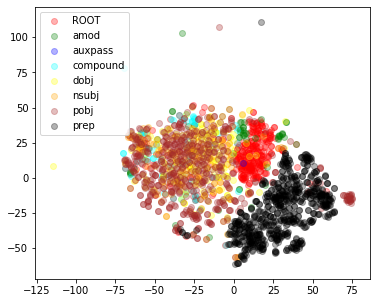

In [141]:
tsne(vecs, data_for_tsen_deps, metric = "l2")

In [152]:
def compute_v_measure(vecs, labels_true, k=10):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k, random_state = 0)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)

In [153]:
v_before = compute_v_measure(vecs, data_for_tsen_deps, k = len(set(data_for_tsen_deps.tolist())))
v_after = compute_v_measure(vecs_rowspace, data_for_tsen_deps, k = len(set(data_for_tsen_deps.tolist())))
print(v_before, v_after)

0.4822887681441252 0.3862469456309194
